In [1]:
!conda install pandas seaborn -y

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
!pip install opencv-python torchsummary scikit-learn torchviz utils imageio

In [3]:
import os

DISABLE_GPU = False
if DISABLE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import utils
import time
from torch.nn.functional import one_hot
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)

['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37'] cuda


In [6]:
from __future__ import print_function
import argparse
import datetime
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
import gc
import matplotlib.colors as mat_color
import numpy as np
from PIL import Image
import random
import cv2
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary
from torchviz import make_dot
import imageio
from torchvision import datasets, transforms

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Discriminator(nn.Module):

    def __init__(self, ndf, nc, nb_label):

        super(Discriminator, self).__init__()
        self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)
        self.DropOut1 = nn.Dropout(p=0.5)
        self.DropOut2 = nn.Dropout(p=0.25)
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ndf * 4)
        self.conv4_1 = nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 1, bias=False)
        self.BatchNorm4_1 = nn.BatchNorm2d(ndf * 4)
        self.conv4_2 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.BatchNorm4_2 = nn.BatchNorm2d(ndf * 8)
        self.conv4_3 = nn.Conv2d(ndf * 8, ndf * 8, 4, 2, 1, bias=False)
        self.BatchNorm4_3 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, ndf * 1, 4, 1, 0, bias=False)
        self.disc_linear = nn.Linear(ndf * 1, 1)
        self.aux_linear = nn.Linear(ndf * 1, nb_label)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.ndf = ndf
        self.apply(weights_init)

    def forward(self, input):

        x = self.conv1(input)
        x = self.LeakyReLU(x)
        x = self.DropOut1(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.LeakyReLU(x)
        #x = self.DropOut(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.LeakyReLU(x)
        x = self.DropOut1(x)

#         x = self.conv4_1(x)
#         x = self.BatchNorm4_1(x)
#         x = self.LeakyReLU(x)
#         x = self.DropOut2(x)
        x = self.conv4_2(x)
        x = self.BatchNorm4_2(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)
        x = self.conv4_3(x)
        x = self.BatchNorm4_3(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)

        x = self.conv5(x)
        x = x.view(-1, self.ndf * 1)
        c = self.aux_linear(x)
        c = self.softmax(c)
        s = self.disc_linear(x)
        s = self.sigmoid(s)
        return s, c

class Generator(nn.Module):

    def __init__(self, nz, ngf, nc):

        super(Generator, self).__init__()
        self.ReLU = nn.ReLU(True)
        self.Tanh = nn.Tanh()
        #self.DropOut = nn.Dropout(p=0.75)
        #self.conv0 = nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 1, bias=False)
        #self.BatchNorm0 = nn.BatchNorm2d(ngf * 16)
        self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ngf * 8)

        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 8, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ngf * 8)

        self.conv3 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ngf * 4)

        self.conv4 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ngf * 2)
        
        self.conv5 = nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 1, bias=False)
        self.BatchNorm5 = nn.BatchNorm2d(ngf * 1)

        self.conv6 = nn.ConvTranspose2d(ngf * 1, nc, 4, 2, 1, bias=False)

        self.apply(weights_init)


    def forward(self, input):
        #x = self.conv0(input)
        #x = self.BatchNorm0(x)
        #x = self.ReLU(x)
        x = self.conv1(input)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

#         x = self.conv2(x)
#         x = self.BatchNorm2(x)
#         x = self.ReLU(x)
#         #x = self.DropOut(x)
        
        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv5(x)
        x = self.BatchNorm5(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv6(x)
        output = self.Tanh(x)
        return output

In [8]:
def generate_animation(path, num):
    images = []
    for e in range(num):
        img_name = path + '_generate_animation_epoch%03d' % (e+1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(path + '_generate_animation.gif', images, fps=5)

def loss_plot_unit(hist, path, model_name, index):
    x = range(len(hist[index[0]]))

    plt.plot(x, hist[index[0]], label=index[0])
    if len(index) >= 2:
        plt.plot(x, hist[index[1]], label=index[1])

    plt.xlabel('Iter')
    plt.ylabel(model_name)

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    now = datetime.datetime.now()
    path = os.path.join(path, now.strftime("%Y-%m-%d_%H-%M-%S_") + model_name + '.png')
    plt.savefig(path)
    plt.close()

def loss_plot(hist, path='Train_hist', model_name=''):
    loss_plot_unit(hist=hist, path=path, model_name='Total_Loss', index=['G_losses', 'D_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='G_C_S_Loss', index=['G_class_losses', 'G_syn_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='D_R_F_Loss', index=['D_real_losses', 'D_fake_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='D_C_S_Loss', index=['D_class_losses', 'D_syn_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='Overall_Loss', index=['Losses'])
    loss_plot_unit(hist=hist, path=path, model_name='Time', index=['Time_per_epoch'])
    loss_plot_unit(hist=hist, path=path, model_name='G_class_losses', index=['G_class_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='G_syn_losses', index=['G_syn_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='D_real_losses', index=['D_real_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='D_fake_losses', index=['D_fake_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='D_class_losses', index=['D_class_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='D_syn_losses', index=['D_syn_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='G_losses', index=['G_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='D_losses', index=['D_losses'])
    

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

def imsave(images, size, path):
    image = np.squeeze(merge(images, size))
    print("image saved at ->", path)
    return imageio.imwrite(path, image)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')

In [9]:
class CACGAN(object):
    def __init__(self):
        self.model_name = 'ACGAN'
        self.I_want_to_train_faster = 25.0
        self.num_epoch = round(12500/self.I_want_to_train_faster)
        self.base_path = './data'
        self.base_folder = "Covid-19 Image Dataset"
        self.classic_folder = 'Coivd-19_Classic'
        self.synthetic_folder = 'Coivd-19_Synthetic'
        self.data_dir = os.path.join(self.base_path, self.classic_folder)
        self.batch_size = 96
        self.train_path = os.path.join(self.data_dir, "train")
        self.test_path = os.path.join(self.data_dir, "test")
        self.labels = os.listdir(self.train_path)
        self.no_norm = mat_color.Normalize(vmin=0, vmax=255, clip=False)
        self.label_dict = {
            i : self.labels[i]
            for i in range(len(self.labels))
        }
        self.img_size = 128 # 256
        self.num_of_ch = 3
        # size of z latent vector (i.e. size of generator input)
        self.size_of_z = self.img_size
        self.num_of_label = len(self.labels)
        self.sample_num = self.num_of_label ** 2
        self.learning_rate_g = 0.0000005 * self.I_want_to_train_faster
        self.learning_rate_d = 0.0000005 * self.I_want_to_train_faster
        # beta1 hyperparam for adam
        self.adam_beta_1 = 0.5
        # beta2 hyperparam for adam
        self.adam_beta_2 = 0.999
        self.real_label = 1.0
        self.fake_label = 0.0
        self.syn_criterion = nn.BCELoss().to(device) # synthesizing
        self.class_criterion = nn.CrossEntropyLoss().to(device) # classification
        
        self.train_loader, self.test_loader, self.train_data, self.test_data = self.load_dataset()
        self.generator = Generator(self.size_of_z, self.img_size, self.num_of_ch).to(device)
        self.discriminator = Discriminator(self.img_size, self.num_of_ch, self.num_of_label).to(device)

        self.optimizer_d = optim.Adam(self.discriminator.parameters(), 
                                      lr=self.learning_rate_d, 
                                      betas=(self.adam_beta_1, self.adam_beta_2))
        self.optimizer_g = optim.Adam(self.generator.parameters(), 
                                      lr=self.learning_rate_g, 
                                      betas=(self.adam_beta_1, self.adam_beta_2))

        # fixed noise & label
        self.sample_z_fixed = torch.zeros((self.sample_num, self.size_of_z))
        for i in range(self.num_of_label):
            self.sample_z_fixed[i*self.num_of_label] = torch.rand(1, self.size_of_z)
            for j in range(1, self.num_of_label):
                self.sample_z_fixed[i*self.num_of_label + j] = self.sample_z_fixed[i*self.num_of_label]

        temp = torch.zeros((self.num_of_label, 1))
        for i in range(self.num_of_label):
            temp[i, 0] = i

        temp_y = torch.zeros((self.sample_num, 1))
        for i in range(self.num_of_label):
            temp_y[i*self.num_of_label: (i+1)*self.num_of_label] = temp

        self.sample_y_fixed = torch.zeros((self.sample_num, self.num_of_label)).scatter_(1, temp_y.type(torch.LongTensor), 1)
        self.sample_z_fixed, self.sample_y_fixed = self.sample_z_fixed.to(device), self.sample_y_fixed.to(device)
        
    def load_dataset(self):
        train_dir = self.train_path
        test_dir = self.test_path
        transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        train_data = datasets.ImageFolder(train_dir, transform=transform)
        train_loader = DataLoader(train_data, self.batch_size, shuffle=True, num_workers=1)

        test_data = datasets.ImageFolder(test_dir ,transform=transform)
        test_loader = DataLoader(test_data, self.batch_size, shuffle=True, num_workers=1)

        return train_loader, test_loader, train_data, test_data

        return train_loader, test_loader, train_data, test_data

    def modeltorchviz(model, input_1, input_2):
        if input_2 != None:
            y = model(input_1.to(device), input_2.to(device))
        else:
            y = model(input_1to(device))
        if input_2 != None:
            MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', input_1)] + [('x', input_2)]))
        else:
            MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', input_1)]))
        MyConvNetVis.format = "png"
        MyConvNetVis.directory = "images"
        MyConvNetVis.view() 
    
    def visualize_results(self, epoch, fix=True):
        self.generator.eval()

        image_frame_dim = round(np.sqrt(self.sample_num))
        if fix:
            """ fixed noise """
            samples = self.generator(self.sample_z_fixed.resize_(self.sample_z_fixed.shape[0], self.sample_z_fixed.shape[1], 1, 1))
        else:
            """ random noise """
            sample_y_ = torch.zeros(self.batch_size, self.class_num).scatter_(1, torch.randint(0, self.class_num - 1, (self.batch_size, 1)).type(torch.LongTensor), 1)
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            sample_z_, sample_y_ = sample_z_.to(device), sample_y_.to(device)
            samples = self.generator(sample_z_.resize_(self.sample_z_.shape[0], self.sample_z_.shape[1], 1, 1))

        samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                    os.path.join('.', 'GANAug/plots/Lung') + "/" + self.model_name + '_generate_animation_epoch%03d' % epoch + '.png')
    
    def train(self):
        for func in [
            lambda: os.mkdir(os.path.join('.', 'GANAug')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/model')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/plots')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/model/Lung')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/plots/Lung')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/Lung')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/Lung/' + self.label_dict[0])),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/Lung/' + self.label_dict[1])),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/Lung/' + self.label_dict[2])),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/Lung/' + self.label_dict[3])),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/Lung/' + self.label_dict[4]))]:
            try:
                func()
            except Exception as error:
                print(error)
                continue
        matrix_fields = [
            'G_losses',
            'G_class_losses',
            'G_syn_losses',
            'D_losses',
            'D_real_losses',
            'D_fake_losses',
            'D_class_losses',
            'D_syn_losses',
            'Losses',
            'Time_per_epoch',
            'Total_time'
        ]
        self.metrics = {field: list() for field in matrix_fields}
        early_stop_count = 0
        early_stop_patient = len(self.train_loader) * 4422 # A ha ha ha ha
        early_stop = False
        best_batch_loss = -1
        save_model = False
        number_of_model_saved = 32
        label_fixed_data = [i%self.num_of_label for i in range(self.sample_num)]
        
        def get_file_list(file_path, length):
            dir_list = os.listdir(file_path)
            dir_list = only_pth_file(dir_list)
            if not dir_list:
                return
            else:
                dir_list = sorted(dir_list,  key=lambda x: os.path.getmtime(os.path.join(file_path, x)))
                print("files to be deleted < length =", length ,"> ->", dir_list[0:length])
                return dir_list[0:length]

        def only_pth_file(file_list):
            new_list = []
            for file in file_list:
                if file[-4:] == ".pth":
                    new_list.append(file)
            return new_list
            
        start_time = time.time()
        print("Start Testing ...")
        print(self.generator)
        print(self.discriminator)
        summary(self.generator, (self.size_of_z, 1, 1), batch_size=self.batch_size, device=device)
        summary(self.discriminator, (self.num_of_ch, self.img_size, self.img_size), batch_size=self.batch_size, device=device)
        g_output = self.generator(torch.rand((self.batch_size, self.size_of_z, 1, 1)).to(device))
        print(g_output.shape)
        s_output, c_output = self.discriminator(torch.rand(g_output.shape).to(device))
        print(s_output.shape)
        print(c_output.shape)
        del g_output, s_output, c_output
        print("Testing Done in ->", time.time() - start_time)
        start_time = time.time()
        print("Start Training ...")

        self.discriminator.train()
        for epoch in range(self.num_epoch):
            epoch += 1
            log_in_data_loader = []
            self.generator.train()
            epoch_start_time = time.time()
            for i, data in enumerate(tqdm(self.train_loader, 0)):
                x_, y_ = data
                batch_size_x_ = x_.size(0)
                z_ = torch.rand((batch_size_x_, self.size_of_z))
                y_vec_ = torch.zeros((batch_size_x_, self.num_of_label)).scatter_(1, y_.type(torch.LongTensor).unsqueeze(1), 1)
                x_, z_, y_vec_ = x_.to(device), z_.to(device), y_vec_.to(device)
                self.y_real_, self.y_fake_ = torch.ones(batch_size_x_, 1), torch.zeros(batch_size_x_, 1)
                self.y_real_, self.y_fake_ = self.y_real_.to(device), self.y_fake_.to(device)
        
                # update D network
                self.optimizer_d.zero_grad()

                D_real, C_real = self.discriminator(x_)
                D_real_loss = self.syn_criterion(D_real, self.y_real_)
                C_real_loss = self.class_criterion(C_real, torch.max(y_vec_, 1)[1])

                G_ = self.generator(z_.resize_(batch_size_x_, self.size_of_z, 1, 1))
                D_fake, C_fake = self.discriminator(G_)
                
                D_fake_loss = self.syn_criterion(D_fake, self.y_fake_)
                C_fake_loss = self.class_criterion(C_fake, torch.max(y_vec_, 1)[1])

                D_loss = D_real_loss + C_real_loss + D_fake_loss + C_fake_loss
                self.metrics['D_losses'].append(D_loss.item())
                self.metrics['D_real_losses'].append((D_real_loss + C_real_loss).item())
                self.metrics['D_fake_losses'].append((D_fake_loss + C_fake_loss).item())
                self.metrics['D_class_losses'].append((C_real_loss + C_fake_loss).item())
                self.metrics['D_syn_losses'].append((D_real_loss + D_fake_loss).item())

                D_loss.backward()
                self.optimizer_d.step()

                # update G network
                self.optimizer_g.zero_grad()

                G_ = self.generator(z_.resize_(batch_size_x_, self.size_of_z, 1, 1))
                D_fake, C_fake = self.discriminator(G_)

                D_fake_loss = self.syn_criterion(D_fake, self.y_real_)
                C_fake_loss = self.class_criterion(C_fake, torch.max(y_vec_, 1)[1])

                G_loss = D_fake_loss + C_fake_loss
                self.metrics['G_losses'].append(G_loss.item())
                self.metrics['G_syn_losses'].append(D_fake_loss.item())
                self.metrics['G_class_losses'].append(C_fake_loss.item())
                self.metrics['Losses'].append(self.metrics['G_losses'][-1] + self.metrics['D_losses'][-1])

                G_loss.backward()
                self.optimizer_g.step()

                if best_batch_loss < 0:
                    best_batch_loss = self.metrics['Losses'][-1]
                    early_stop_count = 0
                else:
                    if best_batch_loss >= self.metrics['Losses'][-1]:
                        best_batch_loss = self.metrics['Losses'][-1]
                        early_stop_count = 0
                        log_in_data_loader.append("---------------------<lowest loss update -> " + str(best_batch_loss) + " at -> " + str(i + 1) + ">---------------------")
                        save_model = True
                    else:
                        early_stop_count += 1
                        if early_stop_count >= early_stop_patient and early_stop == False:
                            log_in_data_loader.append("-----------------------------------< early stopping ... >-----------------------------------")
                            early_stop = True

                if i % round(len(self.train_loader)/5) == 0:
                    vutils.save_image(x_, './GANAug/output_images/Lung/real_samples_e' + str(epoch) + '_d' + str(i) + '.jpg', normalize=True)
                    fake = self.generator(self.sample_z_fixed.resize_(self.sample_z_fixed.shape[0], self.sample_z_fixed.shape[1], 1, 1))
                    for j in range(len(fake)):
                        vutils.save_image(fake[j].data,
                                '%s/fake_samples_epoch_%03d.jpg' % ('./GANAug/output_images/Lung/' + self.label_dict[label_fixed_data[j]], epoch), 
                                          normalize=True)

            self.metrics['Time_per_epoch'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                self.visualize_results(epoch)
    
            for message in log_in_data_loader:
                print(message)
            print('[%d/%d] ======================================================================== \nLoss_D: %.8f,   Loss_G: %.8f,   Loss_S_G: %.8f, Loss_C_G: %.8f\nLoss_S_D: %.8f, Loss_C_D: %.8f, Loss_R_D: %.8f, Loss_F_D: %.8f'
                  % (epoch, self.num_epoch, 
                     np.mean(self.metrics['D_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['G_losses'][-len(self.train_loader):]),
                     np.mean(self.metrics['G_syn_losses'][-len(self.train_loader):]),
                     np.mean(self.metrics['G_class_losses'][-len(self.train_loader):]),
                     np.mean(self.metrics['D_syn_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['D_class_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['D_real_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['D_fake_losses'][-len(self.train_loader):])))

            # do checkpointing
            if save_model == True:
                save_model = False
                torch.save(self.generator.state_dict(), '%s/G_epoch_%d_save_model.pth' % (os.path.join('.', 'GANAug/model/Lung'), epoch))
                torch.save(self.discriminator.state_dict(), '%s/D_epoch_%d_save_model.pth' % (os.path.join('.', 'GANAug/model/Lung'), epoch))
            elif early_stop:
                torch.save(self.generator.state_dict(), '%s/G_epoch_%d_early_stop.pth' % (os.path.join('.', 'GANAug/model/Lung'), epoch))
                torch.save(self.discriminator.state_dict(), '%s/D_epoch_%d_early_stop.pth' % (os.path.join('.', 'GANAug/model/Lung'), epoch))
                break
            elif epoch % round(self.num_epoch/32) == 0:
                torch.save(self.generator.state_dict(), '%s/G_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/Lung'), epoch))
                torch.save(self.discriminator.state_dict(), '%s/D_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/Lung'), epoch))
            else:
                print("---------------------< no model saved at epoch:", epoch, ">---------------------")

            if len(only_pth_file(os.listdir(os.path.join('.', 'GANAug/model/Lung')))) > number_of_model_saved:
                delete_list = get_file_list(os.path.join('.', 'GANAug/model/Lung'), 
                                            len(only_pth_file(os.listdir(os.path.join('.', 'GANAug/model/Lung')))) - number_of_model_saved)
                for file in delete_list:
                    if os.path.exists(os.path.join(os.path.join('.', 'GANAug/model/Lung'), file)):
                        os.remove(os.path.join(os.path.join('.', 'GANAug/model/Lung'), file))
                    else:
                        print("file ->", os.path.join(os.path.join('.', 'GANAug/model/Lung'), file), "does not exist")

        self.metrics['Total_time'].append(time.time() - start_time)
        print("Average epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.metrics['Time_per_epoch']),
                                                                        self.num_epoch, self.metrics['Total_time'][0]))
        generate_animation(os.path.join('.', 'GANAug/plots/Lung/') + self.model_name, self.num_epoch)
        loss_plot(self.metrics, os.path.join('.', 'GANAug/plots/Lung/'))
        print("Training Done !")

In [10]:
acgan = CACGAN()

In [11]:
acgan.train()

[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/model'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/plots'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/plots/Lung'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/output_images'
3
4
Start Testing ...
Generator(
  (ReLU): ReLU(inplace=True)
  (Tanh): Tanh()
  (conv1): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (BatchNorm1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), paddin

C:\Users\lebro\AppData\Local\Temp\ipykernel_20908\1081463272.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = self.softmax(c)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [96, 128, 64, 64]           6,144
         LeakyReLU-2          [96, 128, 64, 64]               0
           Dropout-3          [96, 128, 64, 64]               0
            Conv2d-4          [96, 256, 32, 32]         524,288
       BatchNorm2d-5          [96, 256, 32, 32]             512
         LeakyReLU-6          [96, 256, 32, 32]               0
            Conv2d-7          [96, 512, 16, 16]       2,097,152
       BatchNorm2d-8          [96, 512, 16, 16]           1,024
         LeakyReLU-9          [96, 512, 16, 16]               0
          Dropout-10          [96, 512, 16, 16]               0
           Conv2d-11           [96, 1024, 8, 8]       8,388,608
      BatchNorm2d-12           [96, 1024, 8, 8]           2,048
        LeakyReLU-13           [96, 1024, 8, 8]               0
          Dropout-14           [96, 102

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch001.png
---------------------<lowest loss update -> 6.029555797576904 at -> 2>---------------------
---------------------<lowest loss update -> 5.769361972808838 at -> 6>---------------------
---------------------<lowest loss update -> 5.7630908489227295 at -> 10>---------------------
[1/500] ======================================================================== 
Loss_D: 3.50802309,   Loss_G: 2.42315176,   Loss_S_G: 1.32699874, Loss_C_G: 1.09615303
Loss_S_D: 1.30655263, Loss_C_D: 2.20147041, Loss_R_D: 1.65093644, Loss_F_D: 1.85708660


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch002.png
---------------------<lowest loss update -> 5.635125160217285 at -> 3>---------------------
---------------------<lowest loss update -> 5.602004289627075 at -> 8>---------------------
---------------------<lowest loss update -> 5.522130012512207 at -> 19>---------------------
[2/500] ======================================================================== 
Loss_D: 3.05147832,   Loss_G: 2.77415319,   Loss_S_G: 1.68039890, Loss_C_G: 1.09375427
Loss_S_D: 0.97016411, Loss_C_D: 2.08131419, Loss_R_D: 1.44566581, Loss_F_D: 1.60581250


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch003.png
[3/500] ======================================================================== 
Loss_D: 2.97441742,   Loss_G: 3.05298785,   Loss_S_G: 1.97076696, Loss_C_G: 1.08222088
Loss_S_D: 0.97998767, Loss_C_D: 1.99442975, Loss_R_D: 1.42628781, Loss_F_D: 1.54812961
---------------------< no model saved at epoch: 3 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch004.png
[4/500] ======================================================================== 
Loss_D: 3.04442246,   Loss_G: 3.05643797,   Loss_S_G: 1.96934786, Loss_C_G: 1.08709015
Loss_S_D: 1.10585287, Loss_C_D: 1.93856960, Loss_R_D: 1.53226695, Loss_F_D: 1.51215553
---------------------< no model saved at epoch: 4 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch005.png
[5/500] ======================================================================== 
Loss_D: 3.08109419,   Loss_G: 3.04055196,   Loss_S_G: 1.94177055, Loss_C_G: 1.09878141
Loss_S_D: 1.17016752, Loss_C_D: 1.91092666, Loss_R_D: 1.54457436, Loss_F_D: 1.53651985
---------------------< no model saved at epoch: 5 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch006.png
[6/500] ======================================================================== 
Loss_D: 3.10137264,   Loss_G: 2.95772644,   Loss_S_G: 1.87074235, Loss_C_G: 1.08698408
Loss_S_D: 1.22501013, Loss_C_D: 1.87636249, Loss_R_D: 1.54392333, Loss_F_D: 1.55744932
---------------------< no model saved at epoch: 6 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch007.png
[7/500] ======================================================================== 
Loss_D: 2.97213521,   Loss_G: 2.92703616,   Loss_S_G: 1.84115703, Loss_C_G: 1.08587913
Loss_S_D: 1.10112796, Loss_C_D: 1.87100724, Loss_R_D: 1.44340920, Loss_F_D: 1.52872601
---------------------< no model saved at epoch: 7 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch008.png
[8/500] ======================================================================== 
Loss_D: 2.90200835,   Loss_G: 3.00300828,   Loss_S_G: 1.91523677, Loss_C_G: 1.08777151
Loss_S_D: 1.04434993, Loss_C_D: 1.85765839, Loss_R_D: 1.38461883, Loss_F_D: 1.51738950
---------------------< no model saved at epoch: 8 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:56<00:00,  2.95s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch009.png
[9/500] ======================================================================== 
Loss_D: 2.80401202,   Loss_G: 3.07374533,   Loss_S_G: 1.98187536, Loss_C_G: 1.09186996
Loss_S_D: 0.95431911, Loss_C_D: 1.84969292, Loss_R_D: 1.29766555, Loss_F_D: 1.50634648
---------------------< no model saved at epoch: 9 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.91s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch010.png
[10/500] ======================================================================== 
Loss_D: 2.71281599,   Loss_G: 3.14158663,   Loss_S_G: 2.05044662, Loss_C_G: 1.09114001
Loss_S_D: 0.86002940, Loss_C_D: 1.85278660, Loss_R_D: 1.23516710, Loss_F_D: 1.47764892
---------------------< no model saved at epoch: 10 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch011.png
---------------------<lowest loss update -> 5.511639595031738 at -> 13>---------------------
---------------------<lowest loss update -> 5.387089490890503 at -> 19>---------------------
[11/500] ======================================================================== 
Loss_D: 2.57154329,   Loss_G: 3.22403272,   Loss_S_G: 2.12977666, Loss_C_G: 1.09425607
Loss_S_D: 0.74510291, Loss_C_D: 1.82644038, Loss_R_D: 1.14688135, Loss_F_D: 1.42466197


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch012.png
---------------------<lowest loss update -> 5.38616418838501 at -> 10>---------------------
---------------------<lowest loss update -> 5.321947813034058 at -> 19>---------------------
[12/500] ======================================================================== 
Loss_D: 2.51897323,   Loss_G: 3.30749600,   Loss_S_G: 2.21385529, Loss_C_G: 1.09364071
Loss_S_D: 0.69010749, Loss_C_D: 1.82886572, Loss_R_D: 1.10891099, Loss_F_D: 1.41006224


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch013.png
[13/500] ======================================================================== 
Loss_D: 2.45566911,   Loss_G: 3.52855584,   Loss_S_G: 2.43647067, Loss_C_G: 1.09208522
Loss_S_D: 0.63390421, Loss_C_D: 1.82176485, Loss_R_D: 1.07333693, Loss_F_D: 1.38233214
---------------------< no model saved at epoch: 13 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch014.png
---------------------<lowest loss update -> 4.776851654052734 at -> 19>---------------------
[14/500] ======================================================================== 
Loss_D: 2.34697160,   Loss_G: 3.59425552,   Loss_S_G: 2.48803405, Loss_C_G: 1.10622148
Loss_S_D: 0.53726268, Loss_C_D: 1.80970890, Loss_R_D: 1.01549042, Loss_F_D: 1.33148117


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch015.png
[15/500] ======================================================================== 
Loss_D: 2.41276411,   Loss_G: 3.85340456,   Loss_S_G: 2.75145294, Loss_C_G: 1.10195167
Loss_S_D: 0.59579652, Loss_C_D: 1.81696760, Loss_R_D: 1.05130628, Loss_F_D: 1.36145785
---------------------< no model saved at epoch: 15 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch016.png
---------------------<lowest loss update -> 4.758385181427002 at -> 10>---------------------
[16/500] ======================================================================== 
Loss_D: 2.47247056,   Loss_G: 3.80256243,   Loss_S_G: 2.70293134, Loss_C_G: 1.09963111
Loss_S_D: 0.65298852, Loss_C_D: 1.81948208, Loss_R_D: 1.07750185, Loss_F_D: 1.39496874


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch017.png
[17/500] ======================================================================== 
Loss_D: 2.28927176,   Loss_G: 3.83985878,   Loss_S_G: 2.73790971, Loss_C_G: 1.10194901
Loss_S_D: 0.48833858, Loss_C_D: 1.80093317, Loss_R_D: 0.99687869, Loss_F_D: 1.29239306
---------------------< no model saved at epoch: 17 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch018.png
[18/500] ======================================================================== 
Loss_D: 2.18739730,   Loss_G: 4.04271360,   Loss_S_G: 2.95241133, Loss_C_G: 1.09030230
Loss_S_D: 0.39319917, Loss_C_D: 1.79419814, Loss_R_D: 0.94546827, Loss_F_D: 1.24192905
---------------------< no model saved at epoch: 18 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch019.png
[19/500] ======================================================================== 
Loss_D: 2.54297809,   Loss_G: 3.90397481,   Loss_S_G: 2.81626429, Loss_C_G: 1.08771052
Loss_S_D: 0.75290846, Loss_C_D: 1.79006960, Loss_R_D: 1.16109604, Loss_F_D: 1.38188203
---------------------< no model saved at epoch: 19 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch020.png
[20/500] ======================================================================== 
Loss_D: 2.33025389,   Loss_G: 4.12776372,   Loss_S_G: 3.02070500, Loss_C_G: 1.10705871
Loss_S_D: 0.51911392, Loss_C_D: 1.81113996, Loss_R_D: 0.99750321, Loss_F_D: 1.33275064
---------------------< no model saved at epoch: 20 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch021.png
[21/500] ======================================================================== 
Loss_D: 2.54762128,   Loss_G: 4.16572676,   Loss_S_G: 3.06552567, Loss_C_G: 1.10020105
Loss_S_D: 0.74744494, Loss_C_D: 1.80017628, Loss_R_D: 1.14970121, Loss_F_D: 1.39792003
---------------------< no model saved at epoch: 21 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch022.png
[22/500] ======================================================================== 
Loss_D: 2.86786110,   Loss_G: 4.10350895,   Loss_S_G: 3.00302229, Loss_C_G: 1.10048671
Loss_S_D: 1.06774467, Loss_C_D: 1.80011638, Loss_R_D: 1.39299496, Loss_F_D: 1.47486607
---------------------< no model saved at epoch: 22 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch023.png
[23/500] ======================================================================== 
Loss_D: 2.66018588,   Loss_G: 3.97404767,   Loss_S_G: 2.88853668, Loss_C_G: 1.08551102
Loss_S_D: 0.87795750, Loss_C_D: 1.78222837, Loss_R_D: 1.28325630, Loss_F_D: 1.37692960
---------------------< no model saved at epoch: 23 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch024.png
[24/500] ======================================================================== 
Loss_D: 2.43481457,   Loss_G: 3.97408447,   Loss_S_G: 2.88983535, Loss_C_G: 1.08424912
Loss_S_D: 0.64714677, Loss_C_D: 1.78766776, Loss_R_D: 1.11871159, Loss_F_D: 1.31610294
---------------------< no model saved at epoch: 24 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch025.png
[25/500] ======================================================================== 
Loss_D: 2.49476140,   Loss_G: 4.35164906,   Loss_S_G: 3.24735057, Loss_C_G: 1.10429851
Loss_S_D: 0.69189861, Loss_C_D: 1.80286276, Loss_R_D: 1.10832404, Loss_F_D: 1.38643733
---------------------< no model saved at epoch: 25 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch026.png
[26/500] ======================================================================== 
Loss_D: 2.47543329,   Loss_G: 3.88571872,   Loss_S_G: 2.79480261, Loss_C_G: 1.09091614
Loss_S_D: 0.69288357, Loss_C_D: 1.78254973, Loss_R_D: 1.11983433, Loss_F_D: 1.35559896
---------------------< no model saved at epoch: 26 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch027.png
[27/500] ======================================================================== 
Loss_D: 2.44122828,   Loss_G: 4.03322520,   Loss_S_G: 2.93409720, Loss_C_G: 1.09912796
Loss_S_D: 0.65683115, Loss_C_D: 1.78439712, Loss_R_D: 1.10215548, Loss_F_D: 1.33907280
---------------------< no model saved at epoch: 27 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch028.png
[28/500] ======================================================================== 
Loss_D: 2.61860455,   Loss_G: 4.05356080,   Loss_S_G: 2.95069949, Loss_C_G: 1.10286129
Loss_S_D: 0.83680877, Loss_C_D: 1.78179578, Loss_R_D: 1.19391981, Loss_F_D: 1.42468475
---------------------< no model saved at epoch: 28 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch029.png
[29/500] ======================================================================== 
Loss_D: 2.63349029,   Loss_G: 3.87575867,   Loss_S_G: 2.77216318, Loss_C_G: 1.10359553
Loss_S_D: 0.84201752, Loss_C_D: 1.79147272, Loss_R_D: 1.20475529, Loss_F_D: 1.42873496
---------------------< no model saved at epoch: 29 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch030.png
[30/500] ======================================================================== 
Loss_D: 2.48193810,   Loss_G: 3.78725719,   Loss_S_G: 2.69734076, Loss_C_G: 1.08991642
Loss_S_D: 0.68313393, Loss_C_D: 1.79880416, Loss_R_D: 1.12875244, Loss_F_D: 1.35318568
---------------------< no model saved at epoch: 30 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch031.png
[31/500] ======================================================================== 
Loss_D: 2.32663594,   Loss_G: 4.20363264,   Loss_S_G: 3.10820697, Loss_C_G: 1.09542572
Loss_S_D: 0.51345822, Loss_C_D: 1.81317770, Loss_R_D: 0.99228157, Loss_F_D: 1.33435433
---------------------< no model saved at epoch: 31 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch032.png
[32/500] ======================================================================== 
Loss_D: 2.76299459,   Loss_G: 3.68909932,   Loss_S_G: 2.57891938, Loss_C_G: 1.11017995
Loss_S_D: 0.91758922, Loss_C_D: 1.84540537, Loss_R_D: 1.28200956, Loss_F_D: 1.48098503


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch033.png
[33/500] ======================================================================== 
Loss_D: 2.51056578,   Loss_G: 3.89591363,   Loss_S_G: 2.80493502, Loss_C_G: 1.09097857
Loss_S_D: 0.70640832, Loss_C_D: 1.80415745, Loss_R_D: 1.15009173, Loss_F_D: 1.36047404
---------------------< no model saved at epoch: 33 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch034.png
[34/500] ======================================================================== 
Loss_D: 2.46009354,   Loss_G: 4.05060133,   Loss_S_G: 2.95948995, Loss_C_G: 1.09111138
Loss_S_D: 0.67370625, Loss_C_D: 1.78638727, Loss_R_D: 1.10302386, Loss_F_D: 1.35706967
---------------------< no model saved at epoch: 34 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch035.png
[35/500] ======================================================================== 
Loss_D: 2.23070867,   Loss_G: 4.13696187,   Loss_S_G: 3.04756392, Loss_C_G: 1.08939794
Loss_S_D: 0.45667518, Loss_C_D: 1.77403352, Loss_R_D: 0.95764096, Loss_F_D: 1.27306770
---------------------< no model saved at epoch: 35 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch036.png
[36/500] ======================================================================== 
Loss_D: 2.16326628,   Loss_G: 4.44180817,   Loss_S_G: 3.34502336, Loss_C_G: 1.09678482
Loss_S_D: 0.39118971, Loss_C_D: 1.77207657, Loss_R_D: 0.91434436, Loss_F_D: 1.24892189
---------------------< no model saved at epoch: 36 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch037.png
[37/500] ======================================================================== 
Loss_D: 2.36011721,   Loss_G: 4.66529304,   Loss_S_G: 3.57777409, Loss_C_G: 1.08751893
Loss_S_D: 0.59114078, Loss_C_D: 1.76897649, Loss_R_D: 0.98401092, Loss_F_D: 1.37610631
---------------------< no model saved at epoch: 37 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch038.png
[38/500] ======================================================================== 
Loss_D: 2.31605862,   Loss_G: 5.08797836,   Loss_S_G: 3.98429426, Loss_C_G: 1.10368407
Loss_S_D: 0.54064748, Loss_C_D: 1.77541119, Loss_R_D: 0.90596135, Loss_F_D: 1.41009730
---------------------< no model saved at epoch: 38 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch039.png
[39/500] ======================================================================== 
Loss_D: 2.34268119,   Loss_G: 4.68511403,   Loss_S_G: 3.59068784, Loss_C_G: 1.09442621
Loss_S_D: 0.58776649, Loss_C_D: 1.75491470, Loss_R_D: 1.04861421, Loss_F_D: 1.29406698
---------------------< no model saved at epoch: 39 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch040.png
[40/500] ======================================================================== 
Loss_D: 2.45764247,   Loss_G: 4.39952110,   Loss_S_G: 3.30634471, Loss_C_G: 1.09317639
Loss_S_D: 0.69180410, Loss_C_D: 1.76583839, Loss_R_D: 1.15858620, Loss_F_D: 1.29905627
---------------------< no model saved at epoch: 40 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch041.png
---------------------<lowest loss update -> 4.684554576873779 at -> 9>---------------------
[41/500] ======================================================================== 
Loss_D: 2.61412666,   Loss_G: 4.41723948,   Loss_S_G: 3.32302054, Loss_C_G: 1.09421897
Loss_S_D: 0.84104428, Loss_C_D: 1.77308241, Loss_R_D: 1.26588144, Loss_F_D: 1.34824524


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch042.png
[42/500] ======================================================================== 
Loss_D: 2.52926325,   Loss_G: 4.41738989,   Loss_S_G: 3.32324487, Loss_C_G: 1.09414500
Loss_S_D: 0.76556567, Loss_C_D: 1.76369761, Loss_R_D: 1.17835902, Loss_F_D: 1.35090422
---------------------< no model saved at epoch: 42 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch043.png
[43/500] ======================================================================== 
Loss_D: 2.41397825,   Loss_G: 4.02150050,   Loss_S_G: 2.92939387, Loss_C_G: 1.09210663
Loss_S_D: 0.65872652, Loss_C_D: 1.75525176, Loss_R_D: 1.07315148, Loss_F_D: 1.34082679
---------------------< no model saved at epoch: 43 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch044.png
[44/500] ======================================================================== 
Loss_D: 2.09747124,   Loss_G: 4.28901474,   Loss_S_G: 3.19092152, Loss_C_G: 1.09809316
Loss_S_D: 0.34331838, Loss_C_D: 1.75415286, Loss_R_D: 0.86554686, Loss_F_D: 1.23192440
---------------------< no model saved at epoch: 44 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch045.png
[45/500] ======================================================================== 
Loss_D: 2.17236544,   Loss_G: 4.30702144,   Loss_S_G: 3.21054536, Loss_C_G: 1.09647607
Loss_S_D: 0.41611635, Loss_C_D: 1.75624908, Loss_R_D: 0.91091470, Loss_F_D: 1.26145074
---------------------< no model saved at epoch: 45 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch046.png
[46/500] ======================================================================== 
Loss_D: 2.04465416,   Loss_G: 4.46077126,   Loss_S_G: 3.35414027, Loss_C_G: 1.10663101
Loss_S_D: 0.28300015, Loss_C_D: 1.76165402, Loss_R_D: 0.82827233, Loss_F_D: 1.21638184
---------------------< no model saved at epoch: 46 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch047.png
[47/500] ======================================================================== 
Loss_D: 2.39640867,   Loss_G: 4.62744068,   Loss_S_G: 3.51947753, Loss_C_G: 1.10796312
Loss_S_D: 0.62466268, Loss_C_D: 1.77174602, Loss_R_D: 1.06168235, Loss_F_D: 1.33472633
---------------------< no model saved at epoch: 47 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch048.png
[48/500] ======================================================================== 
Loss_D: 2.90519382,   Loss_G: 3.97068335,   Loss_S_G: 2.88067432, Loss_C_G: 1.09000901
Loss_S_D: 1.14990260, Loss_C_D: 1.75529122, Loss_R_D: 1.41001128, Loss_F_D: 1.49518253


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch049.png
[49/500] ======================================================================== 
Loss_D: 2.11942885,   Loss_G: 4.22031058,   Loss_S_G: 3.13114135, Loss_C_G: 1.08916925
Loss_S_D: 0.37442288, Loss_C_D: 1.74500598, Loss_R_D: 0.88741084, Loss_F_D: 1.23201800
---------------------< no model saved at epoch: 49 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch050.png
[50/500] ======================================================================== 
Loss_D: 2.16473155,   Loss_G: 4.26602608,   Loss_S_G: 3.16800706, Loss_C_G: 1.09801904
Loss_S_D: 0.40240452, Loss_C_D: 1.76232704, Loss_R_D: 0.90105394, Loss_F_D: 1.26367763
---------------------< no model saved at epoch: 50 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch051.png
[51/500] ======================================================================== 
Loss_D: 2.41963501,   Loss_G: 4.36049655,   Loss_S_G: 3.26460249, Loss_C_G: 1.09589406
Loss_S_D: 0.65238465, Loss_C_D: 1.76725036, Loss_R_D: 1.05681881, Loss_F_D: 1.36281621
---------------------< no model saved at epoch: 51 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch052.png
[52/500] ======================================================================== 
Loss_D: 2.41873740,   Loss_G: 3.95164300,   Loss_S_G: 2.85867473, Loss_C_G: 1.09296829
Loss_S_D: 0.66907299, Loss_C_D: 1.74966440, Loss_R_D: 1.10072863, Loss_F_D: 1.31800876
---------------------< no model saved at epoch: 52 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch053.png
[53/500] ======================================================================== 
Loss_D: 2.07307401,   Loss_G: 4.26765656,   Loss_S_G: 3.18737348, Loss_C_G: 1.08028306
Loss_S_D: 0.32838893, Loss_C_D: 1.74468507, Loss_R_D: 0.85073606, Loss_F_D: 1.22233794
---------------------< no model saved at epoch: 53 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch054.png
[54/500] ======================================================================== 
Loss_D: 2.00316804,   Loss_G: 4.63868912,   Loss_S_G: 3.53717810, Loss_C_G: 1.10151103
Loss_S_D: 0.23463834, Loss_C_D: 1.76852969, Loss_R_D: 0.75903814, Loss_F_D: 1.24412990
---------------------< no model saved at epoch: 54 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch055.png
[55/500] ======================================================================== 
Loss_D: 2.02516346,   Loss_G: 4.47795288,   Loss_S_G: 3.37390232, Loss_C_G: 1.10405060
Loss_S_D: 0.25239685, Loss_C_D: 1.77276660, Loss_R_D: 0.78982173, Loss_F_D: 1.23534171
---------------------< no model saved at epoch: 55 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch056.png
[56/500] ======================================================================== 
Loss_D: 2.46884815,   Loss_G: 4.29691674,   Loss_S_G: 3.20093684, Loss_C_G: 1.09597987
Loss_S_D: 0.68112515, Loss_C_D: 1.78772300, Loss_R_D: 1.07963751, Loss_F_D: 1.38921066
---------------------< no model saved at epoch: 56 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch057.png
[57/500] ======================================================================== 
Loss_D: 2.21776495,   Loss_G: 4.35355416,   Loss_S_G: 3.26130601, Loss_C_G: 1.09224813
Loss_S_D: 0.46500064, Loss_C_D: 1.75276429, Loss_R_D: 0.95648292, Loss_F_D: 1.26128201
---------------------< no model saved at epoch: 57 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch058.png
[58/500] ======================================================================== 
Loss_D: 2.03391150,   Loss_G: 4.53198192,   Loss_S_G: 3.43255675, Loss_C_G: 1.09942515
Loss_S_D: 0.29202649, Loss_C_D: 1.74188506, Loss_R_D: 0.83377057, Loss_F_D: 1.20014094
---------------------< no model saved at epoch: 58 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch059.png
[59/500] ======================================================================== 
Loss_D: 1.98901024,   Loss_G: 4.70161417,   Loss_S_G: 3.61289127, Loss_C_G: 1.08872286
Loss_S_D: 0.24072725, Loss_C_D: 1.74828300, Loss_R_D: 0.80083144, Loss_F_D: 1.18817883
---------------------< no model saved at epoch: 59 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch060.png
[60/500] ======================================================================== 
Loss_D: 2.07253127,   Loss_G: 4.58234250,   Loss_S_G: 3.48742033, Loss_C_G: 1.09492216
Loss_S_D: 0.32558010, Loss_C_D: 1.74695120, Loss_R_D: 0.85272663, Loss_F_D: 1.21980464
---------------------< no model saved at epoch: 60 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch061.png
[61/500] ======================================================================== 
Loss_D: 2.10240540,   Loss_G: 4.45153331,   Loss_S_G: 3.35498256, Loss_C_G: 1.09655078
Loss_S_D: 0.33166719, Loss_C_D: 1.77073821, Loss_R_D: 0.85705544, Loss_F_D: 1.24534996
---------------------< no model saved at epoch: 61 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch062.png
[62/500] ======================================================================== 
Loss_D: 1.99274273,   Loss_G: 4.57179366,   Loss_S_G: 3.49098428, Loss_C_G: 1.08080934
Loss_S_D: 0.25273043, Loss_C_D: 1.74001231, Loss_R_D: 0.78459868, Loss_F_D: 1.20814404
---------------------< no model saved at epoch: 62 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch063.png
[63/500] ======================================================================== 
Loss_D: 1.96547198,   Loss_G: 4.61363910,   Loss_S_G: 3.52887042, Loss_C_G: 1.08476870
Loss_S_D: 0.23020571, Loss_C_D: 1.73526626, Loss_R_D: 0.77528138, Loss_F_D: 1.19019060
---------------------< no model saved at epoch: 63 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch064.png
[64/500] ======================================================================== 
Loss_D: 2.22010496,   Loss_G: 4.60273943,   Loss_S_G: 3.51476223, Loss_C_G: 1.08797721
Loss_S_D: 0.48570357, Loss_C_D: 1.73440142, Loss_R_D: 0.93507969, Loss_F_D: 1.28502530


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch065.png
[65/500] ======================================================================== 
Loss_D: 2.08019160,   Loss_G: 4.60504903,   Loss_S_G: 3.52292949, Loss_C_G: 1.08211957
Loss_S_D: 0.34825346, Loss_C_D: 1.73193809, Loss_R_D: 0.84380604, Loss_F_D: 1.23638553
---------------------< no model saved at epoch: 65 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch066.png
[66/500] ======================================================================== 
Loss_D: 2.14659270,   Loss_G: 4.45699235,   Loss_S_G: 3.36223073, Loss_C_G: 1.09476165
Loss_S_D: 0.41493787, Loss_C_D: 1.73165484, Loss_R_D: 0.90622679, Loss_F_D: 1.24036593
---------------------< no model saved at epoch: 66 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch067.png
[67/500] ======================================================================== 
Loss_D: 2.05126639,   Loss_G: 4.69731456,   Loss_S_G: 3.60092432, Loss_C_G: 1.09639023
Loss_S_D: 0.32071967, Loss_C_D: 1.73054673, Loss_R_D: 0.84304780, Loss_F_D: 1.20821859
---------------------< no model saved at epoch: 67 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch068.png
[68/500] ======================================================================== 
Loss_D: 2.12173047,   Loss_G: 5.40285863,   Loss_S_G: 4.30314136, Loss_C_G: 1.09971732
Loss_S_D: 0.36987486, Loss_C_D: 1.75185565, Loss_R_D: 0.82563993, Loss_F_D: 1.29609054
---------------------< no model saved at epoch: 68 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch069.png
[69/500] ======================================================================== 
Loss_D: 1.93542748,   Loss_G: 5.21327947,   Loss_S_G: 4.11078133, Loss_C_G: 1.10249815
Loss_S_D: 0.19255998, Loss_C_D: 1.74286753, Loss_R_D: 0.73538640, Loss_F_D: 1.20004111
---------------------< no model saved at epoch: 69 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch070.png
[70/500] ======================================================================== 
Loss_D: 2.00656666,   Loss_G: 5.17869465,   Loss_S_G: 4.07891907, Loss_C_G: 1.09977559
Loss_S_D: 0.26214107, Loss_C_D: 1.74442562, Loss_R_D: 0.81017190, Loss_F_D: 1.19639477
---------------------< no model saved at epoch: 70 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch071.png
[71/500] ======================================================================== 
Loss_D: 1.93702277,   Loss_G: 5.05535854,   Loss_S_G: 3.96464521, Loss_C_G: 1.09071334
Loss_S_D: 0.20187890, Loss_C_D: 1.73514387, Loss_R_D: 0.76056060, Loss_F_D: 1.17646216
---------------------< no model saved at epoch: 71 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch072.png
[72/500] ======================================================================== 
Loss_D: 1.96362280,   Loss_G: 5.17350503,   Loss_S_G: 4.08397018, Loss_C_G: 1.08953483
Loss_S_D: 0.23517118, Loss_C_D: 1.72845163, Loss_R_D: 0.76577490, Loss_F_D: 1.19784791
---------------------< no model saved at epoch: 72 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch073.png
[73/500] ======================================================================== 
Loss_D: 1.98804618,   Loss_G: 5.02884574,   Loss_S_G: 3.92581532, Loss_C_G: 1.10303035
Loss_S_D: 0.25353299, Loss_C_D: 1.73451319, Loss_R_D: 0.77695255, Loss_F_D: 1.21109363
---------------------< no model saved at epoch: 73 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch074.png
[74/500] ======================================================================== 
Loss_D: 2.01329659,   Loss_G: 5.04914562,   Loss_S_G: 3.95792950, Loss_C_G: 1.09121611
Loss_S_D: 0.27739147, Loss_C_D: 1.73590510, Loss_R_D: 0.82777576, Loss_F_D: 1.18552084
---------------------< no model saved at epoch: 74 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch075.png
[75/500] ======================================================================== 
Loss_D: 2.22698156,   Loss_G: 4.68429917,   Loss_S_G: 3.59384057, Loss_C_G: 1.09045854
Loss_S_D: 0.48913466, Loss_C_D: 1.73784693, Loss_R_D: 1.01092695, Loss_F_D: 1.21605462
---------------------< no model saved at epoch: 75 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.94s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch076.png
[76/500] ======================================================================== 
Loss_D: 2.44643588,   Loss_G: 4.59199578,   Loss_S_G: 3.49777910, Loss_C_G: 1.09421669
Loss_S_D: 0.68908551, Loss_C_D: 1.75735037, Loss_R_D: 1.11994859, Loss_F_D: 1.32648726
---------------------< no model saved at epoch: 76 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch077.png
---------------------<lowest loss update -> 4.358632564544678 at -> 2>---------------------
[77/500] ======================================================================== 
Loss_D: 2.19328850,   Loss_G: 4.69692538,   Loss_S_G: 3.59050888, Loss_C_G: 1.10641650
Loss_S_D: 0.42868320, Loss_C_D: 1.76460525, Loss_R_D: 0.96338949, Loss_F_D: 1.22989896


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch078.png
[78/500] ======================================================================== 
Loss_D: 2.49857655,   Loss_G: 4.50851726,   Loss_S_G: 3.41728030, Loss_C_G: 1.09123699
Loss_S_D: 0.72955786, Loss_C_D: 1.76901868, Loss_R_D: 1.13852747, Loss_F_D: 1.36004907
---------------------< no model saved at epoch: 78 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch079.png
[79/500] ======================================================================== 
Loss_D: 2.13049013,   Loss_G: 4.40728386,   Loss_S_G: 3.32646265, Loss_C_G: 1.08082123
Loss_S_D: 0.37776722, Loss_C_D: 1.75272294, Loss_R_D: 0.89800790, Loss_F_D: 1.23248225
---------------------< no model saved at epoch: 79 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch080.png
[80/500] ======================================================================== 
Loss_D: 1.95266151,   Loss_G: 4.80914954,   Loss_S_G: 3.71585074, Loss_C_G: 1.09329882
Loss_S_D: 0.20440937, Loss_C_D: 1.74825215, Loss_R_D: 0.77224386, Loss_F_D: 1.18041766


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.91s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch081.png
[81/500] ======================================================================== 
Loss_D: 2.08371307,   Loss_G: 4.50586378,   Loss_S_G: 3.41029936, Loss_C_G: 1.09556441
Loss_S_D: 0.34140203, Loss_C_D: 1.74231103, Loss_R_D: 0.85705904, Loss_F_D: 1.22665405
---------------------< no model saved at epoch: 81 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.92s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch082.png
[82/500] ======================================================================== 
Loss_D: 1.91051443,   Loss_G: 4.75634515,   Loss_S_G: 3.66605184, Loss_C_G: 1.09029327
Loss_S_D: 0.18098824, Loss_C_D: 1.72952621, Loss_R_D: 0.74446946, Loss_F_D: 1.16604500
---------------------< no model saved at epoch: 82 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.90s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch083.png
[83/500] ======================================================================== 
Loss_D: 2.02648361,   Loss_G: 4.53076355,   Loss_S_G: 3.43079670, Loss_C_G: 1.09996688
Loss_S_D: 0.29154074, Loss_C_D: 1.73494293, Loss_R_D: 0.80979547, Loss_F_D: 1.21668816
---------------------< no model saved at epoch: 83 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch084.png
[84/500] ======================================================================== 
Loss_D: 2.10421037,   Loss_G: 4.63232002,   Loss_S_G: 3.54041880, Loss_C_G: 1.09190123
Loss_S_D: 0.38654368, Loss_C_D: 1.71766667, Loss_R_D: 0.86165094, Loss_F_D: 1.24255942
---------------------< no model saved at epoch: 84 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch085.png
[85/500] ======================================================================== 
Loss_D: 1.95679994,   Loss_G: 4.51740438,   Loss_S_G: 3.41875912, Loss_C_G: 1.09864529
Loss_S_D: 0.22792642, Loss_C_D: 1.72887352, Loss_R_D: 0.76495444, Loss_F_D: 1.19184551
---------------------< no model saved at epoch: 85 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch086.png
[86/500] ======================================================================== 
Loss_D: 1.88628443,   Loss_G: 4.72169015,   Loss_S_G: 3.62346687, Loss_C_G: 1.09822330
Loss_S_D: 0.16344941, Loss_C_D: 1.72283503, Loss_R_D: 0.71569817, Loss_F_D: 1.17058630
---------------------< no model saved at epoch: 86 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch087.png
[87/500] ======================================================================== 
Loss_D: 1.89018322,   Loss_G: 5.00906347,   Loss_S_G: 3.91242621, Loss_C_G: 1.09663723
Loss_S_D: 0.15531963, Loss_C_D: 1.73486358, Loss_R_D: 0.72624168, Loss_F_D: 1.16394153
---------------------< no model saved at epoch: 87 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch088.png
[88/500] ======================================================================== 
Loss_D: 1.81327061,   Loss_G: 5.37412684,   Loss_S_G: 4.27910453, Loss_C_G: 1.09502231
Loss_S_D: 0.08446199, Loss_C_D: 1.72880862, Loss_R_D: 0.67851116, Loss_F_D: 1.13475945
---------------------< no model saved at epoch: 88 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch089.png
[89/500] ======================================================================== 
Loss_D: 1.97505564,   Loss_G: 4.88950195,   Loss_S_G: 3.78980112, Loss_C_G: 1.09970080
Loss_S_D: 0.24363950, Loss_C_D: 1.73141614, Loss_R_D: 0.78968052, Loss_F_D: 1.18537510
---------------------< no model saved at epoch: 89 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.90s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch090.png
[90/500] ======================================================================== 
Loss_D: 1.97933633,   Loss_G: 4.97540655,   Loss_S_G: 3.86775758, Loss_C_G: 1.10764894
Loss_S_D: 0.24643357, Loss_C_D: 1.73290278, Loss_R_D: 0.79166020, Loss_F_D: 1.18767612
---------------------< no model saved at epoch: 90 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch091.png
[91/500] ======================================================================== 
Loss_D: 2.07942741,   Loss_G: 5.10212158,   Loss_S_G: 3.99599454, Loss_C_G: 1.10612704
Loss_S_D: 0.34251769, Loss_C_D: 1.73690973, Loss_R_D: 0.85910445, Loss_F_D: 1.22032294
---------------------< no model saved at epoch: 91 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch092.png
[92/500] ======================================================================== 
Loss_D: 2.03900843,   Loss_G: 5.02570835,   Loss_S_G: 3.92341749, Loss_C_G: 1.10229089
Loss_S_D: 0.30559690, Loss_C_D: 1.73341153, Loss_R_D: 0.81036326, Loss_F_D: 1.22864516
---------------------< no model saved at epoch: 92 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch093.png
[93/500] ======================================================================== 
Loss_D: 1.92723805,   Loss_G: 4.83867477,   Loss_S_G: 3.75233946, Loss_C_G: 1.08633536
Loss_S_D: 0.19015494, Loss_C_D: 1.73708313, Loss_R_D: 0.75062685, Loss_F_D: 1.17661120
---------------------< no model saved at epoch: 93 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch094.png
[94/500] ======================================================================== 
Loss_D: 2.00070435,   Loss_G: 4.57982003,   Loss_S_G: 3.49648786, Loss_C_G: 1.08333219
Loss_S_D: 0.27563457, Loss_C_D: 1.72506979, Loss_R_D: 0.80677996, Loss_F_D: 1.19392438
---------------------< no model saved at epoch: 94 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch095.png
[95/500] ======================================================================== 
Loss_D: 1.91762575,   Loss_G: 5.03169864,   Loss_S_G: 3.93864037, Loss_C_G: 1.09305828
Loss_S_D: 0.19399024, Loss_C_D: 1.72363552, Loss_R_D: 0.74322630, Loss_F_D: 1.17439947
---------------------< no model saved at epoch: 95 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch096.png
[96/500] ======================================================================== 
Loss_D: 1.86737446,   Loss_G: 5.06594279,   Loss_S_G: 3.97706463, Loss_C_G: 1.08887817
Loss_S_D: 0.14431383, Loss_C_D: 1.72306065, Loss_R_D: 0.72060662, Loss_F_D: 1.14676785


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch097.png
[97/500] ======================================================================== 
Loss_D: 1.79498768,   Loss_G: 5.65337199,   Loss_S_G: 4.55366461, Loss_C_G: 1.09970738
Loss_S_D: 0.06772973, Loss_C_D: 1.72725797, Loss_R_D: 0.65481417, Loss_F_D: 1.14017351
---------------------< no model saved at epoch: 97 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch098.png
[98/500] ======================================================================== 
Loss_D: 1.84477504,   Loss_G: 5.46391615,   Loss_S_G: 4.36616441, Loss_C_G: 1.09775176
Loss_S_D: 0.10854806, Loss_C_D: 1.73622700, Loss_R_D: 0.68221713, Loss_F_D: 1.16255792
---------------------< no model saved at epoch: 98 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch099.png
[99/500] ======================================================================== 
Loss_D: 1.96645521,   Loss_G: 5.04277046,   Loss_S_G: 3.95323671, Loss_C_G: 1.08953369
Loss_S_D: 0.20463252, Loss_C_D: 1.76182266, Loss_R_D: 0.75663779, Loss_F_D: 1.20981740
---------------------< no model saved at epoch: 99 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch100.png
[100/500] ======================================================================== 
Loss_D: 2.18753195,   Loss_G: 4.46339337,   Loss_S_G: 3.37973041, Loss_C_G: 1.08366296
Loss_S_D: 0.44794467, Loss_C_D: 1.73958729, Loss_R_D: 0.92280604, Loss_F_D: 1.26472592
---------------------< no model saved at epoch: 100 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch101.png
[101/500] ======================================================================== 
Loss_D: 1.93255572,   Loss_G: 4.72217791,   Loss_S_G: 3.63550490, Loss_C_G: 1.08667303
Loss_S_D: 0.20947192, Loss_C_D: 1.72308382, Loss_R_D: 0.76946710, Loss_F_D: 1.16308864
---------------------< no model saved at epoch: 101 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch102.png
[102/500] ======================================================================== 
Loss_D: 1.92132476,   Loss_G: 4.86710533,   Loss_S_G: 3.77266280, Loss_C_G: 1.09444256
Loss_S_D: 0.19980140, Loss_C_D: 1.72152336, Loss_R_D: 0.75487782, Loss_F_D: 1.16644694
---------------------< no model saved at epoch: 102 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch103.png
[103/500] ======================================================================== 
Loss_D: 1.93592101,   Loss_G: 4.88722136,   Loss_S_G: 3.79116134, Loss_C_G: 1.09606003
Loss_S_D: 0.21141567, Loss_C_D: 1.72450532, Loss_R_D: 0.76006958, Loss_F_D: 1.17585141
---------------------< no model saved at epoch: 103 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch104.png
[104/500] ======================================================================== 
Loss_D: 2.01233768,   Loss_G: 5.00335580,   Loss_S_G: 3.91326534, Loss_C_G: 1.09009041
Loss_S_D: 0.27656470, Loss_C_D: 1.73577296, Loss_R_D: 0.79832290, Loss_F_D: 1.21401476
---------------------< no model saved at epoch: 104 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch105.png
[105/500] ======================================================================== 
Loss_D: 1.85819826,   Loss_G: 4.95393392,   Loss_S_G: 3.87159134, Loss_C_G: 1.08234257
Loss_S_D: 0.13800470, Loss_C_D: 1.72019357, Loss_R_D: 0.70772908, Loss_F_D: 1.15046915
---------------------< no model saved at epoch: 105 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch106.png
[106/500] ======================================================================== 
Loss_D: 1.95947802,   Loss_G: 4.63484242,   Loss_S_G: 3.54429478, Loss_C_G: 1.09054760
Loss_S_D: 0.22329025, Loss_C_D: 1.73618778, Loss_R_D: 0.77569057, Loss_F_D: 1.18378745
---------------------< no model saved at epoch: 106 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch107.png
[107/500] ======================================================================== 
Loss_D: 1.93020049,   Loss_G: 4.86369991,   Loss_S_G: 3.77379565, Loss_C_G: 1.08990423
Loss_S_D: 0.19538063, Loss_C_D: 1.73481985, Loss_R_D: 0.75332441, Loss_F_D: 1.17687607
---------------------< no model saved at epoch: 107 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch108.png
[108/500] ======================================================================== 
Loss_D: 1.93222105,   Loss_G: 4.95173452,   Loss_S_G: 3.86922750, Loss_C_G: 1.08250708
Loss_S_D: 0.19380392, Loss_C_D: 1.73841714, Loss_R_D: 0.75857035, Loss_F_D: 1.17365072
---------------------< no model saved at epoch: 108 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch109.png
[109/500] ======================================================================== 
Loss_D: 1.86557479,   Loss_G: 5.21056251,   Loss_S_G: 4.11806610, Loss_C_G: 1.09249642
Loss_S_D: 0.12532197, Loss_C_D: 1.74025283, Loss_R_D: 0.70068692, Loss_F_D: 1.16488787
---------------------< no model saved at epoch: 109 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.90s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch110.png
[110/500] ======================================================================== 
Loss_D: 1.90572473,   Loss_G: 5.09421386,   Loss_S_G: 3.99567332, Loss_C_G: 1.09854051
Loss_S_D: 0.18220839, Loss_C_D: 1.72351632, Loss_R_D: 0.74244848, Loss_F_D: 1.16327624
---------------------< no model saved at epoch: 110 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch111.png
[111/500] ======================================================================== 
Loss_D: 1.85356351,   Loss_G: 5.25895505,   Loss_S_G: 4.15070440, Loss_C_G: 1.10825066
Loss_S_D: 0.12501428, Loss_C_D: 1.72854925, Loss_R_D: 0.69438873, Loss_F_D: 1.15917477
---------------------< no model saved at epoch: 111 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch112.png
[112/500] ======================================================================== 
Loss_D: 1.87661777,   Loss_G: 5.18690526,   Loss_S_G: 4.08143612, Loss_C_G: 1.10546915
Loss_S_D: 0.15166133, Loss_C_D: 1.72495644, Loss_R_D: 0.70848311, Loss_F_D: 1.16813466


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch113.png
[113/500] ======================================================================== 
Loss_D: 1.90422414,   Loss_G: 5.02770537,   Loss_S_G: 3.93087022, Loss_C_G: 1.09683513
Loss_S_D: 0.19163566, Loss_C_D: 1.71258846, Loss_R_D: 0.73098734, Loss_F_D: 1.17323678
---------------------< no model saved at epoch: 113 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch114.png
[114/500] ======================================================================== 
Loss_D: 1.91437103,   Loss_G: 5.12778163,   Loss_S_G: 4.03264642, Loss_C_G: 1.09513519
Loss_S_D: 0.20108069, Loss_C_D: 1.71329035, Loss_R_D: 0.74488422, Loss_F_D: 1.16948682
---------------------< no model saved at epoch: 114 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch115.png
[115/500] ======================================================================== 
Loss_D: 1.88529570,   Loss_G: 5.44606297,   Loss_S_G: 4.33364881, Loss_C_G: 1.11241413
Loss_S_D: 0.15440194, Loss_C_D: 1.73089379, Loss_R_D: 0.71706027, Loss_F_D: 1.16823545
---------------------< no model saved at epoch: 115 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch116.png
[116/500] ======================================================================== 
Loss_D: 1.84703777,   Loss_G: 5.55068204,   Loss_S_G: 4.44392512, Loss_C_G: 1.10675693
Loss_S_D: 0.11854335, Loss_C_D: 1.72849444, Loss_R_D: 0.68521832, Loss_F_D: 1.16181945
---------------------< no model saved at epoch: 116 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch117.png
[117/500] ======================================================================== 
Loss_D: 1.83383708,   Loss_G: 5.34396111,   Loss_S_G: 4.25304067, Loss_C_G: 1.09092049
Loss_S_D: 0.12931042, Loss_C_D: 1.70452664, Loss_R_D: 0.69912530, Loss_F_D: 1.13471177
---------------------< no model saved at epoch: 117 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch118.png
[118/500] ======================================================================== 
Loss_D: 1.80440024,   Loss_G: 5.53364234,   Loss_S_G: 4.44595450, Loss_C_G: 1.08768784
Loss_S_D: 0.09063034, Loss_C_D: 1.71376991, Loss_R_D: 0.67721123, Loss_F_D: 1.12718903
---------------------< no model saved at epoch: 118 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch119.png
[119/500] ======================================================================== 
Loss_D: 1.90495125,   Loss_G: 5.32648814,   Loss_S_G: 4.22866400, Loss_C_G: 1.09782413
Loss_S_D: 0.19451069, Loss_C_D: 1.71044056, Loss_R_D: 0.73679162, Loss_F_D: 1.16815962
---------------------< no model saved at epoch: 119 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch120.png
[120/500] ======================================================================== 
Loss_D: 1.88427982,   Loss_G: 5.32181228,   Loss_S_G: 4.22634338, Loss_C_G: 1.09546893
Loss_S_D: 0.16534107, Loss_C_D: 1.71893875, Loss_R_D: 0.71691799, Loss_F_D: 1.16736184
---------------------< no model saved at epoch: 120 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch121.png
[121/500] ======================================================================== 
Loss_D: 1.86597453,   Loss_G: 5.46578683,   Loss_S_G: 4.36850851, Loss_C_G: 1.09727836
Loss_S_D: 0.12483322, Loss_C_D: 1.74114134, Loss_R_D: 0.69554218, Loss_F_D: 1.17043237
---------------------< no model saved at epoch: 121 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch122.png
[122/500] ======================================================================== 
Loss_D: 1.94071537,   Loss_G: 5.18382037,   Loss_S_G: 4.09284331, Loss_C_G: 1.09097700
Loss_S_D: 0.20211143, Loss_C_D: 1.73860395, Loss_R_D: 0.76615215, Loss_F_D: 1.17456321
---------------------< no model saved at epoch: 122 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch123.png
[123/500] ======================================================================== 
Loss_D: 1.90536318,   Loss_G: 5.09155667,   Loss_S_G: 3.99930102, Loss_C_G: 1.09225559
Loss_S_D: 0.17703863, Loss_C_D: 1.72832453, Loss_R_D: 0.74076359, Loss_F_D: 1.16459958
---------------------< no model saved at epoch: 123 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch124.png
[124/500] ======================================================================== 
Loss_D: 1.82875111,   Loss_G: 5.25858505,   Loss_S_G: 4.16412963, Loss_C_G: 1.09445548
Loss_S_D: 0.11009240, Loss_C_D: 1.71865872, Loss_R_D: 0.68510821, Loss_F_D: 1.14364291
---------------------< no model saved at epoch: 124 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch125.png
[125/500] ======================================================================== 
Loss_D: 1.79144064,   Loss_G: 5.40740096,   Loss_S_G: 4.31220279, Loss_C_G: 1.09519815
Loss_S_D: 0.08303918, Loss_C_D: 1.70840145, Loss_R_D: 0.66828450, Loss_F_D: 1.12315613
---------------------< no model saved at epoch: 125 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch126.png
[126/500] ======================================================================== 
Loss_D: 1.77515114,   Loss_G: 5.68710676,   Loss_S_G: 4.58371007, Loss_C_G: 1.10339660
Loss_S_D: 0.05656338, Loss_C_D: 1.71858776, Loss_R_D: 0.64649405, Loss_F_D: 1.12865708
---------------------< no model saved at epoch: 126 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch127.png
[127/500] ======================================================================== 
Loss_D: 1.75536943,   Loss_G: 5.89464554,   Loss_S_G: 4.79954968, Loss_C_G: 1.09509588
Loss_S_D: 0.04228750, Loss_C_D: 1.71308192, Loss_R_D: 0.63458277, Loss_F_D: 1.12078665
---------------------< no model saved at epoch: 127 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch128.png
[128/500] ======================================================================== 
Loss_D: 1.86508657,   Loss_G: 5.90630910,   Loss_S_G: 4.79472083, Loss_C_G: 1.11158830
Loss_S_D: 0.14052333, Loss_C_D: 1.72456325, Loss_R_D: 0.68047059, Loss_F_D: 1.18461598


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch129.png
[129/500] ======================================================================== 
Loss_D: 1.92310838,   Loss_G: 5.58030191,   Loss_S_G: 4.49215141, Loss_C_G: 1.08815049
Loss_S_D: 0.21821640, Loss_C_D: 1.70489196, Loss_R_D: 0.74222436, Loss_F_D: 1.18088400
---------------------< no model saved at epoch: 129 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch130.png
[130/500] ======================================================================== 
Loss_D: 1.90302613,   Loss_G: 5.20270957,   Loss_S_G: 4.11237817, Loss_C_G: 1.09033139
Loss_S_D: 0.19665684, Loss_C_D: 1.70636929, Loss_R_D: 0.75284953, Loss_F_D: 1.15017659
---------------------< no model saved at epoch: 130 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch131.png
[131/500] ======================================================================== 
Loss_D: 1.83424780,   Loss_G: 5.40757114,   Loss_S_G: 4.30979621, Loss_C_G: 1.09777493
Loss_S_D: 0.12386894, Loss_C_D: 1.71037887, Loss_R_D: 0.68698085, Loss_F_D: 1.14726693
---------------------< no model saved at epoch: 131 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch132.png
[132/500] ======================================================================== 
Loss_D: 1.79268760,   Loss_G: 5.82776270,   Loss_S_G: 4.73493787, Loss_C_G: 1.09282482
Loss_S_D: 0.08456747, Loss_C_D: 1.70812015, Loss_R_D: 0.66129739, Loss_F_D: 1.13139021
---------------------< no model saved at epoch: 132 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch133.png
[133/500] ======================================================================== 
Loss_D: 1.80178509,   Loss_G: 6.11275738,   Loss_S_G: 5.00149586, Loss_C_G: 1.11126150
Loss_S_D: 0.08122655, Loss_C_D: 1.72055854, Loss_R_D: 0.65217934, Loss_F_D: 1.14960575
---------------------< no model saved at epoch: 133 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch134.png
[134/500] ======================================================================== 
Loss_D: 1.78178526,   Loss_G: 6.02960644,   Loss_S_G: 4.92025247, Loss_C_G: 1.10935398
Loss_S_D: 0.06115853, Loss_C_D: 1.72062674, Loss_R_D: 0.63915738, Loss_F_D: 1.14262787
---------------------< no model saved at epoch: 134 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch135.png
[135/500] ======================================================================== 
Loss_D: 1.77509659,   Loss_G: 6.03261925,   Loss_S_G: 4.92307686, Loss_C_G: 1.10954240
Loss_S_D: 0.05582470, Loss_C_D: 1.71927188, Loss_R_D: 0.63723377, Loss_F_D: 1.13786280
---------------------< no model saved at epoch: 135 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch136.png
[136/500] ======================================================================== 
Loss_D: 1.80275345,   Loss_G: 5.93338316,   Loss_S_G: 4.84014280, Loss_C_G: 1.09324033
Loss_S_D: 0.09641095, Loss_C_D: 1.70634252, Loss_R_D: 0.66177197, Loss_F_D: 1.14098152
---------------------< no model saved at epoch: 136 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch137.png
[137/500] ======================================================================== 
Loss_D: 1.79581160,   Loss_G: 5.70666205,   Loss_S_G: 4.61926149, Loss_C_G: 1.08740058
Loss_S_D: 0.08765533, Loss_C_D: 1.70815625, Loss_R_D: 0.67094796, Loss_F_D: 1.12486363
---------------------< no model saved at epoch: 137 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch138.png
[138/500] ======================================================================== 
Loss_D: 1.80995121,   Loss_G: 5.57350390,   Loss_S_G: 4.48124594, Loss_C_G: 1.09225797
Loss_S_D: 0.10478522, Loss_C_D: 1.70516600, Loss_R_D: 0.68123578, Loss_F_D: 1.12871544
---------------------< no model saved at epoch: 138 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch139.png
[139/500] ======================================================================== 
Loss_D: 1.83542235,   Loss_G: 5.32975907,   Loss_S_G: 4.23334976, Loss_C_G: 1.09640933
Loss_S_D: 0.13135414, Loss_C_D: 1.70406821, Loss_R_D: 0.69326167, Loss_F_D: 1.14216067
---------------------< no model saved at epoch: 139 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch140.png
[140/500] ======================================================================== 
Loss_D: 1.83929410,   Loss_G: 5.09468330,   Loss_S_G: 4.00069577, Loss_C_G: 1.09398750
Loss_S_D: 0.13763795, Loss_C_D: 1.70165613, Loss_R_D: 0.69470294, Loss_F_D: 1.14459114
---------------------< no model saved at epoch: 140 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch141.png
[141/500] ======================================================================== 
Loss_D: 1.82584072,   Loss_G: 5.25090501,   Loss_S_G: 4.16676982, Loss_C_G: 1.08413516
Loss_S_D: 0.11705415, Loss_C_D: 1.70878657, Loss_R_D: 0.68412173, Loss_F_D: 1.14171900
---------------------< no model saved at epoch: 141 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch142.png
[142/500] ======================================================================== 
Loss_D: 1.80055057,   Loss_G: 5.18967134,   Loss_S_G: 4.10173237, Loss_C_G: 1.08793893
Loss_S_D: 0.09847656, Loss_C_D: 1.70207403, Loss_R_D: 0.67517722, Loss_F_D: 1.12537336
---------------------< no model saved at epoch: 142 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch143.png
[143/500] ======================================================================== 
Loss_D: 1.85717512,   Loss_G: 5.21282181,   Loss_S_G: 4.12447027, Loss_C_G: 1.08835154
Loss_S_D: 0.13444056, Loss_C_D: 1.72273455, Loss_R_D: 0.69369911, Loss_F_D: 1.16347601
---------------------< no model saved at epoch: 143 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch144.png
[144/500] ======================================================================== 
Loss_D: 1.78841365,   Loss_G: 5.58608113,   Loss_S_G: 4.50259278, Loss_C_G: 1.08348835
Loss_S_D: 0.08054475, Loss_C_D: 1.70786894, Loss_R_D: 0.65735943, Loss_F_D: 1.13105423


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch145.png
[145/500] ======================================================================== 
Loss_D: 1.77398940,   Loss_G: 5.83875498,   Loss_S_G: 4.73680725, Loss_C_G: 1.10194777
Loss_S_D: 0.06490328, Loss_C_D: 1.70908614, Loss_R_D: 0.64289615, Loss_F_D: 1.13109327
---------------------< no model saved at epoch: 145 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch146.png
[146/500] ======================================================================== 
Loss_D: 1.77866946,   Loss_G: 5.80524362,   Loss_S_G: 4.70278720, Loss_C_G: 1.10245648
Loss_S_D: 0.07384154, Loss_C_D: 1.70482793, Loss_R_D: 0.64937025, Loss_F_D: 1.12929923
---------------------< no model saved at epoch: 146 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch147.png
[147/500] ======================================================================== 
Loss_D: 1.81267177,   Loss_G: 5.52717405,   Loss_S_G: 4.44273118, Loss_C_G: 1.08444288
Loss_S_D: 0.11919950, Loss_C_D: 1.69347230, Loss_R_D: 0.67368328, Loss_F_D: 1.13898851
---------------------< no model saved at epoch: 147 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch148.png
[148/500] ======================================================================== 
Loss_D: 1.80431726,   Loss_G: 5.52645402,   Loss_S_G: 4.44161645, Loss_C_G: 1.08483759
Loss_S_D: 0.10537174, Loss_C_D: 1.69894552, Loss_R_D: 0.66835858, Loss_F_D: 1.13595869
---------------------< no model saved at epoch: 148 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch149.png
[149/500] ======================================================================== 
Loss_D: 1.77778299,   Loss_G: 5.57369097,   Loss_S_G: 4.48118913, Loss_C_G: 1.09250186
Loss_S_D: 0.08378828, Loss_C_D: 1.69399471, Loss_R_D: 0.64620980, Loss_F_D: 1.13157320
---------------------< no model saved at epoch: 149 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch150.png
[150/500] ======================================================================== 
Loss_D: 1.77869524,   Loss_G: 5.59874489,   Loss_S_G: 4.51919989, Loss_C_G: 1.07954497
Loss_S_D: 0.08041144, Loss_C_D: 1.69828381, Loss_R_D: 0.65306381, Loss_F_D: 1.12563144
---------------------< no model saved at epoch: 150 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch151.png
[151/500] ======================================================================== 
Loss_D: 1.77757814,   Loss_G: 5.63010886,   Loss_S_G: 4.53012087, Loss_C_G: 1.09998795
Loss_S_D: 0.07848519, Loss_C_D: 1.69909295, Loss_R_D: 0.65034544, Loss_F_D: 1.12723269
---------------------< no model saved at epoch: 151 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch152.png
[152/500] ======================================================================== 
Loss_D: 1.80154775,   Loss_G: 5.70303626,   Loss_S_G: 4.59447316, Loss_C_G: 1.10856312
Loss_S_D: 0.08506677, Loss_C_D: 1.71648099, Loss_R_D: 0.65712885, Loss_F_D: 1.14441889
---------------------< no model saved at epoch: 152 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch153.png
[153/500] ======================================================================== 
Loss_D: 1.76921649,   Loss_G: 5.93587818,   Loss_S_G: 4.82946420, Loss_C_G: 1.10641399
Loss_S_D: 0.06059327, Loss_C_D: 1.70862323, Loss_R_D: 0.63833567, Loss_F_D: 1.13088082
---------------------< no model saved at epoch: 153 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch154.png
[154/500] ======================================================================== 
Loss_D: 1.77888853,   Loss_G: 6.00767080,   Loss_S_G: 4.90323769, Loss_C_G: 1.10443313
Loss_S_D: 0.07020900, Loss_C_D: 1.70867954, Loss_R_D: 0.64211901, Loss_F_D: 1.13676954
---------------------< no model saved at epoch: 154 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch155.png
[155/500] ======================================================================== 
Loss_D: 1.76171162,   Loss_G: 5.86194721,   Loss_S_G: 4.76853930, Loss_C_G: 1.09340788
Loss_S_D: 0.06611727, Loss_C_D: 1.69559436, Loss_R_D: 0.63953636, Loss_F_D: 1.12217525
---------------------< no model saved at epoch: 155 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch156.png
[156/500] ======================================================================== 
Loss_D: 1.76045420,   Loss_G: 5.77176217,   Loss_S_G: 4.69082977, Loss_C_G: 1.08093241
Loss_S_D: 0.06478614, Loss_C_D: 1.69566805, Loss_R_D: 0.64133127, Loss_F_D: 1.11912294
---------------------< no model saved at epoch: 156 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch157.png
[157/500] ======================================================================== 
Loss_D: 1.77152677,   Loss_G: 5.75582597,   Loss_S_G: 4.66702067, Loss_C_G: 1.08880527
Loss_S_D: 0.05800012, Loss_C_D: 1.71352664, Loss_R_D: 0.64387957, Loss_F_D: 1.12764719
---------------------< no model saved at epoch: 157 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch158.png
[158/500] ======================================================================== 
Loss_D: 1.81168544,   Loss_G: 5.77274834,   Loss_S_G: 4.69026744, Loss_C_G: 1.08248091
Loss_S_D: 0.09581444, Loss_C_D: 1.71587098, Loss_R_D: 0.66415508, Loss_F_D: 1.14753035
---------------------< no model saved at epoch: 158 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch159.png
[159/500] ======================================================================== 
Loss_D: 1.79540718,   Loss_G: 6.15540256,   Loss_S_G: 5.06151734, Loss_C_G: 1.09388523
Loss_S_D: 0.08736948, Loss_C_D: 1.70803770, Loss_R_D: 0.65611655, Loss_F_D: 1.13929062
---------------------< no model saved at epoch: 159 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch160.png
[160/500] ======================================================================== 
Loss_D: 1.82198734,   Loss_G: 5.78331980,   Loss_S_G: 4.69064408, Loss_C_G: 1.09267575
Loss_S_D: 0.11605871, Loss_C_D: 1.70592865, Loss_R_D: 0.67773014, Loss_F_D: 1.14425722
files to be deleted < length = 2 > -> ['G_epoch_1_save_model.pth', 'D_epoch_1_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch161.png
[161/500] ======================================================================== 
Loss_D: 1.80409837,   Loss_G: 5.71554964,   Loss_S_G: 4.62204041, Loss_C_G: 1.09350919
Loss_S_D: 0.09515739, Loss_C_D: 1.70894102, Loss_R_D: 0.66307490, Loss_F_D: 1.14102347
---------------------< no model saved at epoch: 161 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch162.png
[162/500] ======================================================================== 
Loss_D: 1.76700915,   Loss_G: 5.92595492,   Loss_S_G: 4.82746340, Loss_C_G: 1.09849151
Loss_S_D: 0.07190059, Loss_C_D: 1.69510856, Loss_R_D: 0.64643030, Loss_F_D: 1.12057885
---------------------< no model saved at epoch: 162 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch163.png
[163/500] ======================================================================== 
Loss_D: 1.78789291,   Loss_G: 5.78466990,   Loss_S_G: 4.69342008, Loss_C_G: 1.09124977
Loss_S_D: 0.09484479, Loss_C_D: 1.69304813, Loss_R_D: 0.65697704, Loss_F_D: 1.13091587
---------------------< no model saved at epoch: 163 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch164.png
[164/500] ======================================================================== 
Loss_D: 1.76137149,   Loss_G: 5.97768304,   Loss_S_G: 4.87900463, Loss_C_G: 1.09867840
Loss_S_D: 0.06338946, Loss_C_D: 1.69798202, Loss_R_D: 0.63328386, Loss_F_D: 1.12808763
---------------------< no model saved at epoch: 164 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch165.png
[165/500] ======================================================================== 
Loss_D: 1.79752512,   Loss_G: 5.60232228,   Loss_S_G: 4.51043659, Loss_C_G: 1.09188572
Loss_S_D: 0.09821794, Loss_C_D: 1.69930718, Loss_R_D: 0.66479928, Loss_F_D: 1.13272583
---------------------< no model saved at epoch: 165 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch166.png
[166/500] ======================================================================== 
Loss_D: 1.78280939,   Loss_G: 5.77227266,   Loss_S_G: 4.68564228, Loss_C_G: 1.08663038
Loss_S_D: 0.06592833, Loss_C_D: 1.71688107, Loss_R_D: 0.65973764, Loss_F_D: 1.12307175
---------------------< no model saved at epoch: 166 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch167.png
[167/500] ======================================================================== 
Loss_D: 1.75215699,   Loss_G: 6.02179861,   Loss_S_G: 4.94021446, Loss_C_G: 1.08158409
Loss_S_D: 0.05722726, Loss_C_D: 1.69492974, Loss_R_D: 0.63509211, Loss_F_D: 1.11706490
---------------------< no model saved at epoch: 167 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch168.png
[168/500] ======================================================================== 
Loss_D: 1.77196479,   Loss_G: 5.88168225,   Loss_S_G: 4.78701197, Loss_C_G: 1.09467031
Loss_S_D: 0.07700588, Loss_C_D: 1.69495890, Loss_R_D: 0.64752749, Loss_F_D: 1.12443729
---------------------< no model saved at epoch: 168 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch169.png
[169/500] ======================================================================== 
Loss_D: 1.78451477,   Loss_G: 6.04301355,   Loss_S_G: 4.94381927, Loss_C_G: 1.09919425
Loss_S_D: 0.08411736, Loss_C_D: 1.70039739, Loss_R_D: 0.64600227, Loss_F_D: 1.13851249
---------------------< no model saved at epoch: 169 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch170.png
[170/500] ======================================================================== 
Loss_D: 1.76288647,   Loss_G: 6.00988777,   Loss_S_G: 4.90875365, Loss_C_G: 1.10113412
Loss_S_D: 0.06698135, Loss_C_D: 1.69590514, Loss_R_D: 0.63983602, Loss_F_D: 1.12305049
---------------------< no model saved at epoch: 170 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch171.png
[171/500] ======================================================================== 
Loss_D: 1.78080948,   Loss_G: 5.91387480,   Loss_S_G: 4.81140024, Loss_C_G: 1.10247455
Loss_S_D: 0.07815091, Loss_C_D: 1.70265855, Loss_R_D: 0.64298178, Loss_F_D: 1.13782771
---------------------< no model saved at epoch: 171 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch172.png
[172/500] ======================================================================== 
Loss_D: 1.75288131,   Loss_G: 6.02541926,   Loss_S_G: 4.93349050, Loss_C_G: 1.09192873
Loss_S_D: 0.05916967, Loss_C_D: 1.69371165, Loss_R_D: 0.63029206, Loss_F_D: 1.12258924
---------------------< no model saved at epoch: 172 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch173.png
[173/500] ======================================================================== 
Loss_D: 1.76713645,   Loss_G: 5.83112933,   Loss_S_G: 4.73770743, Loss_C_G: 1.09342191
Loss_S_D: 0.07062345, Loss_C_D: 1.69651299, Loss_R_D: 0.64511244, Loss_F_D: 1.12202400
---------------------< no model saved at epoch: 173 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch174.png
[174/500] ======================================================================== 
Loss_D: 1.74440122,   Loss_G: 6.08536336,   Loss_S_G: 4.99172301, Loss_C_G: 1.09364031
Loss_S_D: 0.05448388, Loss_C_D: 1.68991736, Loss_R_D: 0.62385781, Loss_F_D: 1.12054345
---------------------< no model saved at epoch: 174 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch175.png
[175/500] ======================================================================== 
Loss_D: 1.74871717,   Loss_G: 6.02511050,   Loss_S_G: 4.93003629, Loss_C_G: 1.09507421
Loss_S_D: 0.05496329, Loss_C_D: 1.69375390, Loss_R_D: 0.62732931, Loss_F_D: 1.12138787
---------------------< no model saved at epoch: 175 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch176.png
[176/500] ======================================================================== 
Loss_D: 1.76276342,   Loss_G: 6.18850982,   Loss_S_G: 5.08308860, Loss_C_G: 1.10542130
Loss_S_D: 0.06268590, Loss_C_D: 1.70007751, Loss_R_D: 0.63146346, Loss_F_D: 1.13129995
files to be deleted < length = 2 > -> ['G_epoch_2_save_model.pth', 'D_epoch_2_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch177.png
[177/500] ======================================================================== 
Loss_D: 1.75335235,   Loss_G: 6.31702684,   Loss_S_G: 5.21617099, Loss_C_G: 1.10085588
Loss_S_D: 0.05933542, Loss_C_D: 1.69401693, Loss_R_D: 0.62722822, Loss_F_D: 1.12612414
---------------------< no model saved at epoch: 177 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch178.png
[178/500] ======================================================================== 
Loss_D: 1.77577359,   Loss_G: 5.96346253,   Loss_S_G: 4.85577930, Loss_C_G: 1.10768329
Loss_S_D: 0.07360729, Loss_C_D: 1.70216629, Loss_R_D: 0.63695590, Loss_F_D: 1.13881767
---------------------< no model saved at epoch: 178 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.93s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch179.png
[179/500] ======================================================================== 
Loss_D: 1.76566519,   Loss_G: 6.07758627,   Loss_S_G: 4.98152217, Loss_C_G: 1.09606413
Loss_S_D: 0.07353222, Loss_C_D: 1.69213297, Loss_R_D: 0.63195481, Loss_F_D: 1.13371037
---------------------< no model saved at epoch: 179 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:56<00:00,  2.97s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch180.png
[180/500] ======================================================================== 
Loss_D: 1.77275463,   Loss_G: 6.30802481,   Loss_S_G: 5.20899426, Loss_C_G: 1.09903057
Loss_S_D: 0.07848534, Loss_C_D: 1.69426927, Loss_R_D: 0.63572248, Loss_F_D: 1.13703212
---------------------< no model saved at epoch: 180 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch181.png
[181/500] ======================================================================== 
Loss_D: 1.74002039,   Loss_G: 6.31688474,   Loss_S_G: 5.22701193, Loss_C_G: 1.08987291
Loss_S_D: 0.05038789, Loss_C_D: 1.68963252, Loss_R_D: 0.61912508, Loss_F_D: 1.12089530
---------------------< no model saved at epoch: 181 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch182.png
[182/500] ======================================================================== 
Loss_D: 1.76602106,   Loss_G: 6.44667274,   Loss_S_G: 5.35238279, Loss_C_G: 1.09428996
Loss_S_D: 0.07028681, Loss_C_D: 1.69573424, Loss_R_D: 0.63587443, Loss_F_D: 1.13014664
---------------------< no model saved at epoch: 182 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch183.png
[183/500] ======================================================================== 
Loss_D: 1.81907907,   Loss_G: 6.31171234,   Loss_S_G: 5.21823060, Loss_C_G: 1.09348175
Loss_S_D: 0.11319746, Loss_C_D: 1.70588160, Loss_R_D: 0.67058157, Loss_F_D: 1.14849750
---------------------< no model saved at epoch: 183 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch184.png
[184/500] ======================================================================== 
Loss_D: 1.77819764,   Loss_G: 5.95490308,   Loss_S_G: 4.86387199, Loss_C_G: 1.09103112
Loss_S_D: 0.08383535, Loss_C_D: 1.69436228, Loss_R_D: 0.65174440, Loss_F_D: 1.12645324
---------------------< no model saved at epoch: 184 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch185.png
[185/500] ======================================================================== 
Loss_D: 1.76462050,   Loss_G: 5.87794432,   Loss_S_G: 4.79267169, Loss_C_G: 1.08527263
Loss_S_D: 0.07257842, Loss_C_D: 1.69204207, Loss_R_D: 0.64265904, Loss_F_D: 1.12196146
---------------------< no model saved at epoch: 185 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.80s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch186.png
[186/500] ======================================================================== 
Loss_D: 1.74035055,   Loss_G: 6.02758766,   Loss_S_G: 4.93898200, Loss_C_G: 1.08860565
Loss_S_D: 0.05232396, Loss_C_D: 1.68802657, Loss_R_D: 0.62460838, Loss_F_D: 1.11574218
---------------------< no model saved at epoch: 186 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch187.png
[187/500] ======================================================================== 
Loss_D: 1.74527887,   Loss_G: 6.01700414,   Loss_S_G: 4.92101496, Loss_C_G: 1.09598923
Loss_S_D: 0.05488540, Loss_C_D: 1.69039346, Loss_R_D: 0.62405994, Loss_F_D: 1.12121893
---------------------< no model saved at epoch: 187 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch188.png
[188/500] ======================================================================== 
Loss_D: 1.73719158,   Loss_G: 6.09550875,   Loss_S_G: 5.00547503, Loss_C_G: 1.09003375
Loss_S_D: 0.05630507, Loss_C_D: 1.68088649, Loss_R_D: 0.62847344, Loss_F_D: 1.10871812
---------------------< no model saved at epoch: 188 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch189.png
[189/500] ======================================================================== 
Loss_D: 1.74674187,   Loss_G: 6.42863600,   Loss_S_G: 5.32940957, Loss_C_G: 1.09922642
Loss_S_D: 0.05689971, Loss_C_D: 1.68984219, Loss_R_D: 0.62097043, Loss_F_D: 1.12577143
---------------------< no model saved at epoch: 189 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch190.png
[190/500] ======================================================================== 
Loss_D: 1.82145932,   Loss_G: 6.29366885,   Loss_S_G: 5.19967102, Loss_C_G: 1.09399791
Loss_S_D: 0.12629000, Loss_C_D: 1.69516929, Loss_R_D: 0.66729433, Loss_F_D: 1.15416497
---------------------< no model saved at epoch: 190 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.80s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch191.png
[191/500] ======================================================================== 
Loss_D: 1.82863102,   Loss_G: 5.84716052,   Loss_S_G: 4.74600812, Loss_C_G: 1.10115239
Loss_S_D: 0.13317720, Loss_C_D: 1.69545381, Loss_R_D: 0.66924361, Loss_F_D: 1.15938742
---------------------< no model saved at epoch: 191 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch192.png
---------------------<lowest loss update -> 4.109387397766113 at -> 19>---------------------
[192/500] ======================================================================== 
Loss_D: 1.99475731,   Loss_G: 5.64684522,   Loss_S_G: 4.54466701, Loss_C_G: 1.10217818
Loss_S_D: 0.29598695, Loss_C_D: 1.69877037, Loss_R_D: 0.77839522, Loss_F_D: 1.21636209
files to be deleted < length = 2 > -> ['G_epoch_11_save_model.pth', 'D_epoch_11_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:52<00:00,  2.79s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch193.png
[193/500] ======================================================================== 
Loss_D: 2.12717353,   Loss_G: 6.62571575,   Loss_S_G: 5.52226127, Loss_C_G: 1.10345445
Loss_S_D: 0.42990239, Loss_C_D: 1.69727111, Loss_R_D: 0.82755898, Loss_F_D: 1.29961452
---------------------< no model saved at epoch: 193 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.80s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch194.png
[194/500] ======================================================================== 
Loss_D: 2.14723504,   Loss_G: 6.02323707,   Loss_S_G: 4.92375348, Loss_C_G: 1.09948354
Loss_S_D: 0.45350321, Loss_C_D: 1.69373182, Loss_R_D: 0.84363578, Loss_F_D: 1.30359926
---------------------< no model saved at epoch: 194 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch195.png
[195/500] ======================================================================== 
Loss_D: 1.90712451,   Loss_G: 5.89121831,   Loss_S_G: 4.78003281, Loss_C_G: 1.11118552
Loss_S_D: 0.19650627, Loss_C_D: 1.71061823, Loss_R_D: 0.70127636, Loss_F_D: 1.20584814
---------------------< no model saved at epoch: 195 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch196.png
[196/500] ======================================================================== 
Loss_D: 2.04669928,   Loss_G: 5.41482265,   Loss_S_G: 4.32756779, Loss_C_G: 1.08725490
Loss_S_D: 0.34882321, Loss_C_D: 1.69787608, Loss_R_D: 0.80126203, Loss_F_D: 1.24543723
---------------------< no model saved at epoch: 196 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch197.png
[197/500] ======================================================================== 
Loss_D: 1.99808084,   Loss_G: 5.55896001,   Loss_S_G: 4.44953401, Loss_C_G: 1.10942594
Loss_S_D: 0.29149293, Loss_C_D: 1.70658794, Loss_R_D: 0.76428083, Loss_F_D: 1.23380002
---------------------< no model saved at epoch: 197 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch198.png
[198/500] ======================================================================== 
Loss_D: 2.02618807,   Loss_G: 5.62639435,   Loss_S_G: 4.50889025, Loss_C_G: 1.11750408
Loss_S_D: 0.29310824, Loss_C_D: 1.73307982, Loss_R_D: 0.78096909, Loss_F_D: 1.24521896
---------------------< no model saved at epoch: 198 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch199.png
[199/500] ======================================================================== 
Loss_D: 2.01267438,   Loss_G: 5.45723872,   Loss_S_G: 4.35210714, Loss_C_G: 1.10513159
Loss_S_D: 0.27733957, Loss_C_D: 1.73533480, Loss_R_D: 0.76263114, Loss_F_D: 1.25004323
---------------------< no model saved at epoch: 199 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch200.png
[200/500] ======================================================================== 
Loss_D: 2.17323725,   Loss_G: 5.56549156,   Loss_S_G: 4.46620730, Loss_C_G: 1.09928416
Loss_S_D: 0.46560390, Loss_C_D: 1.70763331, Loss_R_D: 0.87474433, Loss_F_D: 1.29849290
---------------------< no model saved at epoch: 200 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch201.png
[201/500] ======================================================================== 
Loss_D: 2.38628468,   Loss_G: 5.21050944,   Loss_S_G: 4.11184277, Loss_C_G: 1.09866659
Loss_S_D: 0.67815055, Loss_C_D: 1.70813416, Loss_R_D: 1.02078427, Loss_F_D: 1.36550044
---------------------< no model saved at epoch: 201 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.80s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch202.png
[202/500] ======================================================================== 
Loss_D: 2.16852192,   Loss_G: 4.57444887,   Loss_S_G: 3.47772968, Loss_C_G: 1.09671922
Loss_S_D: 0.45575045, Loss_C_D: 1.71277145, Loss_R_D: 0.85577261, Loss_F_D: 1.31274930
---------------------< no model saved at epoch: 202 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch203.png
[203/500] ======================================================================== 
Loss_D: 2.36707603,   Loss_G: 5.12442308,   Loss_S_G: 4.00255089, Loss_C_G: 1.12187220
Loss_S_D: 0.61935162, Loss_C_D: 1.74772441, Loss_R_D: 0.94145687, Loss_F_D: 1.42561916
---------------------< no model saved at epoch: 203 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch204.png
[204/500] ======================================================================== 
Loss_D: 2.15931520,   Loss_G: 5.61166138,   Loss_S_G: 4.50356964, Loss_C_G: 1.10809170
Loss_S_D: 0.43947218, Loss_C_D: 1.71984304, Loss_R_D: 0.86428179, Loss_F_D: 1.29503344
---------------------< no model saved at epoch: 204 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch205.png
[205/500] ======================================================================== 
Loss_D: 2.06863735,   Loss_G: 4.99510943,   Loss_S_G: 3.89720865, Loss_C_G: 1.09790079
Loss_S_D: 0.36121334, Loss_C_D: 1.70742400, Loss_R_D: 0.81250091, Loss_F_D: 1.25613644
---------------------< no model saved at epoch: 205 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch206.png
[206/500] ======================================================================== 
Loss_D: 2.37128944,   Loss_G: 4.97823966,   Loss_S_G: 3.87219092, Loss_C_G: 1.10604871
Loss_S_D: 0.65462993, Loss_C_D: 1.71665951, Loss_R_D: 0.98148485, Loss_F_D: 1.38980459
---------------------< no model saved at epoch: 206 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch207.png
[207/500] ======================================================================== 
Loss_D: 2.13312376,   Loss_G: 4.86636409,   Loss_S_G: 3.75849581, Loss_C_G: 1.10786826
Loss_S_D: 0.40326326, Loss_C_D: 1.72986049, Loss_R_D: 0.83735292, Loss_F_D: 1.29577082
---------------------< no model saved at epoch: 207 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch208.png
[208/500] ======================================================================== 
Loss_D: 2.31520790,   Loss_G: 4.98570179,   Loss_S_G: 3.88418291, Loss_C_G: 1.10151885
Loss_S_D: 0.59289115, Loss_C_D: 1.72231678, Loss_R_D: 0.95234306, Loss_F_D: 1.36286485
files to be deleted < length = 2 > -> ['G_epoch_12_save_model.pth', 'D_epoch_12_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch209.png
[209/500] ======================================================================== 
Loss_D: 2.12370362,   Loss_G: 4.44227975,   Loss_S_G: 3.34353641, Loss_C_G: 1.09874332
Loss_S_D: 0.40533554, Loss_C_D: 1.71836805, Loss_R_D: 0.85204159, Loss_F_D: 1.27166203
---------------------< no model saved at epoch: 209 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.80s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch210.png
[210/500] ======================================================================== 
Loss_D: 2.04710250,   Loss_G: 4.57073012,   Loss_S_G: 3.46273482, Loss_C_G: 1.10799524
Loss_S_D: 0.32703434, Loss_C_D: 1.72006815, Loss_R_D: 0.79370637, Loss_F_D: 1.25339611
---------------------< no model saved at epoch: 210 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch211.png
[211/500] ======================================================================== 
Loss_D: 1.97958681,   Loss_G: 4.80011393,   Loss_S_G: 3.70928762, Loss_C_G: 1.09082627
Loss_S_D: 0.27360124, Loss_C_D: 1.70598555, Loss_R_D: 0.75937814, Loss_F_D: 1.22020868
---------------------< no model saved at epoch: 211 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch212.png
[212/500] ======================================================================== 
Loss_D: 2.07857143,   Loss_G: 5.22712355,   Loss_S_G: 4.11830369, Loss_C_G: 1.10881984
Loss_S_D: 0.36296938, Loss_C_D: 1.71560207, Loss_R_D: 0.81789472, Loss_F_D: 1.26067674
---------------------< no model saved at epoch: 212 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch213.png
[213/500] ======================================================================== 
Loss_D: 1.98624209,   Loss_G: 5.10057068,   Loss_S_G: 3.99602493, Loss_C_G: 1.10454576
Loss_S_D: 0.27469587, Loss_C_D: 1.71154624, Loss_R_D: 0.76649749, Loss_F_D: 1.21974461
---------------------< no model saved at epoch: 213 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.80s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch214.png
[214/500] ======================================================================== 
Loss_D: 2.05405689,   Loss_G: 5.36662978,   Loss_S_G: 4.25876722, Loss_C_G: 1.10786252
Loss_S_D: 0.32232904, Loss_C_D: 1.73172782, Loss_R_D: 0.81195466, Loss_F_D: 1.24210220
---------------------< no model saved at epoch: 214 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch215.png
[215/500] ======================================================================== 
Loss_D: 2.01356637,   Loss_G: 5.20199394,   Loss_S_G: 4.09957267, Loss_C_G: 1.10242125
Loss_S_D: 0.29641212, Loss_C_D: 1.71715426, Loss_R_D: 0.76926987, Loss_F_D: 1.24429649
---------------------< no model saved at epoch: 215 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch216.png
[216/500] ======================================================================== 
Loss_D: 1.99677769,   Loss_G: 5.21285003,   Loss_S_G: 4.11039500, Loss_C_G: 1.10245501
Loss_S_D: 0.29342615, Loss_C_D: 1.70335156, Loss_R_D: 0.77457596, Loss_F_D: 1.22220175
---------------------< no model saved at epoch: 216 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch217.png
[217/500] ======================================================================== 
Loss_D: 1.93992437,   Loss_G: 5.12851966,   Loss_S_G: 4.01823214, Loss_C_G: 1.11028752
Loss_S_D: 0.22816757, Loss_C_D: 1.71175680, Loss_R_D: 0.73772565, Loss_F_D: 1.20219870
---------------------< no model saved at epoch: 217 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch218.png
[218/500] ======================================================================== 
Loss_D: 2.16425371,   Loss_G: 5.26148671,   Loss_S_G: 4.15389018, Loss_C_G: 1.10759654
Loss_S_D: 0.44064907, Loss_C_D: 1.72360465, Loss_R_D: 0.85825261, Loss_F_D: 1.30600112
---------------------< no model saved at epoch: 218 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch219.png
[219/500] ======================================================================== 
Loss_D: 1.87527333,   Loss_G: 5.44557275,   Loss_S_G: 4.34178276, Loss_C_G: 1.10379000
Loss_S_D: 0.16673209, Loss_C_D: 1.70854124, Loss_R_D: 0.70212250, Loss_F_D: 1.17315080
---------------------< no model saved at epoch: 219 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch220.png
[220/500] ======================================================================== 
Loss_D: 1.89645603,   Loss_G: 5.30187474,   Loss_S_G: 4.19761510, Loss_C_G: 1.10425966
Loss_S_D: 0.17905423, Loss_C_D: 1.71740181, Loss_R_D: 0.70540280, Loss_F_D: 1.19105322
---------------------< no model saved at epoch: 220 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch221.png
[221/500] ======================================================================== 
Loss_D: 1.95894271,   Loss_G: 5.23224467,   Loss_S_G: 4.12601020, Loss_C_G: 1.10623445
Loss_S_D: 0.25555137, Loss_C_D: 1.70339138, Loss_R_D: 0.73034876, Loss_F_D: 1.22859396
---------------------< no model saved at epoch: 221 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch222.png
[222/500] ======================================================================== 
Loss_D: 2.05986178,   Loss_G: 6.15290095,   Loss_S_G: 5.04417319, Loss_C_G: 1.10872776
Loss_S_D: 0.33784326, Loss_C_D: 1.72201851, Loss_R_D: 0.79131897, Loss_F_D: 1.26854279
---------------------< no model saved at epoch: 222 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch223.png
[223/500] ======================================================================== 
Loss_D: 1.91307887,   Loss_G: 5.34292444,   Loss_S_G: 4.23754652, Loss_C_G: 1.10537794
Loss_S_D: 0.19559537, Loss_C_D: 1.71748350, Loss_R_D: 0.71690513, Loss_F_D: 1.19617374
---------------------< no model saved at epoch: 223 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch224.png
[224/500] ======================================================================== 
Loss_D: 2.09351861,   Loss_G: 5.20662263,   Loss_S_G: 4.09621630, Loss_C_G: 1.11040629
Loss_S_D: 0.35481406, Loss_C_D: 1.73870457, Loss_R_D: 0.83181083, Loss_F_D: 1.26170778
files to be deleted < length = 2 > -> ['G_epoch_14_save_model.pth', 'D_epoch_14_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch225.png
[225/500] ======================================================================== 
Loss_D: 1.94220195,   Loss_G: 5.03863899,   Loss_S_G: 3.90943783, Loss_C_G: 1.12920115
Loss_S_D: 0.19217662, Loss_C_D: 1.75002531, Loss_R_D: 0.71973722, Loss_F_D: 1.22246471
---------------------< no model saved at epoch: 225 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch226.png
[226/500] ======================================================================== 
Loss_D: 1.99743733,   Loss_G: 5.02439391,   Loss_S_G: 3.92021912, Loss_C_G: 1.10417482
Loss_S_D: 0.26789073, Loss_C_D: 1.72954663, Loss_R_D: 0.77207216, Loss_F_D: 1.22536519
---------------------< no model saved at epoch: 226 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch227.png
[227/500] ======================================================================== 
Loss_D: 2.03650505,   Loss_G: 5.02387200,   Loss_S_G: 3.91334915, Loss_C_G: 1.11052291
Loss_S_D: 0.33007235, Loss_C_D: 1.70643268, Loss_R_D: 0.80143590, Loss_F_D: 1.23506916
---------------------< no model saved at epoch: 227 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch228.png
[228/500] ======================================================================== 
Loss_D: 2.01370570,   Loss_G: 5.53432522,   Loss_S_G: 4.42647427, Loss_C_G: 1.10785100
Loss_S_D: 0.29715213, Loss_C_D: 1.71655359, Loss_R_D: 0.77577663, Loss_F_D: 1.23792907
---------------------< no model saved at epoch: 228 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch229.png
[229/500] ======================================================================== 
Loss_D: 1.92542255,   Loss_G: 5.14228346,   Loss_S_G: 4.04406082, Loss_C_G: 1.09822266
Loss_S_D: 0.21906151, Loss_C_D: 1.70636106, Loss_R_D: 0.72725529, Loss_F_D: 1.19816727
---------------------< no model saved at epoch: 229 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch230.png
[230/500] ======================================================================== 
Loss_D: 1.92213840,   Loss_G: 5.29015310,   Loss_S_G: 4.19241164, Loss_C_G: 1.09774148
Loss_S_D: 0.22362172, Loss_C_D: 1.69851667, Loss_R_D: 0.72870431, Loss_F_D: 1.19343410
---------------------< no model saved at epoch: 230 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch231.png
[231/500] ======================================================================== 
Loss_D: 2.02356878,   Loss_G: 5.50620297,   Loss_S_G: 4.40808832, Loss_C_G: 1.09811462
Loss_S_D: 0.33596719, Loss_C_D: 1.68760160, Loss_R_D: 0.79294166, Loss_F_D: 1.23062713
---------------------< no model saved at epoch: 231 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch232.png
[232/500] ======================================================================== 
Loss_D: 2.34276698,   Loss_G: 5.70429137,   Loss_S_G: 4.60259541, Loss_C_G: 1.10169593
Loss_S_D: 0.63939584, Loss_C_D: 1.70337111, Loss_R_D: 0.95544590, Loss_F_D: 1.38732106
---------------------< no model saved at epoch: 232 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch233.png
[233/500] ======================================================================== 
Loss_D: 2.01817726,   Loss_G: 5.01107648,   Loss_S_G: 3.91166495, Loss_C_G: 1.09941154
Loss_S_D: 0.32151569, Loss_C_D: 1.69666155, Loss_R_D: 0.77357944, Loss_F_D: 1.24459782
---------------------< no model saved at epoch: 233 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch234.png
[234/500] ======================================================================== 
Loss_D: 2.04517930,   Loss_G: 4.81440727,   Loss_S_G: 3.70804566, Loss_C_G: 1.10636167
Loss_S_D: 0.33426214, Loss_C_D: 1.71091715, Loss_R_D: 0.79669902, Loss_F_D: 1.24848029
---------------------< no model saved at epoch: 234 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch235.png
[235/500] ======================================================================== 
Loss_D: 2.06124857,   Loss_G: 4.89700937,   Loss_S_G: 3.79632356, Loss_C_G: 1.10068578
Loss_S_D: 0.36165534, Loss_C_D: 1.69959318, Loss_R_D: 0.80938314, Loss_F_D: 1.25186540
---------------------< no model saved at epoch: 235 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch236.png
[236/500] ======================================================================== 
Loss_D: 2.12802839,   Loss_G: 5.22199784,   Loss_S_G: 4.12021446, Loss_C_G: 1.10178343
Loss_S_D: 0.42328722, Loss_C_D: 1.70474116, Loss_R_D: 0.83278542, Loss_F_D: 1.29524298
---------------------< no model saved at epoch: 236 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch237.png
[237/500] ======================================================================== 
Loss_D: 2.03651522,   Loss_G: 4.88468017,   Loss_S_G: 3.76349528, Loss_C_G: 1.12118493
Loss_S_D: 0.31235865, Loss_C_D: 1.72415658, Loss_R_D: 0.77344082, Loss_F_D: 1.26307441
---------------------< no model saved at epoch: 237 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch238.png
[238/500] ======================================================================== 
Loss_D: 1.96639225,   Loss_G: 4.64761465,   Loss_S_G: 3.54380170, Loss_C_G: 1.10381296
Loss_S_D: 0.25805213, Loss_C_D: 1.70834013, Loss_R_D: 0.74138745, Loss_F_D: 1.22500480
---------------------< no model saved at epoch: 238 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch239.png
[239/500] ======================================================================== 
Loss_D: 2.14413121,   Loss_G: 4.82094392,   Loss_S_G: 3.72244585, Loss_C_G: 1.09849805
Loss_S_D: 0.44962229, Loss_C_D: 1.69450892, Loss_R_D: 0.86164799, Loss_F_D: 1.28248323
---------------------< no model saved at epoch: 239 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch240.png
[240/500] ======================================================================== 
Loss_D: 2.03180151,   Loss_G: 4.62268364,   Loss_S_G: 3.51601532, Loss_C_G: 1.10666832
Loss_S_D: 0.32254554, Loss_C_D: 1.70925599, Loss_R_D: 0.76848873, Loss_F_D: 1.26331282
files to be deleted < length = 2 > -> ['G_epoch_16_save_model.pth', 'D_epoch_16_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch241.png
[241/500] ======================================================================== 
Loss_D: 2.05510190,   Loss_G: 4.51200028,   Loss_S_G: 3.41078647, Loss_C_G: 1.10121386
Loss_S_D: 0.35664009, Loss_C_D: 1.69846183, Loss_R_D: 0.77508383, Loss_F_D: 1.28001810
---------------------< no model saved at epoch: 241 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch242.png
[242/500] ======================================================================== 
Loss_D: 2.19477384,   Loss_G: 4.60157891,   Loss_S_G: 3.50935844, Loss_C_G: 1.09222046
Loss_S_D: 0.50075594, Loss_C_D: 1.69401792, Loss_R_D: 0.86506669, Loss_F_D: 1.32970716
---------------------< no model saved at epoch: 242 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch243.png
[243/500] ======================================================================== 
Loss_D: 2.50725468,   Loss_G: 5.10488360,   Loss_S_G: 4.00053454, Loss_C_G: 1.10434906
Loss_S_D: 0.80577838, Loss_C_D: 1.70147633, Loss_R_D: 1.02777888, Loss_F_D: 1.47947581
---------------------< no model saved at epoch: 243 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch244.png
[244/500] ======================================================================== 
Loss_D: 2.04057053,   Loss_G: 4.59946291,   Loss_S_G: 3.49980830, Loss_C_G: 1.09965459
Loss_S_D: 0.35080689, Loss_C_D: 1.68976367, Loss_R_D: 0.80143412, Loss_F_D: 1.23913641
---------------------< no model saved at epoch: 244 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch245.png
[245/500] ======================================================================== 
Loss_D: 2.02825599,   Loss_G: 4.72172573,   Loss_S_G: 3.62184351, Loss_C_G: 1.09988219
Loss_S_D: 0.32517170, Loss_C_D: 1.70308428, Loss_R_D: 0.77240226, Loss_F_D: 1.25585372
---------------------< no model saved at epoch: 245 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch246.png
[246/500] ======================================================================== 
Loss_D: 2.06635246,   Loss_G: 4.63596894,   Loss_S_G: 3.53424805, Loss_C_G: 1.10172088
Loss_S_D: 0.36745925, Loss_C_D: 1.69889322, Loss_R_D: 0.80168570, Loss_F_D: 1.26466680
---------------------< no model saved at epoch: 246 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch247.png
[247/500] ======================================================================== 
Loss_D: 2.03009869,   Loss_G: 4.79099058,   Loss_S_G: 3.69461302, Loss_C_G: 1.09637754
Loss_S_D: 0.33268247, Loss_C_D: 1.69741624, Loss_R_D: 0.78600112, Loss_F_D: 1.24409758
---------------------< no model saved at epoch: 247 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch248.png
[248/500] ======================================================================== 
Loss_D: 1.95162826,   Loss_G: 4.91786050,   Loss_S_G: 3.80971887, Loss_C_G: 1.10814162
Loss_S_D: 0.25528690, Loss_C_D: 1.69634137, Loss_R_D: 0.72207307, Loss_F_D: 1.22955519
---------------------< no model saved at epoch: 248 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch249.png
[249/500] ======================================================================== 
Loss_D: 1.98104708,   Loss_G: 4.83429603,   Loss_S_G: 3.73136471, Loss_C_G: 1.10293134
Loss_S_D: 0.28136668, Loss_C_D: 1.69968039, Loss_R_D: 0.74490534, Loss_F_D: 1.23614173
---------------------< no model saved at epoch: 249 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch250.png
[250/500] ======================================================================== 
Loss_D: 2.13014770,   Loss_G: 5.18325976,   Loss_S_G: 4.08505208, Loss_C_G: 1.09820774
Loss_S_D: 0.44168217, Loss_C_D: 1.68846549, Loss_R_D: 0.84561659, Loss_F_D: 1.28453106
---------------------< no model saved at epoch: 250 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch251.png
[251/500] ======================================================================== 
Loss_D: 1.98782843,   Loss_G: 4.95106849,   Loss_S_G: 3.85229141, Loss_C_G: 1.09877714
Loss_S_D: 0.30222299, Loss_C_D: 1.68560543, Loss_R_D: 0.75999959, Loss_F_D: 1.22782885
---------------------< no model saved at epoch: 251 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch252.png
[252/500] ======================================================================== 
Loss_D: 2.02277418,   Loss_G: 4.61913712,   Loss_S_G: 3.51168038, Loss_C_G: 1.10745678
Loss_S_D: 0.32503045, Loss_C_D: 1.69774372, Loss_R_D: 0.77816029, Loss_F_D: 1.24461389
---------------------< no model saved at epoch: 252 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch253.png
[253/500] ======================================================================== 
Loss_D: 2.31597664,   Loss_G: 5.48195696,   Loss_S_G: 4.37808284, Loss_C_G: 1.10387407
Loss_S_D: 0.59917771, Loss_C_D: 1.71679896, Loss_R_D: 0.96145425, Loss_F_D: 1.35452242
---------------------< no model saved at epoch: 253 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch254.png
[254/500] ======================================================================== 
Loss_D: 2.16283093,   Loss_G: 5.44640418,   Loss_S_G: 4.33008447, Loss_C_G: 1.11631973
Loss_S_D: 0.44033757, Loss_C_D: 1.72249335, Loss_R_D: 0.83911869, Loss_F_D: 1.32371222
---------------------< no model saved at epoch: 254 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch255.png
[255/500] ======================================================================== 
Loss_D: 2.16070417,   Loss_G: 4.62406437,   Loss_S_G: 3.52219154, Loss_C_G: 1.10187286
Loss_S_D: 0.44934025, Loss_C_D: 1.71136390, Loss_R_D: 0.86740159, Loss_F_D: 1.29330258
---------------------< no model saved at epoch: 255 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch256.png
[256/500] ======================================================================== 
Loss_D: 2.14525341,   Loss_G: 4.73688171,   Loss_S_G: 3.62817998, Loss_C_G: 1.10870171
Loss_S_D: 0.43712738, Loss_C_D: 1.70812604, Loss_R_D: 0.81565023, Loss_F_D: 1.32960320
files to be deleted < length = 2 > -> ['G_epoch_32.pth', 'D_epoch_32.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch257.png
[257/500] ======================================================================== 
Loss_D: 2.49934276,   Loss_G: 4.96819597,   Loss_S_G: 3.86443808, Loss_C_G: 1.10375788
Loss_S_D: 0.76475925, Loss_C_D: 1.73458353, Loss_R_D: 1.06044722, Loss_F_D: 1.43889557
---------------------< no model saved at epoch: 257 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch258.png
[258/500] ======================================================================== 
Loss_D: 2.20092071,   Loss_G: 4.62568879,   Loss_S_G: 3.51672759, Loss_C_G: 1.10896118
Loss_S_D: 0.48715895, Loss_C_D: 1.71376177, Loss_R_D: 0.87057081, Loss_F_D: 1.33034990
---------------------< no model saved at epoch: 258 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch259.png
[259/500] ======================================================================== 
Loss_D: 2.11264043,   Loss_G: 4.69351205,   Loss_S_G: 3.59915939, Loss_C_G: 1.09435268
Loss_S_D: 0.39751501, Loss_C_D: 1.71512543, Loss_R_D: 0.83759500, Loss_F_D: 1.27504543
---------------------< no model saved at epoch: 259 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch260.png
[260/500] ======================================================================== 
Loss_D: 2.13864762,   Loss_G: 4.46140493,   Loss_S_G: 3.36743093, Loss_C_G: 1.09397405
Loss_S_D: 0.42041116, Loss_C_D: 1.71823647, Loss_R_D: 0.85394292, Loss_F_D: 1.28470470
---------------------< no model saved at epoch: 260 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch261.png
[261/500] ======================================================================== 
Loss_D: 2.45936539,   Loss_G: 4.37522011,   Loss_S_G: 3.27990180, Loss_C_G: 1.09531835
Loss_S_D: 0.75205241, Loss_C_D: 1.70731297, Loss_R_D: 1.02976315, Loss_F_D: 1.42960223
---------------------< no model saved at epoch: 261 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch262.png
[262/500] ======================================================================== 
Loss_D: 2.22728703,   Loss_G: 4.52886816,   Loss_S_G: 3.41771497, Loss_C_G: 1.11115321
Loss_S_D: 0.50874187, Loss_C_D: 1.71854515, Loss_R_D: 0.88441046, Loss_F_D: 1.34287654
---------------------< no model saved at epoch: 262 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch263.png
[263/500] ======================================================================== 
Loss_D: 2.33235872,   Loss_G: 4.59149268,   Loss_S_G: 3.48369224, Loss_C_G: 1.10780043
Loss_S_D: 0.61850228, Loss_C_D: 1.71385646, Loss_R_D: 0.94805023, Loss_F_D: 1.38430853
---------------------< no model saved at epoch: 263 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch264.png
[264/500] ======================================================================== 
Loss_D: 2.32390729,   Loss_G: 4.39413379,   Loss_S_G: 3.26846887, Loss_C_G: 1.12566494
Loss_S_D: 0.59342892, Loss_C_D: 1.73047836, Loss_R_D: 0.92359292, Loss_F_D: 1.40031435
---------------------< no model saved at epoch: 264 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch265.png
[265/500] ======================================================================== 
Loss_D: 2.22785925,   Loss_G: 4.67567665,   Loss_S_G: 3.57508894, Loss_C_G: 1.10058770
Loss_S_D: 0.50705824, Loss_C_D: 1.72080101, Loss_R_D: 0.88382345, Loss_F_D: 1.34403578
---------------------< no model saved at epoch: 265 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch266.png
[266/500] ======================================================================== 
Loss_D: 2.33453640,   Loss_G: 4.33865246,   Loss_S_G: 3.23099193, Loss_C_G: 1.10766053
Loss_S_D: 0.61229180, Loss_C_D: 1.72224465, Loss_R_D: 0.97035347, Loss_F_D: 1.36418296
---------------------< no model saved at epoch: 266 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch267.png
[267/500] ======================================================================== 
Loss_D: 2.36967694,   Loss_G: 4.33998984,   Loss_S_G: 3.21780080, Loss_C_G: 1.12218901
Loss_S_D: 0.62706653, Loss_C_D: 1.74261040, Loss_R_D: 0.94010042, Loss_F_D: 1.42957652
---------------------< no model saved at epoch: 267 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch268.png
[268/500] ======================================================================== 
Loss_D: 2.46267304,   Loss_G: 4.38118980,   Loss_S_G: 3.26661673, Loss_C_G: 1.11457307
Loss_S_D: 0.73874182, Loss_C_D: 1.72393116, Loss_R_D: 0.99476986, Loss_F_D: 1.46790313
---------------------< no model saved at epoch: 268 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch269.png
[269/500] ======================================================================== 
Loss_D: 2.72694982,   Loss_G: 5.03296082,   Loss_S_G: 3.92032223, Loss_C_G: 1.11263863
Loss_S_D: 1.01025902, Loss_C_D: 1.71669079, Loss_R_D: 1.18603915, Loss_F_D: 1.54091065
---------------------< no model saved at epoch: 269 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch270.png
[270/500] ======================================================================== 
Loss_D: 2.44188188,   Loss_G: 4.57002298,   Loss_S_G: 3.45772589, Loss_C_G: 1.11229709
Loss_S_D: 0.72349612, Loss_C_D: 1.71838576, Loss_R_D: 1.00703108, Loss_F_D: 1.43485081
---------------------< no model saved at epoch: 270 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch271.png
[271/500] ======================================================================== 
Loss_D: 2.41443283,   Loss_G: 4.62291684,   Loss_S_G: 3.51433459, Loss_C_G: 1.10858223
Loss_S_D: 0.70571794, Loss_C_D: 1.70871487, Loss_R_D: 1.00868968, Loss_F_D: 1.40574314
---------------------< no model saved at epoch: 271 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch272.png
[272/500] ======================================================================== 
Loss_D: 2.30806713,   Loss_G: 4.84797645,   Loss_S_G: 3.73427709, Loss_C_G: 1.11369932
Loss_S_D: 0.56428321, Loss_C_D: 1.74378389, Loss_R_D: 0.92324940, Loss_F_D: 1.38481772
files to be deleted < length = 2 > -> ['G_epoch_41_save_model.pth', 'D_epoch_41_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch273.png
[273/500] ======================================================================== 
Loss_D: 2.21363666,   Loss_G: 4.48417534,   Loss_S_G: 3.38198273, Loss_C_G: 1.10219263
Loss_S_D: 0.51611183, Loss_C_D: 1.69752484, Loss_R_D: 0.85994826, Loss_F_D: 1.35368842
---------------------< no model saved at epoch: 273 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch274.png
[274/500] ======================================================================== 
Loss_D: 2.33454139,   Loss_G: 4.51348345,   Loss_S_G: 3.40590547, Loss_C_G: 1.10757798
Loss_S_D: 0.62833535, Loss_C_D: 1.70620605, Loss_R_D: 0.94204275, Loss_F_D: 1.39249866
---------------------< no model saved at epoch: 274 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch275.png
[275/500] ======================================================================== 
Loss_D: 2.15212004,   Loss_G: 4.73917317,   Loss_S_G: 3.63878394, Loss_C_G: 1.10038922
Loss_S_D: 0.45249453, Loss_C_D: 1.69962550, Loss_R_D: 0.84773366, Loss_F_D: 1.30438637
---------------------< no model saved at epoch: 275 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch276.png
[276/500] ======================================================================== 
Loss_D: 2.16309487,   Loss_G: 4.40444215,   Loss_S_G: 3.30283669, Loss_C_G: 1.10160543
Loss_S_D: 0.46477232, Loss_C_D: 1.69832255, Loss_R_D: 0.85366192, Loss_F_D: 1.30943295
---------------------< no model saved at epoch: 276 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch277.png
[277/500] ======================================================================== 
Loss_D: 2.31597160,   Loss_G: 4.25087502,   Loss_S_G: 3.15150627, Loss_C_G: 1.09936872
Loss_S_D: 0.59902149, Loss_C_D: 1.71695012, Loss_R_D: 0.93820341, Loss_F_D: 1.37776817
---------------------< no model saved at epoch: 277 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch278.png
[278/500] ======================================================================== 
Loss_D: 2.36403141,   Loss_G: 4.74020284,   Loss_S_G: 3.60297625, Loss_C_G: 1.13722656
Loss_S_D: 0.61983663, Loss_C_D: 1.74419482, Loss_R_D: 0.89319439, Loss_F_D: 1.47083703
---------------------< no model saved at epoch: 278 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch279.png
[279/500] ======================================================================== 
Loss_D: 2.25412932,   Loss_G: 4.18524718,   Loss_S_G: 3.06600799, Loss_C_G: 1.11923917
Loss_S_D: 0.52500194, Loss_C_D: 1.72912735, Loss_R_D: 0.89962154, Loss_F_D: 1.35450773
---------------------< no model saved at epoch: 279 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch280.png
[280/500] ======================================================================== 
Loss_D: 2.21309348,   Loss_G: 4.27072787,   Loss_S_G: 3.14151513, Loss_C_G: 1.12921277
Loss_S_D: 0.47845683, Loss_C_D: 1.73463668, Loss_R_D: 0.86613265, Loss_F_D: 1.34696084
---------------------< no model saved at epoch: 280 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch281.png
[281/500] ======================================================================== 
Loss_D: 2.30346400,   Loss_G: 4.18481890,   Loss_S_G: 3.06794733, Loss_C_G: 1.11687161
Loss_S_D: 0.58533111, Loss_C_D: 1.71813288, Loss_R_D: 0.94027604, Loss_F_D: 1.36318797
---------------------< no model saved at epoch: 281 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch282.png
[282/500] ======================================================================== 
Loss_D: 2.47023103,   Loss_G: 4.34054849,   Loss_S_G: 3.23099709, Loss_C_G: 1.10955139
Loss_S_D: 0.73811903, Loss_C_D: 1.73211202, Loss_R_D: 1.04622198, Loss_F_D: 1.42400906
---------------------< no model saved at epoch: 282 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch283.png
[283/500] ======================================================================== 
Loss_D: 2.20203939,   Loss_G: 4.39513919,   Loss_S_G: 3.29193593, Loss_C_G: 1.10320328
Loss_S_D: 0.47839467, Loss_C_D: 1.72364473, Loss_R_D: 0.88448250, Loss_F_D: 1.31755693
---------------------< no model saved at epoch: 283 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch284.png
[284/500] ======================================================================== 
Loss_D: 2.06441628,   Loss_G: 4.49495766,   Loss_S_G: 3.39524769, Loss_C_G: 1.09971001
Loss_S_D: 0.36091587, Loss_C_D: 1.70350036, Loss_R_D: 0.80166496, Loss_F_D: 1.26275127
---------------------< no model saved at epoch: 284 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch285.png
[285/500] ======================================================================== 
Loss_D: 2.08070963,   Loss_G: 4.48465864,   Loss_S_G: 3.38040745, Loss_C_G: 1.10425119
Loss_S_D: 0.37074149, Loss_C_D: 1.70996812, Loss_R_D: 0.80125557, Loss_F_D: 1.27945406
---------------------< no model saved at epoch: 285 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch286.png
[286/500] ======================================================================== 
Loss_D: 2.19388565,   Loss_G: 4.44984475,   Loss_S_G: 3.35102492, Loss_C_G: 1.09881978
Loss_S_D: 0.50672374, Loss_C_D: 1.68716195, Loss_R_D: 0.85484702, Loss_F_D: 1.33903866
---------------------< no model saved at epoch: 286 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch287.png
[287/500] ======================================================================== 
Loss_D: 2.16867092,   Loss_G: 4.70376860,   Loss_S_G: 3.60529811, Loss_C_G: 1.09847054
Loss_S_D: 0.47289569, Loss_C_D: 1.69577521, Loss_R_D: 0.88796678, Loss_F_D: 1.28070413
---------------------< no model saved at epoch: 287 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch288.png
[288/500] ======================================================================== 
Loss_D: 2.24356712,   Loss_G: 4.67095449,   Loss_S_G: 3.56937716, Loss_C_G: 1.10157733
Loss_S_D: 0.54791532, Loss_C_D: 1.69565183, Loss_R_D: 0.89467613, Loss_F_D: 1.34889099
files to be deleted < length = 2 > -> ['G_epoch_48.pth', 'D_epoch_48.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch289.png
[289/500] ======================================================================== 
Loss_D: 2.26758259,   Loss_G: 4.34906776,   Loss_S_G: 3.24460880, Loss_C_G: 1.10445897
Loss_S_D: 0.56927961, Loss_C_D: 1.69830298, Loss_R_D: 0.93614938, Loss_F_D: 1.33143322
---------------------< no model saved at epoch: 289 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch290.png
[290/500] ======================================================================== 
Loss_D: 2.19646974,   Loss_G: 4.25517863,   Loss_S_G: 3.14302613, Loss_C_G: 1.11215247
Loss_S_D: 0.48303480, Loss_C_D: 1.71343497, Loss_R_D: 0.86365994, Loss_F_D: 1.33280982
---------------------< no model saved at epoch: 290 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch291.png
[291/500] ======================================================================== 
Loss_D: 2.21705397,   Loss_G: 4.36785217,   Loss_S_G: 3.23592108, Loss_C_G: 1.13193113
Loss_S_D: 0.49961218, Loss_C_D: 1.71744181, Loss_R_D: 0.85213978, Loss_F_D: 1.36491422
---------------------< no model saved at epoch: 291 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch292.png
[292/500] ======================================================================== 
Loss_D: 2.20678648,   Loss_G: 4.18845785,   Loss_S_G: 3.08356034, Loss_C_G: 1.10489752
Loss_S_D: 0.49108682, Loss_C_D: 1.71569962, Loss_R_D: 0.86924767, Loss_F_D: 1.33753876
---------------------< no model saved at epoch: 292 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch293.png
[293/500] ======================================================================== 
Loss_D: 2.27810472,   Loss_G: 4.23312646,   Loss_S_G: 3.12200306, Loss_C_G: 1.11112339
Loss_S_D: 0.56986240, Loss_C_D: 1.70824227, Loss_R_D: 0.90176801, Loss_F_D: 1.37633666
---------------------< no model saved at epoch: 293 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch294.png
[294/500] ======================================================================== 
Loss_D: 2.34729927,   Loss_G: 3.84871966,   Loss_S_G: 2.74634898, Loss_C_G: 1.10237070
Loss_S_D: 0.63450352, Loss_C_D: 1.71279572, Loss_R_D: 0.94544006, Loss_F_D: 1.40185920
---------------------< no model saved at epoch: 294 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch295.png
[295/500] ======================================================================== 
Loss_D: 2.30225272,   Loss_G: 4.36647549,   Loss_S_G: 3.27464217, Loss_C_G: 1.09183330
Loss_S_D: 0.60364990, Loss_C_D: 1.69860282, Loss_R_D: 0.93462968, Loss_F_D: 1.36762304
---------------------< no model saved at epoch: 295 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch296.png
[296/500] ======================================================================== 
Loss_D: 2.45106406,   Loss_G: 4.41052380,   Loss_S_G: 3.29513417, Loss_C_G: 1.11538959
Loss_S_D: 0.73041023, Loss_C_D: 1.72065384, Loss_R_D: 0.99591686, Loss_F_D: 1.45514721
---------------------< no model saved at epoch: 296 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch297.png
[297/500] ======================================================================== 
Loss_D: 2.21300574,   Loss_G: 4.13974332,   Loss_S_G: 3.03360123, Loss_C_G: 1.10614206
Loss_S_D: 0.50275030, Loss_C_D: 1.71025542, Loss_R_D: 0.85381648, Loss_F_D: 1.35918927
---------------------< no model saved at epoch: 297 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch298.png
[298/500] ======================================================================== 
Loss_D: 2.27532956,   Loss_G: 3.84811261,   Loss_S_G: 2.73183907, Loss_C_G: 1.11627353
Loss_S_D: 0.57133406, Loss_C_D: 1.70399547, Loss_R_D: 0.91670890, Loss_F_D: 1.35862061
---------------------< no model saved at epoch: 298 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch299.png
[299/500] ======================================================================== 
Loss_D: 2.19369962,   Loss_G: 4.35150927,   Loss_S_G: 3.24808975, Loss_C_G: 1.10341953
Loss_S_D: 0.48582390, Loss_C_D: 1.70787572, Loss_R_D: 0.87480479, Loss_F_D: 1.31889483
---------------------< no model saved at epoch: 299 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch300.png
[300/500] ======================================================================== 
Loss_D: 2.33017130,   Loss_G: 4.00541594,   Loss_S_G: 2.87231339, Loss_C_G: 1.13310254
Loss_S_D: 0.59803279, Loss_C_D: 1.73213850, Loss_R_D: 0.92242408, Loss_F_D: 1.40774719
---------------------< no model saved at epoch: 300 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch301.png
[301/500] ======================================================================== 
Loss_D: 2.39603488,   Loss_G: 4.08102590,   Loss_S_G: 2.93723330, Loss_C_G: 1.14379261
Loss_S_D: 0.64796761, Loss_C_D: 1.74806730, Loss_R_D: 0.98563881, Loss_F_D: 1.41039607
---------------------< no model saved at epoch: 301 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch302.png
[302/500] ======================================================================== 
Loss_D: 2.26653829,   Loss_G: 4.44446122,   Loss_S_G: 3.26924172, Loss_C_G: 1.17521949
Loss_S_D: 0.49169122, Loss_C_D: 1.77484712, Loss_R_D: 0.88433802, Loss_F_D: 1.38220030
---------------------< no model saved at epoch: 302 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch303.png
[303/500] ======================================================================== 
Loss_D: 2.17661452,   Loss_G: 4.37849471,   Loss_S_G: 3.25683275, Loss_C_G: 1.12166197
Loss_S_D: 0.44852346, Loss_C_D: 1.72809110, Loss_R_D: 0.86051442, Loss_F_D: 1.31610013
---------------------< no model saved at epoch: 303 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch304.png
[304/500] ======================================================================== 
Loss_D: 2.41263538,   Loss_G: 4.66247902,   Loss_S_G: 3.55626630, Loss_C_G: 1.10621272
Loss_S_D: 0.70357340, Loss_C_D: 1.70906202, Loss_R_D: 0.94288591, Loss_F_D: 1.46974949
files to be deleted < length = 2 > -> ['G_epoch_64.pth', 'D_epoch_64.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch305.png
[305/500] ======================================================================== 
Loss_D: 2.22210737,   Loss_G: 4.28217875,   Loss_S_G: 3.17542158, Loss_C_G: 1.10675719
Loss_S_D: 0.51603716, Loss_C_D: 1.70607022, Loss_R_D: 0.88525505, Loss_F_D: 1.33685235
---------------------< no model saved at epoch: 305 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch306.png
[306/500] ======================================================================== 
Loss_D: 2.24241414,   Loss_G: 4.27361707,   Loss_S_G: 3.17386344, Loss_C_G: 1.09975361
Loss_S_D: 0.55949995, Loss_C_D: 1.68291416, Loss_R_D: 0.89926960, Loss_F_D: 1.34314450
---------------------< no model saved at epoch: 306 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch307.png
[307/500] ======================================================================== 
Loss_D: 2.20076887,   Loss_G: 4.17017452,   Loss_S_G: 3.05801698, Loss_C_G: 1.11215761
Loss_S_D: 0.48776884, Loss_C_D: 1.71300003, Loss_R_D: 0.87316377, Loss_F_D: 1.32760512
---------------------< no model saved at epoch: 307 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch308.png
[308/500] ======================================================================== 
Loss_D: 2.22278131,   Loss_G: 4.43274827,   Loss_S_G: 3.31402727, Loss_C_G: 1.11872099
Loss_S_D: 0.49957409, Loss_C_D: 1.72320724, Loss_R_D: 0.86092081, Loss_F_D: 1.36186050
---------------------< no model saved at epoch: 308 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch309.png
[309/500] ======================================================================== 
Loss_D: 2.13747872,   Loss_G: 4.24982815,   Loss_S_G: 3.12218771, Loss_C_G: 1.12764045
Loss_S_D: 0.41983494, Loss_C_D: 1.71764379, Loss_R_D: 0.83429535, Loss_F_D: 1.30318335
---------------------< no model saved at epoch: 309 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch310.png
[310/500] ======================================================================== 
Loss_D: 2.26669014,   Loss_G: 4.20450654,   Loss_S_G: 3.09526817, Loss_C_G: 1.10923834
Loss_S_D: 0.55405915, Loss_C_D: 1.71263101, Loss_R_D: 0.88784974, Loss_F_D: 1.37884043
---------------------< no model saved at epoch: 310 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch311.png
[311/500] ======================================================================== 
Loss_D: 2.10408369,   Loss_G: 4.47274297,   Loss_S_G: 3.37444721, Loss_C_G: 1.09829578
Loss_S_D: 0.41032693, Loss_C_D: 1.69375672, Loss_R_D: 0.82324110, Loss_F_D: 1.28084257
---------------------< no model saved at epoch: 311 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch312.png
[312/500] ======================================================================== 
Loss_D: 2.30045216,   Loss_G: 4.58268827,   Loss_S_G: 3.48826166, Loss_C_G: 1.09442661
Loss_S_D: 0.60400235, Loss_C_D: 1.69644978, Loss_R_D: 0.93265546, Loss_F_D: 1.36779666
---------------------< no model saved at epoch: 312 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch313.png
[313/500] ======================================================================== 
Loss_D: 2.14214529,   Loss_G: 4.38854545,   Loss_S_G: 3.28738139, Loss_C_G: 1.10116405
Loss_S_D: 0.44068060, Loss_C_D: 1.70146468, Loss_R_D: 0.83355486, Loss_F_D: 1.30859043
---------------------< no model saved at epoch: 313 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch314.png
[314/500] ======================================================================== 
Loss_D: 2.27019213,   Loss_G: 3.97158663,   Loss_S_G: 2.85447745, Loss_C_G: 1.11710923
Loss_S_D: 0.54385654, Loss_C_D: 1.72633561, Loss_R_D: 0.90120582, Loss_F_D: 1.36898634
---------------------< no model saved at epoch: 314 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch315.png
[315/500] ======================================================================== 
Loss_D: 2.33289983,   Loss_G: 4.45259820,   Loss_S_G: 3.34211850, Loss_C_G: 1.11047968
Loss_S_D: 0.62081075, Loss_C_D: 1.71208906, Loss_R_D: 0.89330791, Loss_F_D: 1.43959191
---------------------< no model saved at epoch: 315 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch316.png
[316/500] ======================================================================== 
Loss_D: 2.26274059,   Loss_G: 4.39716551,   Loss_S_G: 3.29258713, Loss_C_G: 1.10457837
Loss_S_D: 0.56259465, Loss_C_D: 1.70014595, Loss_R_D: 0.91422144, Loss_F_D: 1.34851916
---------------------< no model saved at epoch: 316 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch317.png
[317/500] ======================================================================== 
Loss_D: 2.18562406,   Loss_G: 4.28221552,   Loss_S_G: 3.17553727, Loss_C_G: 1.10667826
Loss_S_D: 0.49278778, Loss_C_D: 1.69283630, Loss_R_D: 0.85470135, Loss_F_D: 1.33092271
---------------------< no model saved at epoch: 317 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch318.png
[318/500] ======================================================================== 
Loss_D: 2.09637296,   Loss_G: 4.51246850,   Loss_S_G: 3.40443778, Loss_C_G: 1.10803072
Loss_S_D: 0.39770338, Loss_C_D: 1.69866956, Loss_R_D: 0.79468933, Loss_F_D: 1.30168362
---------------------< no model saved at epoch: 318 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch319.png
[319/500] ======================================================================== 
Loss_D: 2.18365721,   Loss_G: 4.50648325,   Loss_S_G: 3.39146448, Loss_C_G: 1.11501878
Loss_S_D: 0.46739284, Loss_C_D: 1.71626437, Loss_R_D: 0.84914424, Loss_F_D: 1.33451298
---------------------< no model saved at epoch: 319 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch320.png
[320/500] ======================================================================== 
Loss_D: 2.45260884,   Loss_G: 4.26914046,   Loss_S_G: 3.12276231, Loss_C_G: 1.14637816
Loss_S_D: 0.70181368, Loss_C_D: 1.75079514, Loss_R_D: 0.99065880, Loss_F_D: 1.46195003
files to be deleted < length = 2 > -> ['G_epoch_77_save_model.pth', 'D_epoch_77_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch321.png
[321/500] ======================================================================== 
Loss_D: 2.66463778,   Loss_G: 4.29232307,   Loss_S_G: 3.16096931, Loss_C_G: 1.13135371
Loss_S_D: 0.91657214, Loss_C_D: 1.74806564, Loss_R_D: 1.10710227, Loss_F_D: 1.55753551
---------------------< no model saved at epoch: 321 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch322.png
[322/500] ======================================================================== 
Loss_D: 2.18088696,   Loss_G: 4.34286870,   Loss_S_G: 3.21681500, Loss_C_G: 1.12605370
Loss_S_D: 0.45689437, Loss_C_D: 1.72399257, Loss_R_D: 0.85673668, Loss_F_D: 1.32415027
---------------------< no model saved at epoch: 322 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch323.png
[323/500] ======================================================================== 
Loss_D: 2.20924674,   Loss_G: 4.27528282,   Loss_S_G: 3.16444196, Loss_C_G: 1.11084088
Loss_S_D: 0.49928557, Loss_C_D: 1.70996121, Loss_R_D: 0.85690570, Loss_F_D: 1.35234106
---------------------< no model saved at epoch: 323 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch324.png
[324/500] ======================================================================== 
Loss_D: 2.20155123,   Loss_G: 4.42480741,   Loss_S_G: 3.32680032, Loss_C_G: 1.09800707
Loss_S_D: 0.51836216, Loss_C_D: 1.68318907, Loss_R_D: 0.86325032, Loss_F_D: 1.33830089
---------------------< no model saved at epoch: 324 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch325.png
[325/500] ======================================================================== 
Loss_D: 2.23139014,   Loss_G: 4.56567745,   Loss_S_G: 3.46445220, Loss_C_G: 1.10122526
Loss_S_D: 0.53731564, Loss_C_D: 1.69407446, Loss_R_D: 0.88078123, Loss_F_D: 1.35060888
---------------------< no model saved at epoch: 325 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch326.png
[326/500] ======================================================================== 
Loss_D: 2.12202312,   Loss_G: 4.13614607,   Loss_S_G: 3.02783959, Loss_C_G: 1.10830644
Loss_S_D: 0.42978304, Loss_C_D: 1.69224009, Loss_R_D: 0.83488604, Loss_F_D: 1.28713708
---------------------< no model saved at epoch: 326 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch327.png
[327/500] ======================================================================== 
Loss_D: 2.45617474,   Loss_G: 4.78900335,   Loss_S_G: 3.66738169, Loss_C_G: 1.12162161
Loss_S_D: 0.74381411, Loss_C_D: 1.71236061, Loss_R_D: 0.97588934, Loss_F_D: 1.48028537
---------------------< no model saved at epoch: 327 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch328.png
[328/500] ======================================================================== 
Loss_D: 2.24492729,   Loss_G: 4.43875113,   Loss_S_G: 3.32949310, Loss_C_G: 1.10925807
Loss_S_D: 0.53906454, Loss_C_D: 1.70586274, Loss_R_D: 0.90831679, Loss_F_D: 1.33661047
---------------------< no model saved at epoch: 328 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch329.png
[329/500] ======================================================================== 
Loss_D: 2.25763299,   Loss_G: 4.58645302,   Loss_S_G: 3.47458861, Loss_C_G: 1.11186444
Loss_S_D: 0.53372609, Loss_C_D: 1.72390687, Loss_R_D: 0.89179776, Loss_F_D: 1.36583522
---------------------< no model saved at epoch: 329 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch330.png
[330/500] ======================================================================== 
Loss_D: 2.20586929,   Loss_G: 4.17713091,   Loss_S_G: 3.05731802, Loss_C_G: 1.11981293
Loss_S_D: 0.48823377, Loss_C_D: 1.71763557, Loss_R_D: 0.86476406, Loss_F_D: 1.34110527
---------------------< no model saved at epoch: 330 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch331.png
[331/500] ======================================================================== 
Loss_D: 2.14295833,   Loss_G: 4.17516796,   Loss_S_G: 3.06749719, Loss_C_G: 1.10767079
Loss_S_D: 0.44629451, Loss_C_D: 1.69666381, Loss_R_D: 0.84234646, Loss_F_D: 1.30061187
---------------------< no model saved at epoch: 331 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch332.png
[332/500] ======================================================================== 
Loss_D: 2.18428028,   Loss_G: 4.24384010,   Loss_S_G: 3.13525067, Loss_C_G: 1.10858942
Loss_S_D: 0.47985336, Loss_C_D: 1.70442691, Loss_R_D: 0.82741131, Loss_F_D: 1.35686897
---------------------< no model saved at epoch: 332 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch333.png
[333/500] ======================================================================== 
Loss_D: 2.22947586,   Loss_G: 4.29068530,   Loss_S_G: 3.17839103, Loss_C_G: 1.11229432
Loss_S_D: 0.52470021, Loss_C_D: 1.70477562, Loss_R_D: 0.87036224, Loss_F_D: 1.35911361
---------------------< no model saved at epoch: 333 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch334.png
[334/500] ======================================================================== 
Loss_D: 2.26769398,   Loss_G: 4.34589514,   Loss_S_G: 3.23170506, Loss_C_G: 1.11419007
Loss_S_D: 0.55462795, Loss_C_D: 1.71306604, Loss_R_D: 0.89958606, Loss_F_D: 1.36810793
---------------------< no model saved at epoch: 334 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch335.png
[335/500] ======================================================================== 
Loss_D: 2.11957859,   Loss_G: 4.42753944,   Loss_S_G: 3.31517821, Loss_C_G: 1.11236121
Loss_S_D: 0.41805801, Loss_C_D: 1.70152054, Loss_R_D: 0.82433829, Loss_F_D: 1.29524028
---------------------< no model saved at epoch: 335 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch336.png
[336/500] ======================================================================== 
Loss_D: 2.19204115,   Loss_G: 4.37644751,   Loss_S_G: 3.25278322, Loss_C_G: 1.12366430
Loss_S_D: 0.45537167, Loss_C_D: 1.73666950, Loss_R_D: 0.83817220, Loss_F_D: 1.35386895
files to be deleted < length = 2 > -> ['G_epoch_80.pth', 'D_epoch_80.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch337.png
[337/500] ======================================================================== 
Loss_D: 2.32854678,   Loss_G: 4.29775061,   Loss_S_G: 3.18782458, Loss_C_G: 1.10992604
Loss_S_D: 0.61175383, Loss_C_D: 1.71679293, Loss_R_D: 0.94879423, Loss_F_D: 1.37975254
---------------------< no model saved at epoch: 337 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch338.png
[338/500] ======================================================================== 
Loss_D: 2.22955310,   Loss_G: 4.06628219,   Loss_S_G: 2.95342778, Loss_C_G: 1.11285436
Loss_S_D: 0.51634472, Loss_C_D: 1.71320841, Loss_R_D: 0.90432254, Loss_F_D: 1.32523057
---------------------< no model saved at epoch: 338 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch339.png
[339/500] ======================================================================== 
Loss_D: 2.24010058,   Loss_G: 4.73852903,   Loss_S_G: 3.63463846, Loss_C_G: 1.10389054
Loss_S_D: 0.53108620, Loss_C_D: 1.70901440, Loss_R_D: 0.85012455, Loss_F_D: 1.38997606
---------------------< no model saved at epoch: 339 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch340.png
[340/500] ======================================================================== 
Loss_D: 2.10422919,   Loss_G: 4.43798459,   Loss_S_G: 3.31861513, Loss_C_G: 1.11936948
Loss_S_D: 0.38951442, Loss_C_D: 1.71471477, Loss_R_D: 0.80854057, Loss_F_D: 1.29568862
---------------------< no model saved at epoch: 340 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch341.png
[341/500] ======================================================================== 
Loss_D: 2.20553404,   Loss_G: 4.27921172,   Loss_S_G: 3.16160866, Loss_C_G: 1.11760306
Loss_S_D: 0.49444089, Loss_C_D: 1.71109312, Loss_R_D: 0.84750414, Loss_F_D: 1.35802989
---------------------< no model saved at epoch: 341 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch342.png
[342/500] ======================================================================== 
Loss_D: 2.16196590,   Loss_G: 4.24260063,   Loss_S_G: 3.13326042, Loss_C_G: 1.10934024
Loss_S_D: 0.44895607, Loss_C_D: 1.71300983, Loss_R_D: 0.83235679, Loss_F_D: 1.32960907
---------------------< no model saved at epoch: 342 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch343.png
[343/500] ======================================================================== 
Loss_D: 2.09457675,   Loss_G: 4.57280276,   Loss_S_G: 3.45367731, Loss_C_G: 1.11912543
Loss_S_D: 0.37426649, Loss_C_D: 1.72031028, Loss_R_D: 0.78187711, Loss_F_D: 1.31269963
---------------------< no model saved at epoch: 343 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch344.png
[344/500] ======================================================================== 
Loss_D: 2.08689712,   Loss_G: 4.29121588,   Loss_S_G: 3.18461234, Loss_C_G: 1.10660357
Loss_S_D: 0.38683283, Loss_C_D: 1.70006426, Loss_R_D: 0.80115876, Loss_F_D: 1.28573836
---------------------< no model saved at epoch: 344 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch345.png
[345/500] ======================================================================== 
Loss_D: 2.28277902,   Loss_G: 4.32787765,   Loss_S_G: 3.20765741, Loss_C_G: 1.12022025
Loss_S_D: 0.56432270, Loss_C_D: 1.71845636, Loss_R_D: 0.89413485, Loss_F_D: 1.38864417
---------------------< no model saved at epoch: 345 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch346.png
[346/500] ======================================================================== 
Loss_D: 2.15636428,   Loss_G: 4.49533023,   Loss_S_G: 3.38264898, Loss_C_G: 1.11268131
Loss_S_D: 0.43728750, Loss_C_D: 1.71907680, Loss_R_D: 0.85425199, Loss_F_D: 1.30211231
---------------------< no model saved at epoch: 346 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch347.png
[347/500] ======================================================================== 
Loss_D: 2.17788177,   Loss_G: 4.43023944,   Loss_S_G: 3.31794959, Loss_C_G: 1.11228986
Loss_S_D: 0.46824752, Loss_C_D: 1.70963429, Loss_R_D: 0.84629609, Loss_F_D: 1.33158570
---------------------< no model saved at epoch: 347 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch348.png
[348/500] ======================================================================== 
Loss_D: 2.08660892,   Loss_G: 4.42710887,   Loss_S_G: 3.32156671, Loss_C_G: 1.10554214
Loss_S_D: 0.35631939, Loss_C_D: 1.73028959, Loss_R_D: 0.79173988, Loss_F_D: 1.29486908
---------------------< no model saved at epoch: 348 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch349.png
[349/500] ======================================================================== 
Loss_D: 2.16224269,   Loss_G: 4.48239866,   Loss_S_G: 3.36857650, Loss_C_G: 1.11382221
Loss_S_D: 0.45100896, Loss_C_D: 1.71123374, Loss_R_D: 0.84659269, Loss_F_D: 1.31565001
---------------------< no model saved at epoch: 349 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch350.png
[350/500] ======================================================================== 
Loss_D: 2.38213230,   Loss_G: 4.68750865,   Loss_S_G: 3.56077256, Loss_C_G: 1.12673610
Loss_S_D: 0.66296053, Loss_C_D: 1.71917175, Loss_R_D: 0.93337027, Loss_F_D: 1.44876201
---------------------< no model saved at epoch: 350 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch351.png
[351/500] ======================================================================== 
Loss_D: 2.14727324,   Loss_G: 4.48327696,   Loss_S_G: 3.36649112, Loss_C_G: 1.11678583
Loss_S_D: 0.43884649, Loss_C_D: 1.70842673, Loss_R_D: 0.83165414, Loss_F_D: 1.31561910
---------------------< no model saved at epoch: 351 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch352.png
[352/500] ======================================================================== 
Loss_D: 2.12665767,   Loss_G: 4.57000612,   Loss_S_G: 3.46574906, Loss_C_G: 1.10425705
Loss_S_D: 0.42922227, Loss_C_D: 1.69743541, Loss_R_D: 0.81991335, Loss_F_D: 1.30674430
files to be deleted < length = 2 > -> ['G_epoch_96.pth', 'D_epoch_96.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch353.png
[353/500] ======================================================================== 
Loss_D: 2.15232211,   Loss_G: 4.35346425,   Loss_S_G: 3.25664535, Loss_C_G: 1.09681887
Loss_S_D: 0.46472925, Loss_C_D: 1.68759280, Loss_R_D: 0.85166629, Loss_F_D: 1.30065577
---------------------< no model saved at epoch: 353 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch354.png
[354/500] ======================================================================== 
Loss_D: 2.22906908,   Loss_G: 4.91766147,   Loss_S_G: 3.80580951, Loss_C_G: 1.11185199
Loss_S_D: 0.51238903, Loss_C_D: 1.71668001, Loss_R_D: 0.84157244, Loss_F_D: 1.38749660
---------------------< no model saved at epoch: 354 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch355.png
[355/500] ======================================================================== 
Loss_D: 2.15035651,   Loss_G: 4.53326224,   Loss_S_G: 3.41510653, Loss_C_G: 1.11815565
Loss_S_D: 0.44120252, Loss_C_D: 1.70915397, Loss_R_D: 0.83754170, Loss_F_D: 1.31281481
---------------------< no model saved at epoch: 355 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch356.png
[356/500] ======================================================================== 
Loss_D: 2.15940544,   Loss_G: 4.41917168,   Loss_S_G: 3.31950607, Loss_C_G: 1.09966563
Loss_S_D: 0.45749681, Loss_C_D: 1.70190863, Loss_R_D: 0.84329687, Loss_F_D: 1.31610857
---------------------< no model saved at epoch: 356 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch357.png
[357/500] ======================================================================== 
Loss_D: 2.19641140,   Loss_G: 4.23628933,   Loss_S_G: 3.11533836, Loss_C_G: 1.12095097
Loss_S_D: 0.47082145, Loss_C_D: 1.72558998, Loss_R_D: 0.88204246, Loss_F_D: 1.31436896
---------------------< no model saved at epoch: 357 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch358.png
[358/500] ======================================================================== 
Loss_D: 2.12890771,   Loss_G: 4.50780289,   Loss_S_G: 3.38885401, Loss_C_G: 1.11894887
Loss_S_D: 0.40640560, Loss_C_D: 1.72250209, Loss_R_D: 0.80856298, Loss_F_D: 1.32034472
---------------------< no model saved at epoch: 358 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch359.png
[359/500] ======================================================================== 
Loss_D: 2.14764903,   Loss_G: 4.40420601,   Loss_S_G: 3.27553684, Loss_C_G: 1.12866914
Loss_S_D: 0.40565833, Loss_C_D: 1.74199070, Loss_R_D: 0.80355957, Loss_F_D: 1.34408947
---------------------< no model saved at epoch: 359 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch360.png
[360/500] ======================================================================== 
Loss_D: 2.14453932,   Loss_G: 4.33017367,   Loss_S_G: 3.22875255, Loss_C_G: 1.10142114
Loss_S_D: 0.44562816, Loss_C_D: 1.69891120, Loss_R_D: 0.83612925, Loss_F_D: 1.30841009
---------------------< no model saved at epoch: 360 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch361.png
[361/500] ======================================================================== 
Loss_D: 2.11066104,   Loss_G: 4.35141661,   Loss_S_G: 3.23727868, Loss_C_G: 1.11413794
Loss_S_D: 0.40511304, Loss_C_D: 1.70554800, Loss_R_D: 0.80762830, Loss_F_D: 1.30303275
---------------------< no model saved at epoch: 361 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch362.png
[362/500] ======================================================================== 
Loss_D: 2.13787866,   Loss_G: 4.38939898,   Loss_S_G: 3.28592978, Loss_C_G: 1.10346922
Loss_S_D: 0.43760532, Loss_C_D: 1.70027336, Loss_R_D: 0.83344167, Loss_F_D: 1.30443701
---------------------< no model saved at epoch: 362 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch363.png
[363/500] ======================================================================== 
Loss_D: 2.00266277,   Loss_G: 4.70880113,   Loss_S_G: 3.60902846, Loss_C_G: 1.09977270
Loss_S_D: 0.31153996, Loss_C_D: 1.69112281, Loss_R_D: 0.74043024, Loss_F_D: 1.26223252
---------------------< no model saved at epoch: 363 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch364.png
[364/500] ======================================================================== 
Loss_D: 2.16441773,   Loss_G: 4.55740540,   Loss_S_G: 3.45701433, Loss_C_G: 1.10039116
Loss_S_D: 0.47275808, Loss_C_D: 1.69165967, Loss_R_D: 0.86611329, Loss_F_D: 1.29830446
---------------------< no model saved at epoch: 364 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch365.png
[365/500] ======================================================================== 
Loss_D: 2.46795952,   Loss_G: 5.02076770,   Loss_S_G: 3.91856118, Loss_C_G: 1.10220655
Loss_S_D: 0.77883109, Loss_C_D: 1.68912840, Loss_R_D: 0.97112127, Loss_F_D: 1.49683824
---------------------< no model saved at epoch: 365 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch366.png
[366/500] ======================================================================== 
Loss_D: 2.07070427,   Loss_G: 4.64291197,   Loss_S_G: 3.53496447, Loss_C_G: 1.10794749
Loss_S_D: 0.36407735, Loss_C_D: 1.70662689, Loss_R_D: 0.78678291, Loss_F_D: 1.28392131
---------------------< no model saved at epoch: 366 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch367.png
[367/500] ======================================================================== 
Loss_D: 2.02126168,   Loss_G: 4.50191812,   Loss_S_G: 3.37785111, Loss_C_G: 1.12406704
Loss_S_D: 0.29598678, Loss_C_D: 1.72527491, Loss_R_D: 0.76133193, Loss_F_D: 1.25992976
---------------------< no model saved at epoch: 367 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch368.png
[368/500] ======================================================================== 
Loss_D: 2.07194054,   Loss_G: 4.66100255,   Loss_S_G: 3.57637822, Loss_C_G: 1.08462438
Loss_S_D: 0.39333950, Loss_C_D: 1.67860103, Loss_R_D: 0.79319819, Loss_F_D: 1.27874235
files to be deleted < length = 2 > -> ['G_epoch_112.pth', 'D_epoch_112.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch369.png
[369/500] ======================================================================== 
Loss_D: 2.03273589,   Loss_G: 4.78976164,   Loss_S_G: 3.68270846, Loss_C_G: 1.10705321
Loss_S_D: 0.34247675, Loss_C_D: 1.69025914, Loss_R_D: 0.76975704, Loss_F_D: 1.26297885
---------------------< no model saved at epoch: 369 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch370.png
[370/500] ======================================================================== 
Loss_D: 2.06348550,   Loss_G: 4.41492275,   Loss_S_G: 3.31131964, Loss_C_G: 1.10360312
Loss_S_D: 0.38444012, Loss_C_D: 1.67904539, Loss_R_D: 0.79049954, Loss_F_D: 1.27298595
---------------------< no model saved at epoch: 370 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch371.png
[371/500] ======================================================================== 
Loss_D: 2.33531988,   Loss_G: 4.52942797,   Loss_S_G: 3.39894355, Loss_C_G: 1.13048441
Loss_S_D: 0.61559231, Loss_C_D: 1.71972756, Loss_R_D: 0.92555806, Loss_F_D: 1.40976183
---------------------< no model saved at epoch: 371 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch372.png
[372/500] ======================================================================== 
Loss_D: 2.10098523,   Loss_G: 4.56270985,   Loss_S_G: 3.45516498, Loss_C_G: 1.10754487
Loss_S_D: 0.39152830, Loss_C_D: 1.70945690, Loss_R_D: 0.79775950, Loss_F_D: 1.30322571
---------------------< no model saved at epoch: 372 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch373.png
[373/500] ======================================================================== 
Loss_D: 2.25732603,   Loss_G: 4.41065444,   Loss_S_G: 3.29515118, Loss_C_G: 1.11550321
Loss_S_D: 0.54416478, Loss_C_D: 1.71316124, Loss_R_D: 0.87706168, Loss_F_D: 1.38026433
---------------------< no model saved at epoch: 373 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch374.png
[374/500] ======================================================================== 
Loss_D: 2.28095920,   Loss_G: 4.71702568,   Loss_S_G: 3.61030532, Loss_C_G: 1.10672035
Loss_S_D: 0.58181472, Loss_C_D: 1.69914448, Loss_R_D: 0.93189016, Loss_F_D: 1.34906906
---------------------< no model saved at epoch: 374 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch375.png
[375/500] ======================================================================== 
Loss_D: 2.02287499,   Loss_G: 4.65056111,   Loss_S_G: 3.54403287, Loss_C_G: 1.10652821
Loss_S_D: 0.32825805, Loss_C_D: 1.69461693, Loss_R_D: 0.77075637, Loss_F_D: 1.25211863
---------------------< no model saved at epoch: 375 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch376.png
[376/500] ======================================================================== 
Loss_D: 2.14020577,   Loss_G: 4.55180728,   Loss_S_G: 3.45501424, Loss_C_G: 1.09679303
Loss_S_D: 0.44312632, Loss_C_D: 1.69707941, Loss_R_D: 0.80603408, Loss_F_D: 1.33417165
---------------------< no model saved at epoch: 376 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch377.png
[377/500] ======================================================================== 
Loss_D: 2.02477388,   Loss_G: 4.96320830,   Loss_S_G: 3.84840688, Loss_C_G: 1.11480142
Loss_S_D: 0.32481014, Loss_C_D: 1.69996374, Loss_R_D: 0.76309199, Loss_F_D: 1.26168187
---------------------< no model saved at epoch: 377 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch378.png
[378/500] ======================================================================== 
Loss_D: 2.41020318,   Loss_G: 4.66556400,   Loss_S_G: 3.55537161, Loss_C_G: 1.11019242
Loss_S_D: 0.71295859, Loss_C_D: 1.69724455, Loss_R_D: 1.00607369, Loss_F_D: 1.40412945
---------------------< no model saved at epoch: 378 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch379.png
[379/500] ======================================================================== 
Loss_D: 2.12477696,   Loss_G: 4.74040548,   Loss_S_G: 3.63401493, Loss_C_G: 1.10639053
Loss_S_D: 0.42774539, Loss_C_D: 1.69703155, Loss_R_D: 0.81080114, Loss_F_D: 1.31397582
---------------------< no model saved at epoch: 379 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch380.png
[380/500] ======================================================================== 
Loss_D: 1.98368667,   Loss_G: 4.63621310,   Loss_S_G: 3.52522191, Loss_C_G: 1.11099116
Loss_S_D: 0.27795295, Loss_C_D: 1.70573371, Loss_R_D: 0.73503200, Loss_F_D: 1.24865467
---------------------< no model saved at epoch: 380 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch381.png
[381/500] ======================================================================== 
Loss_D: 2.06293732,   Loss_G: 4.74509154,   Loss_S_G: 3.64171337, Loss_C_G: 1.10337817
Loss_S_D: 0.37247469, Loss_C_D: 1.69046263, Loss_R_D: 0.78729439, Loss_F_D: 1.27564293
---------------------< no model saved at epoch: 381 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch382.png
[382/500] ======================================================================== 
Loss_D: 2.05773684,   Loss_G: 5.10364468,   Loss_S_G: 3.99689559, Loss_C_G: 1.10674903
Loss_S_D: 0.35515858, Loss_C_D: 1.70257830, Loss_R_D: 0.78631788, Loss_F_D: 1.27141899
---------------------< no model saved at epoch: 382 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch383.png
[383/500] ======================================================================== 
Loss_D: 2.02337443,   Loss_G: 4.70279247,   Loss_S_G: 3.59439467, Loss_C_G: 1.10839780
Loss_S_D: 0.31869322, Loss_C_D: 1.70468123, Loss_R_D: 0.75597111, Loss_F_D: 1.26740335
---------------------< no model saved at epoch: 383 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch384.png
[384/500] ======================================================================== 
Loss_D: 2.09176253,   Loss_G: 5.29650091,   Loss_S_G: 4.19240903, Loss_C_G: 1.10409188
Loss_S_D: 0.39852394, Loss_C_D: 1.69323859, Loss_R_D: 0.80360000, Loss_F_D: 1.28816252
files to be deleted < length = 2 > -> ['G_epoch_128.pth', 'D_epoch_128.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch385.png
[385/500] ======================================================================== 
Loss_D: 2.33390260,   Loss_G: 5.65971952,   Loss_S_G: 4.55998939, Loss_C_G: 1.09973012
Loss_S_D: 0.64184076, Loss_C_D: 1.69206183, Loss_R_D: 0.96433592, Loss_F_D: 1.36956665
---------------------< no model saved at epoch: 385 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch386.png
[386/500] ======================================================================== 
Loss_D: 2.22836179,   Loss_G: 4.97919211,   Loss_S_G: 3.86231927, Loss_C_G: 1.11687282
Loss_S_D: 0.51329476, Loss_C_D: 1.71506703, Loss_R_D: 0.83763084, Loss_F_D: 1.39073093
---------------------< no model saved at epoch: 386 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch387.png
[387/500] ======================================================================== 
Loss_D: 2.01061768,   Loss_G: 4.56247410,   Loss_S_G: 3.45184769, Loss_C_G: 1.11062644
Loss_S_D: 0.30140987, Loss_C_D: 1.70920784, Loss_R_D: 0.76097573, Loss_F_D: 1.24964196
---------------------< no model saved at epoch: 387 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch388.png
[388/500] ======================================================================== 
Loss_D: 2.01423023,   Loss_G: 4.73039642,   Loss_S_G: 3.62548714, Loss_C_G: 1.10490932
Loss_S_D: 0.30522318, Loss_C_D: 1.70900705, Loss_R_D: 0.75879014, Loss_F_D: 1.25544012
---------------------< no model saved at epoch: 388 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch389.png
[389/500] ======================================================================== 
Loss_D: 2.08039119,   Loss_G: 4.48882238,   Loss_S_G: 3.37684989, Loss_C_G: 1.11197244
Loss_S_D: 0.37697985, Loss_C_D: 1.70341133, Loss_R_D: 0.79366685, Loss_F_D: 1.28672434
---------------------< no model saved at epoch: 389 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch390.png
[390/500] ======================================================================== 
Loss_D: 2.13715464,   Loss_G: 4.81773724,   Loss_S_G: 3.70726051, Loss_C_G: 1.11047666
Loss_S_D: 0.44357528, Loss_C_D: 1.69357937, Loss_R_D: 0.82926349, Loss_F_D: 1.30789117
---------------------< no model saved at epoch: 390 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch391.png
[391/500] ======================================================================== 
Loss_D: 2.15035996,   Loss_G: 4.40091757,   Loss_S_G: 3.29726566, Loss_C_G: 1.10365192
Loss_S_D: 0.46459837, Loss_C_D: 1.68576155, Loss_R_D: 0.87084968, Loss_F_D: 1.27951025
---------------------< no model saved at epoch: 391 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch392.png
[392/500] ======================================================================== 
Loss_D: 2.01621463,   Loss_G: 5.47342348,   Loss_S_G: 4.37290694, Loss_C_G: 1.10051658
Loss_S_D: 0.32218698, Loss_C_D: 1.69402764, Loss_R_D: 0.74489280, Loss_F_D: 1.27132181
---------------------< no model saved at epoch: 392 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch393.png
[393/500] ======================================================================== 
Loss_D: 2.23535739,   Loss_G: 4.68854322,   Loss_S_G: 3.57124627, Loss_C_G: 1.11729697
Loss_S_D: 0.54088376, Loss_C_D: 1.69447363, Loss_R_D: 0.85491539, Loss_F_D: 1.38044200
---------------------< no model saved at epoch: 393 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch394.png
[394/500] ======================================================================== 
Loss_D: 2.31146577,   Loss_G: 4.79838489,   Loss_S_G: 3.69556525, Loss_C_G: 1.10281964
Loss_S_D: 0.62051944, Loss_C_D: 1.69094632, Loss_R_D: 0.92265437, Loss_F_D: 1.38881139
---------------------< no model saved at epoch: 394 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch395.png
[395/500] ======================================================================== 
Loss_D: 2.05415294,   Loss_G: 4.62567771,   Loss_S_G: 3.52252256, Loss_C_G: 1.10315507
Loss_S_D: 0.34764021, Loss_C_D: 1.70651276, Loss_R_D: 0.78223233, Loss_F_D: 1.27192062
---------------------< no model saved at epoch: 395 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch396.png
[396/500] ======================================================================== 
Loss_D: 2.22718843,   Loss_G: 4.97984365,   Loss_S_G: 3.84833747, Loss_C_G: 1.13150617
Loss_S_D: 0.50676232, Loss_C_D: 1.72042610, Loss_R_D: 0.84493173, Loss_F_D: 1.38225666
---------------------< no model saved at epoch: 396 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch397.png
[397/500] ======================================================================== 
Loss_D: 2.09377980,   Loss_G: 4.45374798,   Loss_S_G: 3.33871336, Loss_C_G: 1.11503460
Loss_S_D: 0.38657165, Loss_C_D: 1.70720817, Loss_R_D: 0.80394228, Loss_F_D: 1.28983753
---------------------< no model saved at epoch: 397 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch398.png
[398/500] ======================================================================== 
Loss_D: 1.94927950,   Loss_G: 4.63348707,   Loss_S_G: 3.52737340, Loss_C_G: 1.10611373
Loss_S_D: 0.26153288, Loss_C_D: 1.68774663, Loss_R_D: 0.71174521, Loss_F_D: 1.23753428
---------------------< no model saved at epoch: 398 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch399.png
[399/500] ======================================================================== 
Loss_D: 1.96145989,   Loss_G: 4.78533614,   Loss_S_G: 3.67486580, Loss_C_G: 1.11047035
Loss_S_D: 0.25764423, Loss_C_D: 1.70381571, Loss_R_D: 0.73801109, Loss_F_D: 1.22344883
---------------------< no model saved at epoch: 399 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch400.png
[400/500] ======================================================================== 
Loss_D: 2.22691923,   Loss_G: 4.57975827,   Loss_S_G: 3.47593975, Loss_C_G: 1.10381855
Loss_S_D: 0.52531089, Loss_C_D: 1.70160838, Loss_R_D: 0.83802034, Loss_F_D: 1.38889891
files to be deleted < length = 2 > -> ['G_epoch_144.pth', 'D_epoch_144.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch401.png
[401/500] ======================================================================== 
Loss_D: 2.03571437,   Loss_G: 5.02568887,   Loss_S_G: 3.91999353, Loss_C_G: 1.10569525
Loss_S_D: 0.34056148, Loss_C_D: 1.69515285, Loss_R_D: 0.76306338, Loss_F_D: 1.27265097
---------------------< no model saved at epoch: 401 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch402.png
[402/500] ======================================================================== 
Loss_D: 2.08323293,   Loss_G: 5.03496797,   Loss_S_G: 3.93617105, Loss_C_G: 1.09879694
Loss_S_D: 0.38037948, Loss_C_D: 1.70285349, Loss_R_D: 0.77659183, Loss_F_D: 1.30664111
---------------------< no model saved at epoch: 402 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch403.png
[403/500] ======================================================================== 
Loss_D: 2.27072680,   Loss_G: 5.03748286,   Loss_S_G: 3.93290411, Loss_C_G: 1.10457875
Loss_S_D: 0.57831132, Loss_C_D: 1.69241549, Loss_R_D: 0.93196337, Loss_F_D: 1.33876345
---------------------< no model saved at epoch: 403 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:53<00:00,  2.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch404.png
[404/500] ======================================================================== 
Loss_D: 2.06514259,   Loss_G: 5.06717388,   Loss_S_G: 3.96418361, Loss_C_G: 1.10299033
Loss_S_D: 0.36270370, Loss_C_D: 1.70243892, Loss_R_D: 0.79416008, Loss_F_D: 1.27098252
---------------------< no model saved at epoch: 404 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch405.png
[405/500] ======================================================================== 
Loss_D: 1.97212205,   Loss_G: 4.85125218,   Loss_S_G: 3.74109380, Loss_C_G: 1.11015837
Loss_S_D: 0.26325799, Loss_C_D: 1.70886404, Loss_R_D: 0.71717381, Loss_F_D: 1.25494825
---------------------< no model saved at epoch: 405 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch406.png
[406/500] ======================================================================== 
Loss_D: 1.92248732,   Loss_G: 4.91800993,   Loss_S_G: 3.82940517, Loss_C_G: 1.08860474
Loss_S_D: 0.25409011, Loss_C_D: 1.66839723, Loss_R_D: 0.71143665, Loss_F_D: 1.21105068
---------------------< no model saved at epoch: 406 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch407.png
[407/500] ======================================================================== 
Loss_D: 1.85177954,   Loss_G: 5.27658542,   Loss_S_G: 4.17610977, Loss_C_G: 1.10047569
Loss_S_D: 0.16299751, Loss_C_D: 1.68878200, Loss_R_D: 0.67394058, Loss_F_D: 1.17783895
---------------------< no model saved at epoch: 407 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch408.png
[408/500] ======================================================================== 
Loss_D: 2.03468595,   Loss_G: 5.40061332,   Loss_S_G: 4.29675575, Loss_C_G: 1.10385757
Loss_S_D: 0.34858935, Loss_C_D: 1.68609661, Loss_R_D: 0.73192140, Loss_F_D: 1.30276457
---------------------< no model saved at epoch: 408 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch409.png
[409/500] ======================================================================== 
Loss_D: 2.07623691,   Loss_G: 5.12849386,   Loss_S_G: 4.00198525, Loss_C_G: 1.12650863
Loss_S_D: 0.35845937, Loss_C_D: 1.71777752, Loss_R_D: 0.81006466, Loss_F_D: 1.26617223
---------------------< no model saved at epoch: 409 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch410.png
[410/500] ======================================================================== 
Loss_D: 1.93376184,   Loss_G: 5.66047214,   Loss_S_G: 4.55732830, Loss_C_G: 1.10314386
Loss_S_D: 0.23451530, Loss_C_D: 1.69924656, Loss_R_D: 0.71533891, Loss_F_D: 1.21842293
---------------------< no model saved at epoch: 410 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch411.png
---------------------<lowest loss update -> 4.042019724845886 at -> 19>---------------------
[411/500] ======================================================================== 
Loss_D: 2.12428959,   Loss_G: 4.68128468,   Loss_S_G: 3.57855418, Loss_C_G: 1.10273052
Loss_S_D: 0.42778519, Loss_C_D: 1.69650440, Loss_R_D: 0.85047752, Loss_F_D: 1.27381209
files to be deleted < length = 2 > -> ['G_epoch_160.pth', 'D_epoch_160.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch412.png
[412/500] ======================================================================== 
Loss_D: 2.13174049,   Loss_G: 5.76678144,   Loss_S_G: 4.65916362, Loss_C_G: 1.10761780
Loss_S_D: 0.42937148, Loss_C_D: 1.70236903, Loss_R_D: 0.78617303, Loss_F_D: 1.34556747
---------------------< no model saved at epoch: 412 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch413.png
[413/500] ======================================================================== 
Loss_D: 1.98916063,   Loss_G: 5.01075443,   Loss_S_G: 3.90982527, Loss_C_G: 1.10092916
Loss_S_D: 0.30279540, Loss_C_D: 1.68636520, Loss_R_D: 0.76152958, Loss_F_D: 1.22763103
---------------------< no model saved at epoch: 413 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch414.png
[414/500] ======================================================================== 
Loss_D: 1.92108676,   Loss_G: 5.01202159,   Loss_S_G: 3.91234536, Loss_C_G: 1.09967625
Loss_S_D: 0.21556542, Loss_C_D: 1.70552134, Loss_R_D: 0.69649985, Loss_F_D: 1.22458694
---------------------< no model saved at epoch: 414 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch415.png
[415/500] ======================================================================== 
Loss_D: 2.07577997,   Loss_G: 4.71966023,   Loss_S_G: 3.61127482, Loss_C_G: 1.10838544
Loss_S_D: 0.36283920, Loss_C_D: 1.71294076, Loss_R_D: 0.78650911, Loss_F_D: 1.28927086
---------------------< no model saved at epoch: 415 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch416.png
[416/500] ======================================================================== 
Loss_D: 1.91655992,   Loss_G: 5.22232466,   Loss_S_G: 4.10999924, Loss_C_G: 1.11232539
Loss_S_D: 0.21861753, Loss_C_D: 1.69794238, Loss_R_D: 0.69176792, Loss_F_D: 1.22479199
files to be deleted < length = 2 > -> ['G_epoch_176.pth', 'D_epoch_176.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch417.png
[417/500] ======================================================================== 
Loss_D: 2.00343571,   Loss_G: 4.87110903,   Loss_S_G: 3.76974714, Loss_C_G: 1.10136187
Loss_S_D: 0.30303133, Loss_C_D: 1.70040433, Loss_R_D: 0.74616331, Loss_F_D: 1.25727234
---------------------< no model saved at epoch: 417 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch418.png
[418/500] ======================================================================== 
Loss_D: 1.87651947,   Loss_G: 4.94914298,   Loss_S_G: 3.84410383, Loss_C_G: 1.10503913
Loss_S_D: 0.18510679, Loss_C_D: 1.69141271, Loss_R_D: 0.68641307, Loss_F_D: 1.19010641
---------------------< no model saved at epoch: 418 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch419.png
[419/500] ======================================================================== 
Loss_D: 1.86727922,   Loss_G: 5.13899915,   Loss_S_G: 4.03893213, Loss_C_G: 1.10006703
Loss_S_D: 0.17522757, Loss_C_D: 1.69205165, Loss_R_D: 0.68633723, Loss_F_D: 1.18094200
---------------------< no model saved at epoch: 419 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch420.png
[420/500] ======================================================================== 
Loss_D: 1.95548364,   Loss_G: 5.78536488,   Loss_S_G: 4.68124920, Loss_C_G: 1.10411570
Loss_S_D: 0.26279502, Loss_C_D: 1.69268861, Loss_R_D: 0.70133135, Loss_F_D: 1.25415227
---------------------< no model saved at epoch: 420 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch421.png
[421/500] ======================================================================== 
Loss_D: 1.89185915,   Loss_G: 5.42884490,   Loss_S_G: 4.32754870, Loss_C_G: 1.10129619
Loss_S_D: 0.19706293, Loss_C_D: 1.69479620, Loss_R_D: 0.71135233, Loss_F_D: 1.18050682
---------------------< no model saved at epoch: 421 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch422.png
[422/500] ======================================================================== 
Loss_D: 2.21085491,   Loss_G: 5.18076623,   Loss_S_G: 4.08444679, Loss_C_G: 1.09631944
Loss_S_D: 0.51116462, Loss_C_D: 1.69969030, Loss_R_D: 0.86878654, Loss_F_D: 1.34206835
---------------------< no model saved at epoch: 422 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch423.png
[423/500] ======================================================================== 
Loss_D: 1.97648532,   Loss_G: 4.98593905,   Loss_S_G: 3.89053151, Loss_C_G: 1.09540751
Loss_S_D: 0.28762581, Loss_C_D: 1.68885951, Loss_R_D: 0.73951974, Loss_F_D: 1.23696556
---------------------< no model saved at epoch: 423 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch424.png
[424/500] ======================================================================== 
Loss_D: 2.20406284,   Loss_G: 5.02877496,   Loss_S_G: 3.92312450, Loss_C_G: 1.10565045
Loss_S_D: 0.51892778, Loss_C_D: 1.68513504, Loss_R_D: 0.84827275, Loss_F_D: 1.35579006
---------------------< no model saved at epoch: 424 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch425.png
[425/500] ======================================================================== 
Loss_D: 1.91420231,   Loss_G: 4.94501707,   Loss_S_G: 3.83847382, Loss_C_G: 1.10654323
Loss_S_D: 0.22610772, Loss_C_D: 1.68809463, Loss_R_D: 0.70150677, Loss_F_D: 1.21269555
---------------------< no model saved at epoch: 425 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch426.png
[426/500] ======================================================================== 
Loss_D: 1.88701301,   Loss_G: 5.20813948,   Loss_S_G: 4.10780801, Loss_C_G: 1.10033148
Loss_S_D: 0.20195003, Loss_C_D: 1.68506297, Loss_R_D: 0.68968290, Loss_F_D: 1.19733012
---------------------< no model saved at epoch: 426 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch427.png
[427/500] ======================================================================== 
Loss_D: 1.90869073,   Loss_G: 5.38278271,   Loss_S_G: 4.27542961, Loss_C_G: 1.10735311
Loss_S_D: 0.22324196, Loss_C_D: 1.68544879, Loss_R_D: 0.69314593, Loss_F_D: 1.21554481
---------------------< no model saved at epoch: 427 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch428.png
[428/500] ======================================================================== 
Loss_D: 2.01961308,   Loss_G: 4.99771333,   Loss_S_G: 3.89480491, Loss_C_G: 1.10290844
Loss_S_D: 0.33632528, Loss_C_D: 1.68328778, Loss_R_D: 0.76253092, Loss_F_D: 1.25708215
---------------------< no model saved at epoch: 428 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch429.png
[429/500] ======================================================================== 
Loss_D: 1.93326774,   Loss_G: 5.16648974,   Loss_S_G: 4.06824173, Loss_C_G: 1.09824802
Loss_S_D: 0.24306623, Loss_C_D: 1.69020153, Loss_R_D: 0.70084221, Loss_F_D: 1.23242555
---------------------< no model saved at epoch: 429 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch430.png
[430/500] ======================================================================== 
Loss_D: 1.96376729,   Loss_G: 5.30438014,   Loss_S_G: 4.20789746, Loss_C_G: 1.09648272
Loss_S_D: 0.28305805, Loss_C_D: 1.68070926, Loss_R_D: 0.73080436, Loss_F_D: 1.23296295
---------------------< no model saved at epoch: 430 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch431.png
[431/500] ======================================================================== 
Loss_D: 1.88501069,   Loss_G: 5.32708474,   Loss_S_G: 4.22956963, Loss_C_G: 1.09751506
Loss_S_D: 0.21305200, Loss_C_D: 1.67195871, Loss_R_D: 0.69426515, Loss_F_D: 1.19074554
---------------------< no model saved at epoch: 431 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch432.png
[432/500] ======================================================================== 
Loss_D: 1.91163631,   Loss_G: 6.07771372,   Loss_S_G: 4.96932007, Loss_C_G: 1.10839374
Loss_S_D: 0.22169368, Loss_C_D: 1.68994263, Loss_R_D: 0.68135098, Loss_F_D: 1.23028534
files to be deleted < length = 2 > -> ['G_epoch_192_save_model.pth', 'D_epoch_192_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch433.png
[433/500] ======================================================================== 
Loss_D: 1.87939575,   Loss_G: 5.66586828,   Loss_S_G: 4.55828918, Loss_C_G: 1.10757906
Loss_S_D: 0.19987689, Loss_C_D: 1.67951888, Loss_R_D: 0.66394195, Loss_F_D: 1.21545379
---------------------< no model saved at epoch: 433 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch434.png
[434/500] ======================================================================== 
Loss_D: 2.04842749,   Loss_G: 5.38635899,   Loss_S_G: 4.29486941, Loss_C_G: 1.09148967
Loss_S_D: 0.36588857, Loss_C_D: 1.68253890, Loss_R_D: 0.78161099, Loss_F_D: 1.26681651
---------------------< no model saved at epoch: 434 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch435.png
[435/500] ======================================================================== 
Loss_D: 2.11798768,   Loss_G: 5.28428546,   Loss_S_G: 4.17816394, Loss_C_G: 1.10612153
Loss_S_D: 0.41601136, Loss_C_D: 1.70197632, Loss_R_D: 0.87798607, Loss_F_D: 1.24000160
---------------------< no model saved at epoch: 435 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch436.png
[436/500] ======================================================================== 
Loss_D: 2.18009162,   Loss_G: 5.73743997,   Loss_S_G: 4.61241696, Loss_C_G: 1.12502304
Loss_S_D: 0.45915612, Loss_C_D: 1.72093551, Loss_R_D: 0.75273648, Loss_F_D: 1.42735514
---------------------< no model saved at epoch: 436 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch437.png
[437/500] ======================================================================== 
Loss_D: 1.99406514,   Loss_G: 5.03077446,   Loss_S_G: 3.92371089, Loss_C_G: 1.10706356
Loss_S_D: 0.28954284, Loss_C_D: 1.70452233, Loss_R_D: 0.73699569, Loss_F_D: 1.25706946
---------------------< no model saved at epoch: 437 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch438.png
[438/500] ======================================================================== 
Loss_D: 2.00962155,   Loss_G: 4.98266845,   Loss_S_G: 3.87252351, Loss_C_G: 1.11014495
Loss_S_D: 0.31157015, Loss_C_D: 1.69805138, Loss_R_D: 0.75263190, Loss_F_D: 1.25698963
---------------------< no model saved at epoch: 438 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch439.png
[439/500] ======================================================================== 
Loss_D: 2.01645473,   Loss_G: 4.65642661,   Loss_S_G: 3.55482894, Loss_C_G: 1.10159768
Loss_S_D: 0.33311216, Loss_C_D: 1.68334256, Loss_R_D: 0.75453350, Loss_F_D: 1.26192124
---------------------< no model saved at epoch: 439 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch440.png
[440/500] ======================================================================== 
Loss_D: 1.91361452,   Loss_G: 4.91955248,   Loss_S_G: 3.81712871, Loss_C_G: 1.10242379
Loss_S_D: 0.23525710, Loss_C_D: 1.67835741, Loss_R_D: 0.70947760, Loss_F_D: 1.20413691
---------------------< no model saved at epoch: 440 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch441.png
[441/500] ======================================================================== 
Loss_D: 1.94065097,   Loss_G: 5.01238569,   Loss_S_G: 3.91292472, Loss_C_G: 1.09946100
Loss_S_D: 0.25690007, Loss_C_D: 1.68375094, Loss_R_D: 0.72877334, Loss_F_D: 1.21187765
---------------------< no model saved at epoch: 441 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch442.png
[442/500] ======================================================================== 
Loss_D: 1.87627413,   Loss_G: 5.28325176,   Loss_S_G: 4.18511583, Loss_C_G: 1.09813590
Loss_S_D: 0.18999792, Loss_C_D: 1.68627621, Loss_R_D: 0.67717304, Loss_F_D: 1.19910110
---------------------< no model saved at epoch: 442 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch443.png
[443/500] ======================================================================== 
Loss_D: 1.90106569,   Loss_G: 5.40334961,   Loss_S_G: 4.29534667, Loss_C_G: 1.10800296
Loss_S_D: 0.21229728, Loss_C_D: 1.68876842, Loss_R_D: 0.69209564, Loss_F_D: 1.20897007
---------------------< no model saved at epoch: 443 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch444.png
[444/500] ======================================================================== 
Loss_D: 1.88083065,   Loss_G: 5.37914695,   Loss_S_G: 4.27361828, Loss_C_G: 1.10552866
Loss_S_D: 0.20002725, Loss_C_D: 1.68080341, Loss_R_D: 0.67895268, Loss_F_D: 1.20187797
---------------------< no model saved at epoch: 444 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch445.png
[445/500] ======================================================================== 
Loss_D: 2.02628714,   Loss_G: 5.23456508,   Loss_S_G: 4.12785423, Loss_C_G: 1.10671088
Loss_S_D: 0.34417070, Loss_C_D: 1.68211645, Loss_R_D: 0.74823108, Loss_F_D: 1.27805606
---------------------< no model saved at epoch: 445 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch446.png
[446/500] ======================================================================== 
Loss_D: 2.23130194,   Loss_G: 5.68540416,   Loss_S_G: 4.58277678, Loss_C_G: 1.10262738
Loss_S_D: 0.54932353, Loss_C_D: 1.68197838, Loss_R_D: 0.89627968, Loss_F_D: 1.33502224
---------------------< no model saved at epoch: 446 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch447.png
[447/500] ======================================================================== 
Loss_D: 1.85189753,   Loss_G: 5.48412049,   Loss_S_G: 4.38620725, Loss_C_G: 1.09791329
Loss_S_D: 0.17459663, Loss_C_D: 1.67730090, Loss_R_D: 0.67240228, Loss_F_D: 1.17949525
---------------------< no model saved at epoch: 447 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch448.png
[448/500] ======================================================================== 
Loss_D: 1.86492520,   Loss_G: 5.11318960,   Loss_S_G: 4.01702962, Loss_C_G: 1.09615989
Loss_S_D: 0.19201252, Loss_C_D: 1.67291267, Loss_R_D: 0.67092946, Loss_F_D: 1.19399574
files to be deleted < length = 2 > -> ['G_epoch_208.pth', 'D_epoch_208.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch449.png
[449/500] ======================================================================== 
Loss_D: 1.88296911,   Loss_G: 5.29245439,   Loss_S_G: 4.19332133, Loss_C_G: 1.09913305
Loss_S_D: 0.20969589, Loss_C_D: 1.67327323, Loss_R_D: 0.67708823, Loss_F_D: 1.20588088
---------------------< no model saved at epoch: 449 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch450.png
[450/500] ======================================================================== 
Loss_D: 2.03154027,   Loss_G: 4.98513008,   Loss_S_G: 3.87850697, Loss_C_G: 1.10662311
Loss_S_D: 0.35010458, Loss_C_D: 1.68143567, Loss_R_D: 0.78475679, Loss_F_D: 1.24678345
---------------------< no model saved at epoch: 450 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch451.png
[451/500] ======================================================================== 
Loss_D: 1.94971960,   Loss_G: 5.26256107,   Loss_S_G: 4.15664803, Loss_C_G: 1.10591306
Loss_S_D: 0.28007518, Loss_C_D: 1.66964439, Loss_R_D: 0.73052623, Loss_F_D: 1.21919336
---------------------< no model saved at epoch: 451 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch452.png
---------------------<lowest loss update -> 3.9465606212615967 at -> 19>---------------------
[452/500] ======================================================================== 
Loss_D: 1.96170706,   Loss_G: 5.31232141,   Loss_S_G: 4.21274012, Loss_C_G: 1.09958128
Loss_S_D: 0.28124094, Loss_C_D: 1.68046611, Loss_R_D: 0.74979544, Loss_F_D: 1.21191162
files to be deleted < length = 2 > -> ['G_epoch_224.pth', 'D_epoch_224.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch453.png
[453/500] ======================================================================== 
Loss_D: 2.01551415,   Loss_G: 5.83853634,   Loss_S_G: 4.73702102, Loss_C_G: 1.10151532
Loss_S_D: 0.34148337, Loss_C_D: 1.67403078, Loss_R_D: 0.69686811, Loss_F_D: 1.31864602
---------------------< no model saved at epoch: 453 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch454.png
[454/500] ======================================================================== 
Loss_D: 1.90389601,   Loss_G: 5.28425086,   Loss_S_G: 4.18023902, Loss_C_G: 1.10401187
Loss_S_D: 0.20868867, Loss_C_D: 1.69520735, Loss_R_D: 0.68172633, Loss_F_D: 1.22216967
---------------------< no model saved at epoch: 454 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch455.png
[455/500] ======================================================================== 
Loss_D: 1.82439387,   Loss_G: 5.98563581,   Loss_S_G: 4.87925083, Loss_C_G: 1.10638493
Loss_S_D: 0.14228077, Loss_C_D: 1.68211311, Loss_R_D: 0.64675273, Loss_F_D: 1.17764115
---------------------< no model saved at epoch: 455 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.90s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch456.png
[456/500] ======================================================================== 
Loss_D: 1.86959170,   Loss_G: 5.68268234,   Loss_S_G: 4.58041409, Loss_C_G: 1.10226823
Loss_S_D: 0.18750290, Loss_C_D: 1.68208883, Loss_R_D: 0.67630428, Loss_F_D: 1.19328744
---------------------< no model saved at epoch: 456 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch457.png
[457/500] ======================================================================== 
Loss_D: 2.03391559,   Loss_G: 6.18956092,   Loss_S_G: 5.09254182, Loss_C_G: 1.09701908
Loss_S_D: 0.35419050, Loss_C_D: 1.67972506, Loss_R_D: 0.76035371, Loss_F_D: 1.27356189
---------------------< no model saved at epoch: 457 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch458.png
[458/500] ======================================================================== 
Loss_D: 2.18202545,   Loss_G: 5.75715835,   Loss_S_G: 4.66013832, Loss_C_G: 1.09702004
Loss_S_D: 0.49568287, Loss_C_D: 1.68634259, Loss_R_D: 0.85295004, Loss_F_D: 1.32907543
---------------------< no model saved at epoch: 458 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch459.png
[459/500] ======================================================================== 
Loss_D: 2.17565055,   Loss_G: 5.93117346,   Loss_S_G: 4.81354048, Loss_C_G: 1.11763292
Loss_S_D: 0.47266381, Loss_C_D: 1.70298675, Loss_R_D: 0.82696808, Loss_F_D: 1.34868247
---------------------< no model saved at epoch: 459 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch460.png
[460/500] ======================================================================== 
Loss_D: 2.03603968,   Loss_G: 5.45202901,   Loss_S_G: 4.34065003, Loss_C_G: 1.11137900
Loss_S_D: 0.34570615, Loss_C_D: 1.69033352, Loss_R_D: 0.77848533, Loss_F_D: 1.25755431
---------------------< no model saved at epoch: 460 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch461.png
[461/500] ======================================================================== 
Loss_D: 2.09996560,   Loss_G: 5.57338678,   Loss_S_G: 4.46498693, Loss_C_G: 1.10839982
Loss_S_D: 0.39927462, Loss_C_D: 1.70069103, Loss_R_D: 0.77211509, Loss_F_D: 1.32785054
---------------------< no model saved at epoch: 461 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.90s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch462.png
[462/500] ======================================================================== 
Loss_D: 1.98294453,   Loss_G: 5.08753460,   Loss_S_G: 3.98111192, Loss_C_G: 1.10642269
Loss_S_D: 0.28991472, Loss_C_D: 1.69302981, Loss_R_D: 0.74470340, Loss_F_D: 1.23824112
---------------------< no model saved at epoch: 462 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch463.png
[463/500] ======================================================================== 
Loss_D: 1.88242910,   Loss_G: 5.38126112,   Loss_S_G: 4.27488376, Loss_C_G: 1.10637731
Loss_S_D: 0.19729352, Loss_C_D: 1.68513558, Loss_R_D: 0.68128907, Loss_F_D: 1.20114003
---------------------< no model saved at epoch: 463 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch464.png
[464/500] ======================================================================== 
Loss_D: 2.00411482,   Loss_G: 4.60890046,   Loss_S_G: 3.50038010, Loss_C_G: 1.10852039
Loss_S_D: 0.30716853, Loss_C_D: 1.69694628, Loss_R_D: 0.76355221, Loss_F_D: 1.24056260
files to be deleted < length = 2 > -> ['G_epoch_240.pth', 'D_epoch_240.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch465.png
[465/500] ======================================================================== 
Loss_D: 1.96022893,   Loss_G: 5.67691405,   Loss_S_G: 4.56845487, Loss_C_G: 1.10845919
Loss_S_D: 0.26586074, Loss_C_D: 1.69436817, Loss_R_D: 0.70749263, Loss_F_D: 1.25273627
---------------------< no model saved at epoch: 465 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.90s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch466.png
[466/500] ======================================================================== 
Loss_D: 1.94944103,   Loss_G: 4.72155218,   Loss_S_G: 3.62259578, Loss_C_G: 1.09895641
Loss_S_D: 0.27239110, Loss_C_D: 1.67704996, Loss_R_D: 0.73507934, Loss_F_D: 1.21436171
---------------------< no model saved at epoch: 466 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch467.png
[467/500] ======================================================================== 
Loss_D: 2.05363584,   Loss_G: 5.90111739,   Loss_S_G: 4.79439422, Loss_C_G: 1.10672310
Loss_S_D: 0.37699460, Loss_C_D: 1.67664127, Loss_R_D: 0.75822869, Loss_F_D: 1.29540718
---------------------< no model saved at epoch: 467 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch468.png
[468/500] ======================================================================== 
Loss_D: 1.84110468,   Loss_G: 5.57659465,   Loss_S_G: 4.48456730, Loss_C_G: 1.09202732
Loss_S_D: 0.17287224, Loss_C_D: 1.66823245, Loss_R_D: 0.65646161, Loss_F_D: 1.18464306
---------------------< no model saved at epoch: 468 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.90s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch469.png
[469/500] ======================================================================== 
Loss_D: 2.19619354,   Loss_G: 5.43853021,   Loss_S_G: 4.32714189, Loss_C_G: 1.11138841
Loss_S_D: 0.51328974, Loss_C_D: 1.68290382, Loss_R_D: 0.84765973, Loss_F_D: 1.34853381
---------------------< no model saved at epoch: 469 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch470.png
[470/500] ======================================================================== 
Loss_D: 2.08511118,   Loss_G: 5.18107259,   Loss_S_G: 4.07395137, Loss_C_G: 1.10712124
Loss_S_D: 0.38408017, Loss_C_D: 1.70103104, Loss_R_D: 0.78657290, Loss_F_D: 1.29853829
---------------------< no model saved at epoch: 470 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch471.png
[471/500] ======================================================================== 
Loss_D: 1.90765759,   Loss_G: 5.21833549,   Loss_S_G: 4.11620834, Loss_C_G: 1.10212710
Loss_S_D: 0.22865176, Loss_C_D: 1.67900584, Loss_R_D: 0.70923768, Loss_F_D: 1.19841992
---------------------< no model saved at epoch: 471 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch472.png
[472/500] ======================================================================== 
Loss_D: 1.87600316,   Loss_G: 5.06826059,   Loss_S_G: 3.95933238, Loss_C_G: 1.10892818
Loss_S_D: 0.19689941, Loss_C_D: 1.67910375, Loss_R_D: 0.68251038, Loss_F_D: 1.19349276
---------------------< no model saved at epoch: 472 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.92s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch473.png
[473/500] ======================================================================== 
Loss_D: 1.87537982,   Loss_G: 5.18179171,   Loss_S_G: 4.07432938, Loss_C_G: 1.10746235
Loss_S_D: 0.18750302, Loss_C_D: 1.68787678, Loss_R_D: 0.67356053, Loss_F_D: 1.20181927
---------------------< no model saved at epoch: 473 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch474.png
[474/500] ======================================================================== 
Loss_D: 1.86158098,   Loss_G: 5.49171139,   Loss_S_G: 4.39036329, Loss_C_G: 1.10134811
Loss_S_D: 0.18453894, Loss_C_D: 1.67704205, Loss_R_D: 0.67252651, Loss_F_D: 1.18905446
---------------------< no model saved at epoch: 474 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch475.png
[475/500] ======================================================================== 
Loss_D: 1.89668731,   Loss_G: 5.39021045,   Loss_S_G: 4.28492785, Loss_C_G: 1.10528257
Loss_S_D: 0.21245798, Loss_C_D: 1.68422931, Loss_R_D: 0.68727773, Loss_F_D: 1.20940956
---------------------< no model saved at epoch: 475 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch476.png
[476/500] ======================================================================== 
Loss_D: 2.18904895,   Loss_G: 6.13707281,   Loss_S_G: 5.02637295, Loss_C_G: 1.11069981
Loss_S_D: 0.49999732, Loss_C_D: 1.68905163, Loss_R_D: 0.83180145, Loss_F_D: 1.35724748
---------------------< no model saved at epoch: 476 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.91s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch477.png
[477/500] ======================================================================== 
Loss_D: 1.87353866,   Loss_G: 5.62232073,   Loss_S_G: 4.51681882, Loss_C_G: 1.10550191
Loss_S_D: 0.19286420, Loss_C_D: 1.68067445, Loss_R_D: 0.69157156, Loss_F_D: 1.18196706
---------------------< no model saved at epoch: 477 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch478.png
[478/500] ======================================================================== 
Loss_D: 2.01559381,   Loss_G: 5.79957169,   Loss_S_G: 4.69690559, Loss_C_G: 1.10266604
Loss_S_D: 0.32563319, Loss_C_D: 1.68996064, Loss_R_D: 0.77581436, Loss_F_D: 1.23977945
---------------------< no model saved at epoch: 478 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.93s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch479.png
[479/500] ======================================================================== 
Loss_D: 1.94915788,   Loss_G: 6.07068624,   Loss_S_G: 4.96276776, Loss_C_G: 1.10791846
Loss_S_D: 0.26033576, Loss_C_D: 1.68882213, Loss_R_D: 0.72808969, Loss_F_D: 1.22106819
---------------------< no model saved at epoch: 479 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch480.png
[480/500] ======================================================================== 
Loss_D: 1.91634073,   Loss_G: 6.08190253,   Loss_S_G: 4.96366360, Loss_C_G: 1.11823898
Loss_S_D: 0.21567832, Loss_C_D: 1.70066241, Loss_R_D: 0.67512895, Loss_F_D: 1.24121180
files to be deleted < length = 2 > -> ['G_epoch_256.pth', 'D_epoch_256.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch481.png
[481/500] ======================================================================== 
Loss_D: 1.87447057,   Loss_G: 5.38884376,   Loss_S_G: 4.28273907, Loss_C_G: 1.10610468
Loss_S_D: 0.18998034, Loss_C_D: 1.68449025, Loss_R_D: 0.68149504, Loss_F_D: 1.19297554
---------------------< no model saved at epoch: 481 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch482.png
[482/500] ======================================================================== 
Loss_D: 1.96366050,   Loss_G: 5.19767021,   Loss_S_G: 4.08871490, Loss_C_G: 1.10895535
Loss_S_D: 0.27914303, Loss_C_D: 1.68451748, Loss_R_D: 0.72205070, Loss_F_D: 1.24160980
---------------------< no model saved at epoch: 482 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch483.png
[483/500] ======================================================================== 
Loss_D: 1.93815562,   Loss_G: 5.47788572,   Loss_S_G: 4.36759222, Loss_C_G: 1.11029348
Loss_S_D: 0.26247470, Loss_C_D: 1.67568091, Loss_R_D: 0.71922365, Loss_F_D: 1.21893196
---------------------< no model saved at epoch: 483 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch484.png
[484/500] ======================================================================== 
Loss_D: 1.88358971,   Loss_G: 5.51198191,   Loss_S_G: 4.41412641, Loss_C_G: 1.09785549
Loss_S_D: 0.20532319, Loss_C_D: 1.67826651, Loss_R_D: 0.68484368, Loss_F_D: 1.19874602
---------------------< no model saved at epoch: 484 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch485.png
[485/500] ======================================================================== 
Loss_D: 1.87766171,   Loss_G: 5.39818824,   Loss_S_G: 4.30002726, Loss_C_G: 1.09816101
Loss_S_D: 0.20897898, Loss_C_D: 1.66868276, Loss_R_D: 0.67058033, Loss_F_D: 1.20708138
---------------------< no model saved at epoch: 485 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch486.png
[486/500] ======================================================================== 
Loss_D: 1.84101839,   Loss_G: 5.34081452,   Loss_S_G: 4.24967108, Loss_C_G: 1.09114339
Loss_S_D: 0.17027486, Loss_C_D: 1.67074351, Loss_R_D: 0.66160015, Loss_F_D: 1.17941824
---------------------< no model saved at epoch: 486 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch487.png
[487/500] ======================================================================== 
Loss_D: 1.89376825,   Loss_G: 5.88337399,   Loss_S_G: 4.78425099, Loss_C_G: 1.09912302
Loss_S_D: 0.21742894, Loss_C_D: 1.67633932, Loss_R_D: 0.69816741, Loss_F_D: 1.19560087
---------------------< no model saved at epoch: 487 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch488.png
[488/500] ======================================================================== 
Loss_D: 2.04454394,   Loss_G: 5.21368886,   Loss_S_G: 4.10155250, Loss_C_G: 1.11213640
Loss_S_D: 0.35432348, Loss_C_D: 1.69022047, Loss_R_D: 0.78563035, Loss_F_D: 1.25891356
---------------------< no model saved at epoch: 488 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.90s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch489.png
[489/500] ======================================================================== 
Loss_D: 2.06975725,   Loss_G: 6.08424059,   Loss_S_G: 4.97863227, Loss_C_G: 1.10560831
Loss_S_D: 0.38489834, Loss_C_D: 1.68485893, Loss_R_D: 0.74234982, Loss_F_D: 1.32740744
---------------------< no model saved at epoch: 489 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch490.png
[490/500] ======================================================================== 
Loss_D: 1.80778355,   Loss_G: 5.88465901,   Loss_S_G: 4.77548031, Loss_C_G: 1.10917866
Loss_S_D: 0.11031348, Loss_C_D: 1.69747008, Loss_R_D: 0.63780660, Loss_F_D: 1.16997697
---------------------< no model saved at epoch: 490 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch491.png
[491/500] ======================================================================== 
Loss_D: 1.86278033,   Loss_G: 5.64669757,   Loss_S_G: 4.54327158, Loss_C_G: 1.10342603
Loss_S_D: 0.17814046, Loss_C_D: 1.68463989, Loss_R_D: 0.67712035, Loss_F_D: 1.18565999
---------------------< no model saved at epoch: 491 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch492.png
[492/500] ======================================================================== 
Loss_D: 1.82794619,   Loss_G: 5.74796403,   Loss_S_G: 4.64279125, Loss_C_G: 1.10517277
Loss_S_D: 0.14958148, Loss_C_D: 1.67836473, Loss_R_D: 0.63851806, Loss_F_D: 1.18942812
---------------------< no model saved at epoch: 492 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch493.png
[493/500] ======================================================================== 
Loss_D: 1.93993333,   Loss_G: 5.12269058,   Loss_S_G: 4.01544863, Loss_C_G: 1.10724197
Loss_S_D: 0.25309463, Loss_C_D: 1.68683870, Loss_R_D: 0.71851185, Loss_F_D: 1.22142147
---------------------< no model saved at epoch: 493 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch494.png
[494/500] ======================================================================== 
Loss_D: 2.07385731,   Loss_G: 5.98910423,   Loss_S_G: 4.88884451, Loss_C_G: 1.10025969
Loss_S_D: 0.38268826, Loss_C_D: 1.69116904, Loss_R_D: 0.82157663, Loss_F_D: 1.25228069
---------------------< no model saved at epoch: 494 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch495.png
[495/500] ======================================================================== 
Loss_D: 1.96920140,   Loss_G: 6.95219032,   Loss_S_G: 5.84777622, Loss_C_G: 1.10441402
Loss_S_D: 0.26970512, Loss_C_D: 1.69949626, Loss_R_D: 0.68148183, Loss_F_D: 1.28771957
---------------------< no model saved at epoch: 495 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch496.png
[496/500] ======================================================================== 
Loss_D: 1.92457635,   Loss_G: 5.87249619,   Loss_S_G: 4.76314213, Loss_C_G: 1.10935403
Loss_S_D: 0.23224834, Loss_C_D: 1.69232802, Loss_R_D: 0.71329912, Loss_F_D: 1.21127722
files to be deleted < length = 2 > -> ['G_epoch_272.pth', 'D_epoch_272.pth']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch497.png
[497/500] ======================================================================== 
Loss_D: 1.89745751,   Loss_G: 5.57599304,   Loss_S_G: 4.47855957, Loss_C_G: 1.09743346
Loss_S_D: 0.22281835, Loss_C_D: 1.67463914, Loss_R_D: 0.70498168, Loss_F_D: 1.19247582
---------------------< no model saved at epoch: 497 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch498.png
[498/500] ======================================================================== 
Loss_D: 1.90096503,   Loss_G: 5.87714831,   Loss_S_G: 4.78147848, Loss_C_G: 1.09566977
Loss_S_D: 0.22843738, Loss_C_D: 1.67252768, Loss_R_D: 0.68335277, Loss_F_D: 1.21761226
---------------------< no model saved at epoch: 498 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:55<00:00,  2.90s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch499.png
[499/500] ======================================================================== 
Loss_D: 2.04862556,   Loss_G: 5.28075709,   Loss_S_G: 4.17819053, Loss_C_G: 1.10256656
Loss_S_D: 0.36726625, Loss_C_D: 1.68135932, Loss_R_D: 0.78983096, Loss_F_D: 1.25879462
---------------------< no model saved at epoch: 499 >---------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\lebro\AppData\Local\Temp\ipykernel_20908\2965769697.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_name))


image saved at -> .\GANAug/plots/Lung/ACGAN_generate_animation_epoch500.png
[500/500] ======================================================================== 
Loss_D: 1.87679165,   Loss_G: 5.51300659,   Loss_S_G: 4.40892184, Loss_C_G: 1.10408478
Loss_S_D: 0.19693984, Loss_C_D: 1.67985180, Loss_R_D: 0.68088264, Loss_F_D: 1.19590899
---------------------< no model saved at epoch: 500 >---------------------
Average epoch time: 54.23, total 500 epochs time: 27146.35
Training Done !


In [12]:
def test_gan(acgan):
    now = datetime.datetime.now()
    g_losses = acgan.metrics['G_losses'][-1]
    d_losses = acgan.metrics['D_losses'][-1]
    path='GANAug/output_images/Lung'
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)

    real_batch = next(iter(acgan.train_loader))
    
    test_img_list = []
    test_noise = torch.randn(acgan.batch_size, acgan.size_of_z, device=device)
    test_label = torch.randn(acgan.batch_size, acgan.num_of_label, device=device)
    test_fake = acgan.generator(test_noise.resize_(acgan.batch_size, acgan.size_of_z, 1, 1)).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(20, 20))
    ax1 = plt.subplot(1,2,1)
    ax1 = plt.axis("off")
    ax1 = plt.title("Real Images")
    ax1 = plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    ax2 = plt.subplot(1,2,2)
    ax2 = plt.axis("off")
    ax2 = plt.title("Fake Images")
    ax2 = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    plt.show()
    fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
                   (path, g_losses, d_losses, acgan.num_epoch, now.strftime("%Y-%m-%d_%H-%M-%S")))

[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/output_images/Lung'


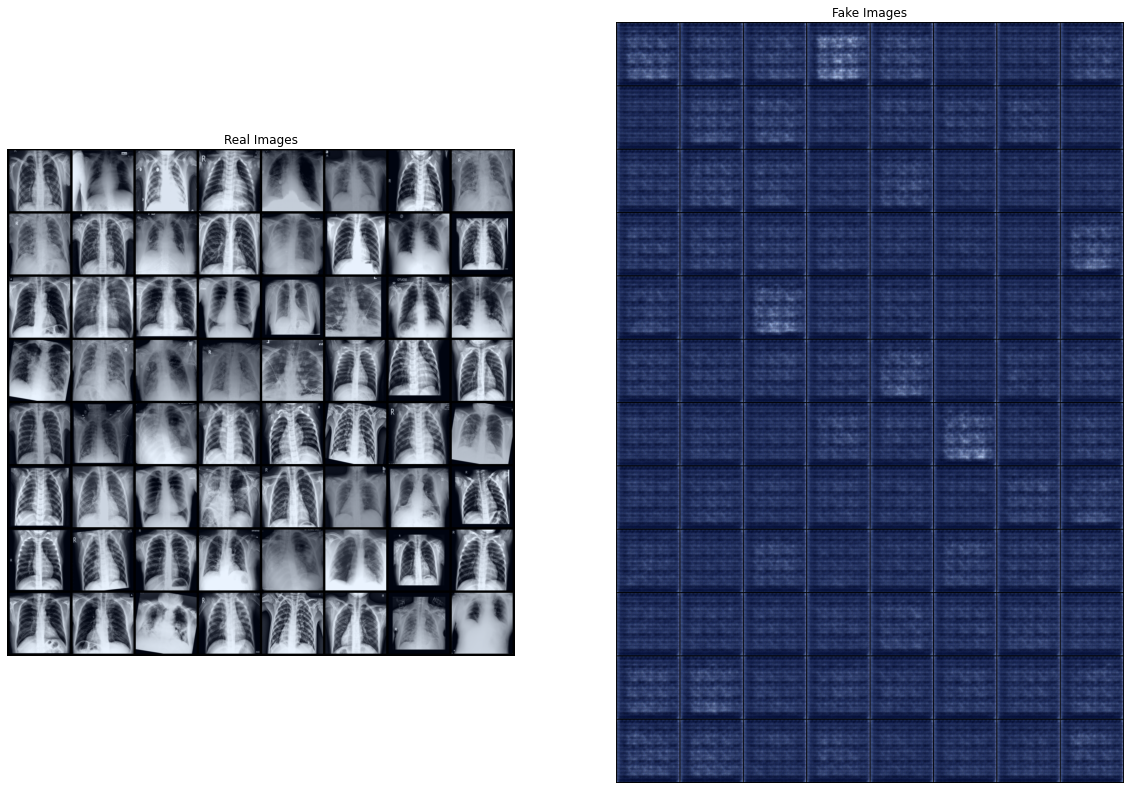

In [13]:
test_gan(acgan)

In [14]:
def plot_gan(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure(figsize=(20, 20))
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('Epoch')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    plt.show()
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H-%M-%S")))

In [15]:
def save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs):
    now = datetime.datetime.now()
    g_losses = metrics['G_losses'][-1]
    d_losses = metrics['D_losses'][-1]
    path='GANAug/plots/Lung/train_%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H-%M-%S"))
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)
    plot_gan('G_losses', num_epochs, metrics['G_losses'], path, True)
    plot_gan('D_losses', num_epochs, metrics['D_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('G_class_losses', num_epochs, metrics['G_class_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('D_class_losses', num_epochs, metrics['D_class_losses'], path, True)
    plot_gan('D_syn_losses', num_epochs, metrics['D_syn_losses'], path, True)
    plot_gan('Losses', num_epochs, metrics['Losses'], path, True)

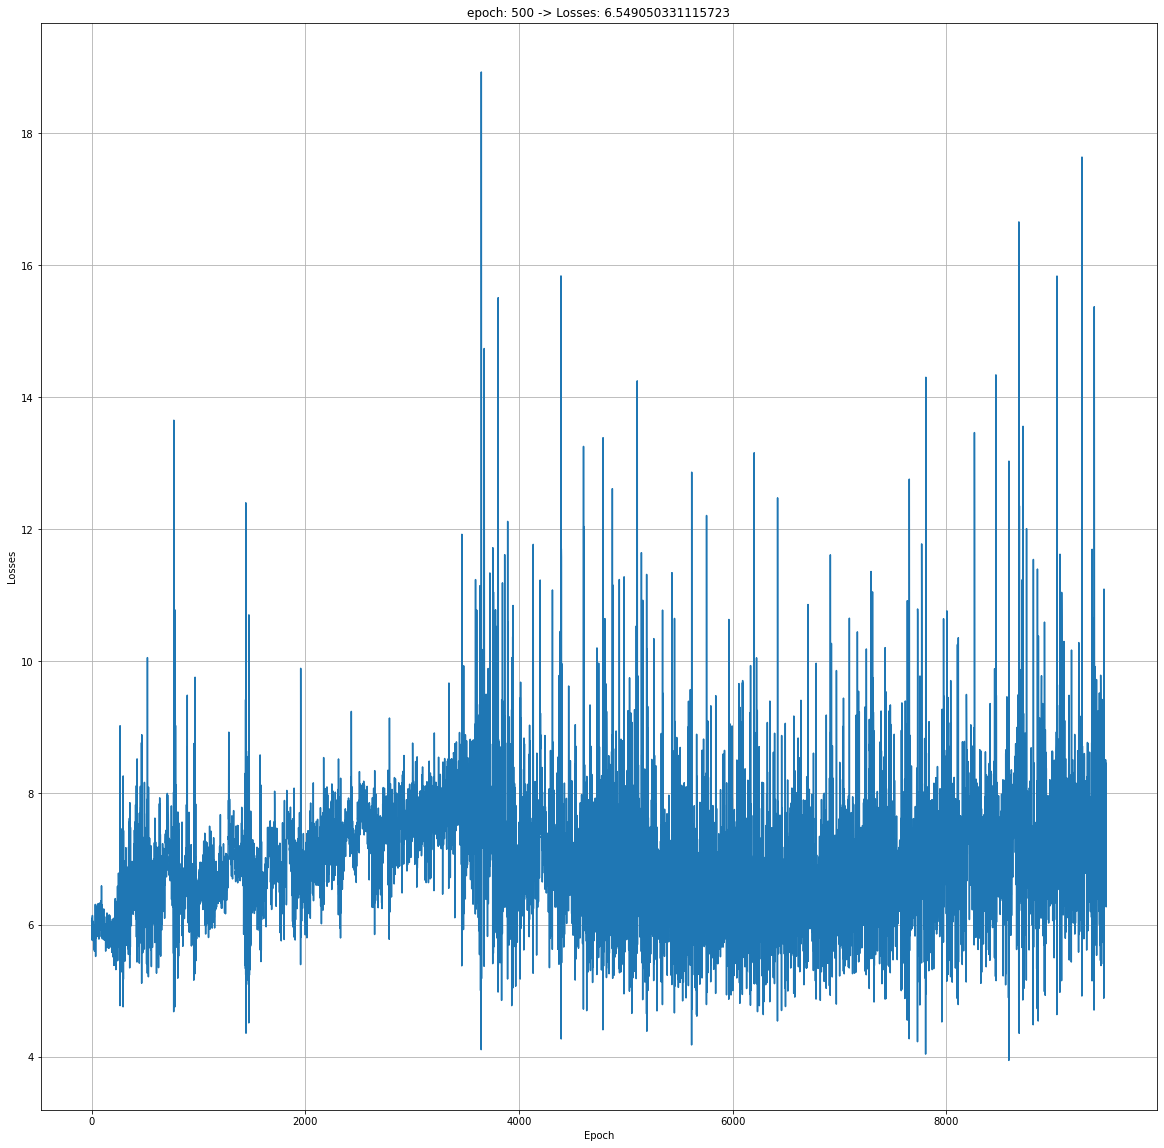

In [16]:
save_model(acgan.generator, acgan.discriminator, acgan.optimizer_g, acgan.optimizer_d, acgan.metrics, acgan.num_epoch)

C:\Users\lebro\AppData\Local\Temp\ipykernel_20908\1081463272.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = self.softmax(c)


Discriminator s tensor([[2.2166e-06],
        [6.4125e-06],
        [1.4265e-04],
        [1.1822e-06],
        [5.9695e-06],
        [1.4480e-06],
        [1.3647e-06],
        [1.3828e-05],
        [7.9377e-07],
        [2.1480e-05],
        [3.1282e-05],
        [4.5929e-06],
        [2.7941e-06],
        [1.3596e-06],
        [1.1996e-04],
        [2.1978e-05],
        [1.3797e-06],
        [2.1947e-06],
        [4.9140e-06],
        [2.2316e-05],
        [3.0800e-05],
        [2.5818e-04],
        [1.0975e-07],
        [4.6176e-05],
        [1.8678e-06],
        [4.5897e-06],
        [1.2980e-05],
        [8.6052e-06],
        [3.7284e-07],
        [2.0990e-05],
        [6.2317e-07],
        [3.2282e-06],
        [4.3126e-07],
        [1.0034e-05],
        [5.4428e-06],
        [9.1710e-06],
        [1.8080e-06],
        [4.8315e-05],
        [6.6401e-07],
        [5.1439e-06],
        [3.7630e-05],
        [1.1564e-07],
        [2.7288e-05],
        [7.9906e-05],
        [1.2013e

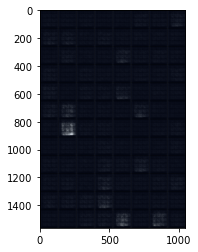

In [17]:
test_img_list = []
test_noise = torch.randn(acgan.batch_size, acgan.size_of_z, device=device)
test_label = torch.randn(acgan.batch_size, acgan.num_of_label, device=device)
test_img = acgan.generator(test_noise.resize_(acgan.batch_size, acgan.size_of_z, 1, 1))

s_output, c_label_op = acgan.discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))

class label for real tensor([2, 1, 1, 0, 0, 2, 0, 1, 1, 1, 0, 2, 2, 1, 2, 2, 1, 2, 0, 2, 1, 2, 0, 1,
        0, 1, 1, 2, 0, 2, 2, 1, 0, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 0, 1, 0, 0, 1,
        0, 1, 2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 1,
        1, 1, 2, 1, 2, 2, 2, 0, 1, 2, 0, 2, 0, 0, 1, 2, 1, 0, 2, 1, 0, 0, 0, 0])
Discriminator s 

C:\Users\lebro\AppData\Local\Temp\ipykernel_20908\1081463272.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = self.softmax(c)


tensor([[0.5180],
        [0.8369],
        [0.9943],
        [0.9242],
        [0.9258],
        [0.9942],
        [0.8976],
        [0.9358],
        [0.9458],
        [0.5848],
        [0.9995],
        [0.9712],
        [0.9998],
        [0.9978],
        [0.8501],
        [0.9900],
        [0.9721],
        [0.9881],
        [0.9799],
        [0.9803],
        [0.9995],
        [0.5671],
        [0.8984],
        [0.9966],
        [0.9685],
        [0.4265],
        [0.3869],
        [0.9622],
        [0.9992],
        [0.1208],
        [0.9944],
        [0.7470],
        [0.8744],
        [0.9806],
        [0.9976],
        [0.9895],
        [0.9678],
        [0.8632],
        [0.8591],
        [0.9116],
        [0.7422],
        [0.8919],
        [0.5588],
        [0.9846],
        [0.9858],
        [0.9434],
        [0.7067],
        [0.9356],
        [0.9924],
        [0.9999],
        [0.3811],
        [0.9877],
        [0.9947],
        [0.9851],
        [0.9471],
        [0

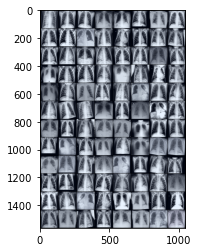

In [18]:
data = next(iter(acgan.test_loader))
test_noise, test_class_lable = data
test_img = test_noise
print('class label for real', test_class_lable)

s_output,c_label_op = acgan.discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))